In [ ]:
from re import S
from ctypes import create_unicode_buffer
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import time
import math
from itertools import combinations

from math import ceil
from functools import partial
from sklearn.decomposition import PCA



# ----------------------------------------------
# Multi-scale MMD divergence
# ----------------------------------------------

try:
    import cupy as cp
except Exception:
    cp = None
import numpy as np

M_MMD_DEFAULTS = {
    # kernel mixture
    "kernel": "rbf",        # 'rbf' or 'imq'
    "scales": None,         # list/array of bandwidths (RBF sigmas or IMQ c's). If None, use median heuristic.
    "scale_weights": None,  # list/array of nonnegative weights (same length as scales). If None, uniform.
    # median heuristic for automatic scales (used if scales=None)
    "use_median_heuristic": True,
    "num_scales": 5,        # number of scales in the mixture
    "scale_min": 0.5,       # lower multiplier relative to base (logspace)
    "scale_max": 2.0,       # upper multiplier relative to base (logspace)
    # estimator & output
    "unbiased": True,       # U-statistic (exclude diagonals in Kxx, Kyy)
    "squared": False,       # return MMD^2 if True, else sqrt(max(MMD^2,0))
    # kernel-specific params
    "imq_beta": 0.5,        # k_IMQ(d2) = (1 + d2 / c^2)^(-beta)
    # numerics
    "chunk_size": 4096,     # process pairwise blocks to limit memory
    "return_per_scale": False, # if True, also return dict with per-scale contributions
    # optional per-sample weights (length N_x / N_y). If provided, computes *weighted* MMD.
    "x_weights": None,
    "y_weights": None,
}

def _xp_of(arr):
    """Return array module (np or cp) that matches arr."""
    if cp is not None and isinstance(arr, cp.ndarray):
        return cp
    return np

def _as_xp(x, xp):
    """Ensure x is an xp array."""
    if xp is np:
        return np.asarray(x)
    else:
        return x if isinstance(x, xp.ndarray) else xp.asarray(x)

def _median_pairwise_sqdist(Z, xp, max_samples=1024):
    """Robust median of pairwise squared distances from a subsample."""
    n = Z.shape[0]
    if n <= 1:
        return xp.array(1.0, dtype=Z.dtype)
    idx = xp.random.permutation(n)[:min(n, max_samples)]
    S = Z[idx]
    # pairwise squared distances for the subsample
    S2 = xp.sum(S * S, axis=1, keepdims=True)
    D2 = xp.maximum(S2 + S2.T - 2 * (S @ S.T), 0.0)
    # exclude zeros on the diagonal
    tri = D2[~xp.eye(D2.shape[0], dtype=bool)]
    if tri.size == 0:
        return xp.array(1.0, dtype=Z.dtype)
    return xp.median(tri)

def _kernel_from_d2(d2, kernel, scale, xp, beta):
    """Evaluate kernel from squared distances."""
    if kernel == "rbf":
        # k(d2) = exp(- d2 / (2 sigma^2))
        inv2sig2 = 1.0 / (2.0 * (scale ** 2))
        return xp.exp(-d2 * inv2sig2)
    elif kernel == "imq":
        # k(d2) = (1 + d2 / c^2)^(-beta)
        return (1.0 + d2 / (scale ** 2)) ** (-beta)
    else:
        raise ValueError(f"Unknown kernel '{kernel}' (use 'rbf' or 'imq').")

def _sum_kernel_pairs_XY(X, Y, scales, weights, kernel, xp, beta, chunk, xw=None, yw=None):
    """
    Sum over k(x_i, y_j) for all i,j across a *mixture* of kernels.
    Returns per-scale sums as array [S] and normalization constant (weighted).
    """
    nx, ny = X.shape[0], Y.shape[0]
    S = xp.zeros((len(scales),), dtype=X.dtype)
    # normalization (weighted or unweighted)
    if xw is None and yw is None:
        norm = float(nx) * float(ny)
    else:
        xw = xp.ones(nx, dtype=X.dtype) if xw is None else xw
        yw = xp.ones(ny, dtype=Y.dtype) if yw is None else yw
        norm = float(xp.sum(xw) * xp.sum(yw))

    for i0 in range(0, nx, chunk):
        Xi = X[i0:i0 + chunk]
        # precompute norms for distance
        Xi2 = xp.sum(Xi * Xi, axis=1, keepdims=True)  # (bi,1)
        wi = None if xw is None else xw[i0:i0 + chunk]
        for j0 in range(0, ny, chunk):
            Yj = Y[j0:j0 + chunk]
            Yj2 = xp.sum(Yj * Yj, axis=1, keepdims=True)  # (bj,1)
            # (bi,bj) squared distances
            D2 = xp.maximum(Xi2 + Yj2.T - 2.0 * (Xi @ Yj.T), 0.0)
            # stack per-scale kernels with broadcasting: (S, bi, bj)
            Ks = xp.stack([_kernel_from_d2(D2, kernel, s, xp, beta) for s in scales], axis=0)
            if xw is None and yw is None:
                S += Ks.sum(axis=(1, 2))
            else:
                wj = yw[j0:j0 + chunk]
                W = (wi[:, None] * wj[None, :])  # (bi,bj)
                S += xp.tensordot(Ks, W, axes=((1, 2), (0, 1)))  # sum_{bi,bj} Ks[...,bi,bj]*W[bi,bj]
    # apply mixture weights here (leave per-scale sums unweighted for diagnostics)
    if weights is not None:
        total = float(xp.sum(weights * (S / norm)))
    else:
        total = float(xp.sum(S / norm))
    return S, norm, total

def _sum_kernel_pairs_XX(A, scales, weights, kernel, xp, beta, chunk, unbiased=True, aw=None):
    """
    Sum over k(a_i, a_j) across a *mixture* of kernels for a single set A.
    Returns per-scale sums as array [S] and normalization constant (weighted).
    For unbiased=True, excludes diagonals (i != j) using ordered-pairs normalization n(n-1).
    """
    n = A.shape[0]
    S = xp.zeros((len(scales),), dtype=A.dtype)

    if aw is None:
        if unbiased:
            norm = float(n) * float(max(n - 1, 1))
        else:
            norm = float(n) * float(n)
    else:
        aw = aw.astype(A.dtype, copy=False)
        s1 = xp.sum(aw)
        if unbiased:
            norm = float(s1 * s1 - xp.sum(aw * aw))
        else:
            norm = float(s1 * s1)

    for i0 in range(0, n, chunk):
        Ai = A[i0:i0 + chunk]
        Ai2 = xp.sum(Ai * Ai, axis=1, keepdims=True)
        wi = None if aw is None else aw[i0:i0 + chunk]
        j_start = i0  # upper blocks including diagonal
        for j0 in range(j_start, n, chunk):
            Aj = A[j0:j0 + chunk]
            Aj2 = xp.sum(Aj * Aj, axis=1, keepdims=True)
            D2 = xp.maximum(Ai2 + Aj2.T - 2.0 * (Ai @ Aj.T), 0.0)
            Ks = xp.stack([_kernel_from_d2(D2, kernel, s, xp, beta) for s in scales], axis=0)  # (S,bi,bj)

            if aw is None:
                if i0 == j0:
                    if unbiased:
                        # subtract diagonals; keep off-diagonals both (i,j) and (j,i) inside the block
                        diag = xp.stack([xp.diag(Ks[k]) for k in range(Ks.shape[0])], axis=0).sum(axis=1)
                        S += Ks.sum(axis=(1, 2)) - diag
                    else:
                        S += Ks.sum(axis=(1, 2))
                else:
                    # off-diagonal blocks contribute both (i,j) and (j,i)
                    S += 2.0 * Ks.sum(axis=(1, 2))
            else:
                wj = aw[j0:j0 + chunk]
                W = (wi[:, None] * wj[None, :])  # (bi,bj)
                if i0 == j0:
                    if unbiased:
                        # zero-out diagonal weights before summing
                        # subtract weighted diagonal: sum_k Ks[k]*W with diag set to 0
                        # Equivalent: total sum minus diag(K)*w^2
                        diag = xp.stack([xp.diag(Ks[k]) for k in range(Ks.shape[0])], axis=0)  # (S, b)
                        diag_w2 = (wi * wi)[None, :] * diag  # (S,b)
                        S += xp.tensordot(Ks, W, axes=((1, 2), (0, 1))) - diag_w2.sum(axis=1)
                    else:
                        S += xp.tensordot(Ks, W, axes=((1, 2), (0, 1)))
                else:
                    # both (i,j) and (j,i) pairs
                    S += 2.0 * xp.tensordot(Ks, W, axes=((1, 2), (0, 1)))
    if weights is not None:
        total = float(xp.sum(weights * (S / norm)))
    else:
        total = float(xp.sum(S / norm))
    return S, norm, total

def M_MMD(X, Y, params=None):
    """
    Multi-scale MMD divergence between sample sets X ~ P and Y ~ Q.

    Args:
        X: (N_x, d) numpy or cupy array.
        Y: (N_y, d) numpy or cupy array.
        params: dict overriding M_MMD_DEFAULTS.
            - kernel: 'rbf' or 'imq'
            - scales: list/array of bandwidths (RBF sigmas or IMQ c's). If None, automatic.
            - scale_weights: list/array (same length as scales). Defaults to uniform.
            - use_median_heuristic: if True and scales=None, set base scale from combined median distance.
                * RBF: base sigma = sqrt(0.5 * median(D^2)), then logspace multipliers [scale_min, scale_max]
                * IMQ: base c = sqrt(median(D^2)), then logspace multipliers
            - num_scales, scale_min, scale_max: for automatic scales (logspace).
            - unbiased: U-statistic (exclude diagonals in within terms).
            - squared: return MMD^2 if True; else return sqrt(max(MMD^2, 0)).
            - imq_beta: exponent for IMQ kernel.
            - chunk_size: block size for memory control.
            - x_weights, y_weights: optional per-sample nonnegative weights.
            - return_per_scale: if True, also returns a dict with per-scale pieces.

    Returns:
        mmd_value (float), and optionally (if return_per_scale) a dict with
        'per_scale_mmd2', 'scales', 'scale_weights'.
    """
    # merge params with defaults
    p = dict(M_MMD_DEFAULTS)
    if params is not None:
        p.update(params)

    # choose backend
    xp = _xp_of(X)
    X = _as_xp(X, xp)
    Y = _as_xp(Y, xp)
    X = X.reshape(X.shape[0], -1)
    Y = Y.reshape(Y.shape[0], -1)

    # weights (optional)
    xw = None if p["x_weights"] is None else _as_xp(p["x_weights"], xp).astype(X.dtype, copy=False)
    yw = None if p["y_weights"] is None else _as_xp(p["y_weights"], xp).astype(Y.dtype, copy=False)

    # build scales & weights
    if p["scales"] is None:
        # base scale from combined median distance
        Z = xp.concatenate([X, Y], axis=0)
        med2 = _median_pairwise_sqdist(Z, xp, max_samples=1024)
        if p["kernel"] == "rbf":
            base = xp.sqrt(xp.maximum(0.5 * med2, 1e-12))
        else:  # imq
            base = xp.sqrt(xp.maximum(med2, 1e-12))
        mul = xp.logspace(np.log10(p["scale_min"]), np.log10(p["scale_max"]), p["num_scales"])
        scales = base * mul
    else:
        scales = _as_xp(p["scales"], xp).astype(X.dtype, copy=False)

    if p["scale_weights"] is None:
        scale_weights = xp.ones((len(scales),), dtype=X.dtype) / float(len(scales))
    else:
        w = _as_xp(p["scale_weights"], xp).astype(X.dtype, copy=False)
        w_sum = xp.sum(w)
        scale_weights = w / (w_sum if float(w_sum) > 0 else 1.0)

    # compute per-set & cross sums, with mixture applied after normalization
    Sxx, nxx, mix_xx = _sum_kernel_pairs_XX(X, scales, scale_weights, p["kernel"], xp,
                                            p["imq_beta"], p["chunk_size"], p["unbiased"], xw)
    Syy, nyy, mix_yy = _sum_kernel_pairs_XX(Y, scales, scale_weights, p["kernel"], xp,
                                            p["imq_beta"], p["chunk_size"], p["unbiased"], yw)
    Sxy, nxy, mix_xy = _sum_kernel_pairs_XY(X, Y, scales, scale_weights, p["kernel"], xp,
                                            p["imq_beta"], p["chunk_size"], xw, yw)

    # Full mixture MMD^2
    mmd2 = (mix_xx + mix_yy - 2.0 * mix_xy)
    # numerical guard
    if mmd2 < 0.0:
        mmd2 = 0.0

    if p["squared"]:
        out = float(mmd2)
    else:
        out = float(np.sqrt(mmd2))  # safe cast; cp scalar ok through numpy sqrt of float

    if p["return_per_scale"]:
        # per-scale contributions *before* mixture weighting, but normalized
        per_scale = (Sxx / nxx) + (Syy / nyy) - 2.0 * (Sxy / nxy)
        # clamp small negatives
        per_scale = xp.maximum(per_scale, 0.0)
        return out, {
            "per_scale_mmd2": _as_xp(per_scale, np),  # move to numpy for easy logging
            "scales": _as_xp(scales, np),
            "scale_weights": _as_xp(scale_weights, np),
        }
    return out



# ------------------------------ Single-σ MMD ----------------------------------
def OT_MMD(X, Y, *, sigma=0.5, unbiased=False, chunk=4096):
    """
    Single-scale RBF MMD between X and Y with bandwidth `sigma`.
    Works with NumPy or CuPy arrays; keeps everything on-device if CuPy.
    """
    # choose xp
    xp = cp if (cp is not None and isinstance(X, cp.ndarray)) or \
               (cp is not None and isinstance(Y, cp.ndarray)) else np
    X = xp.asarray(X, dtype=xp.float64).reshape(X.shape[0], -1)
    Y = xp.asarray(Y, dtype=xp.float64).reshape(Y.shape[0], -1)
    n, m = X.shape[0], Y.shape[0]
    inv2s2 = 1.0 / (2.0 * (float(sigma) ** 2))

    def _rbf_sum(A, B):
        SA = xp.sum(A * A, axis=1, keepdims=True)
        SB = xp.sum(B * B, axis=1, keepdims=True)
        D2 = xp.maximum(SA + SB.T - 2.0 * (A @ B.T), 0.0)
        return xp.exp(-inv2s2 * D2).sum()

    if unbiased:
        # U-statistic: exclude self terms in Kxx, Kyy, normalize by n(n-1), m(m-1)
        # Block to limit memory
        def _self_sum(A):
            s = xp.array(0.0, dtype=xp.float64)
            NA = A.shape[0]
            for i0 in range(0, NA, chunk):
                Ai = A[i0:i0 + chunk]
                Ai2 = xp.sum(Ai * Ai, axis=1, keepdims=True)
                for j0 in range(0, NA, chunk):
                    Aj = A[j0:j0 + chunk]
                    Aj2 = xp.sum(Aj * Aj, axis=1, keepdims=True)
                    D2 = xp.maximum(Ai2 + Aj2.T - 2.0 * (Ai @ Aj.T), 0.0)
                    K = xp.exp(-inv2s2 * D2)
                    if i0 == j0:
                        K = K - xp.eye(K.shape[0], dtype=K.dtype)
                    s += K.sum()
            return s

        s_xx = _self_sum(X) / max(n * (n - 1), 1)
        s_yy = _self_sum(Y) / max(m * (m - 1), 1)

    else:
        # Biased estimator: include diagonals, normalize by n^2, m^2
        s_xx = _rbf_sum(X, X) / max(n * n, 1)
        s_yy = _rbf_sum(Y, Y) / max(m * m, 1)

    s_xy = _rbf_sum(X, Y) / max(n * m, 1)
    mmd2 = float((s_xx + s_yy - 2.0 * s_xy))
    return math.sqrt(mmd2) if mmd2 > 0 else 0.0


import numpy as np

def _pairwise_min_k_dists(A, B, k=1, chunk=2000):
    """
    For each a in A, return distance to k-th NN in B (Euclidean).
    Chunked to stay memory-safe. Returns shape [len(A),].
    """
    nA, nB = A.shape[0], B.shape[0]
    out = np.empty(nA, dtype=np.float64)
    k = max(1, int(k))

    for i in range(0, nA, chunk):
        Ai = A[i:i+chunk]  # [m, d]
        # pairwise squared distances (Ai - B)^2
        # (m,1,d) - (1,nB,d) -> (m,nB,d) -> sum over d -> (m,nB)
        d2 = np.sum((Ai[:, None, :] - B[None, :, :])**2, axis=2)
        # sort small k efficiently
        # np.partition is O(n), returns k smallest unordered; take [:, k-1]
        kth = np.partition(d2, kth=k-1, axis=1)[:, k-1]
        out[i:i+chunk] = np.sqrt(kth)
    return out

def copying_index(gen, train, test, k=1, alphas=(0.9, 0.8), max_pts=8000, chunk=2000):
    """
    Train-vs-Test kNN ratio memorization metric.
    Returns dict with ratio stats and alpha-thresholded fractions.
    Downsamples to max_pts if needed for speed.
    """
    # (Optional) downsample for speed
    if gen.shape[0] > max_pts:
        idx = np.random.permutation(gen.shape[0])[:max_pts]
        gen = gen[idx]
    if train.shape[0] > max_pts:
        idx = np.random.permutation(train.shape[0])[:max_pts]
        train = train[idx]
    if test.shape[0] > max_pts:
        idx = np.random.permutation(test.shape[0])[:max_pts]
        test = test[idx]

    dg_train = _pairwise_min_k_dists(gen, train, k=k, chunk=chunk)
    dg_test  = _pairwise_min_k_dists(gen, test,  k=k, chunk=chunk)

    eps = 1e-12
    ratios = dg_train / (dg_test + eps)  # <1 => closer to TRAIN
    out = {
        "copy_ratio_mean": float(np.mean(ratios)),
        "copy_ratio_median": float(np.median(ratios)),
    }
    for a in alphas:
        out[f"copy_frac_a{str(a).replace('.','')}"] = float(np.mean(ratios < a))
    return out

def duplicate_rate(gen, eps=1e-5, max_pts=10000, chunk=2000):
    """
    Near-duplicate rate inside generated samples (birthday test).
    Fraction of points whose 2nd-NN distance (exclude self) < eps.
    """
    if gen.shape[0] > max_pts:
        idx = np.random.permutation(gen.shape[0])[:max_pts]
        gen = gen[idx]
    # distance to 2nd NN: compute to B=A; the 1st NN is itself at 0
    d2 = []
    for i in range(0, gen.shape[0], chunk):
        Ai = gen[i:i+chunk]
        dist2 = np.sum((Ai[:, None, :] - gen[None, :, :])**2, axis=2)
        # set self-distances to +inf to ignore true diagonal
        rows = np.arange(dist2.shape[0])
        dist2[rows, i + rows] = np.inf
        # take the minimum distance (actual 1st NN excluding self)
        nn1 = np.min(dist2, axis=1)
        d2.append(nn1)
    nn = np.sqrt(np.concatenate(d2, axis=0))
    return float(np.mean(nn < eps))



# Script One, works well, just fits np estimators uses for sampling


def _to_numpy(arr):
    """Return a NumPy view; copy from GPU to CPU if the input is a CuPy array."""
    try:
        import cupy as cp
        if isinstance(arr, cp.ndarray):
            return arr.get()          # move to host
    except ImportError:
        pass                          # no CuPy in this env
    return np.asarray(arr)


def prune_cp_arr(x_cp, p_percent = 1):
    x = cp.asarray(x_cp)
    if x.ndim != 2:
        raise ValueError("expected a 2D CuPy array (N,d)")
    if not (0 <= p_percent <= 100):
        raise ValueError("p_percent must be in [0, 100]")

    N = x.shape[0]
    if N == 0:
        return x, cp.zeros(0, dtype=cp.bool_)

    finite_rows = cp.isfinite(x).all(axis=1)
    idx_finite = cp.where(finite_rows)[0]
    xf = x[finite_rows]
    M = xf.shape[0]

    if M == 0:
        return x[:0], cp.zeros(N, dtype=cp.bool_)

    if p_percent == 0:
        keep_mask = cp.zeros(N, dtype=cp.bool_)
        keep_mask[idx_finite] = True
        return xf, keep_mask
    if p_percent == 100:
        return x[:0], cp.zeros(N, dtype=cp.bool_)

    k = int(cp.ceil(M * (1.0 - p_percent / 100.0)).item())  # rows to keep among finite ones
    if k <= 0:
        return x[:0], cp.zeros(N, dtype=cp.bool_)

    norms = cp.linalg.norm(xf, axis=1)
    keep_local = cp.argpartition(norms, kth=k-1)[:k]  # indices of k smallest norms in xf

    keep_mask = cp.zeros(N, dtype=cp.bool_)
    keep_mask[idx_finite[keep_local]] = True
    return x[keep_mask], keep_mask


import cupy as cp



def sample_gmm_gpu(n_samples, means, stds, weights, *, seed=None):
    xp = cp
    means   = xp.asarray(means,   dtype=xp.float64)
    stds    = xp.asarray(stds,    dtype=xp.float64)
    weights = xp.asarray(weights, dtype=xp.float64).reshape(-1)

    C, D = means.shape
    if stds.ndim == 1 and stds.shape == (C,):
        cov_mode = "isotropic"
    elif stds.ndim == 2 and stds.shape == (C, D):
        cov_mode = "diag"
    elif stds.ndim == 3 and stds.shape == (C, D, D):
        cov_mode = "full"
    else:
        raise ValueError("stds must be (C,), (C,D), or (C,D,D)")

    probs = (weights / float(weights.sum())).ravel()
    rng = xp.random.RandomState(seed) if seed is not None else xp.random
    choices = rng.choice(C, size=int(n_samples), p=cp.asnumpy(probs))
    out = xp.empty((n_samples, D), dtype=xp.float64)

    for i in range(C):
        mask = (choices == i); cnt = int(mask.sum())
        if not cnt: continue
        z = rng.standard_normal((cnt, D), dtype=xp.float64)
        if cov_mode == "isotropic":
            out[mask] = means[i] + z * stds[i]
        elif cov_mode == "diag":
            out[mask] = means[i] + z * stds[i]          # (cnt,D) * (D,)
        else:  # full
            L = xp.linalg.cholesky(stds[i])             # Σ^{1/2}
            out[mask] = means[i] + z @ L.T
    return out



def score_gmm_gpu(x, means, stds, weights, batch_size=4096):
    """
    ∇_x log ∑_c w_c N(x; μ_c, Σ_c)
    stds:
      - (C,)   : isotropic std per comp  (σ_c)          -> Σ_c = σ_c^2 I
      - (C,D)  : diagonal std per comp   (σ_{c,d})      -> Σ_c = diag(σ^2)
      - (C,D,D): full covariance per comp (Σ_c SPD)
    """
    xp = cp
    x       = xp.asarray(x,       dtype=xp.float64)
    means   = xp.asarray(means,   dtype=xp.float64)
    weights = xp.asarray(weights, dtype=xp.float64).reshape(-1)
    stds    = xp.asarray(stds,    dtype=xp.float64)

    N, D = x.shape
    C    = means.shape[0]
    if N == 0:
        return xp.zeros((0, D), dtype=xp.float64)

    const = -0.5 * D * xp.log(2.0 * xp.pi)
    log_w = xp.log(weights + 1e-300)
    out   = xp.zeros_like(x)

    # ----- (1) Isotropic: stds = (C,)
    if stds.ndim == 1:
        inv_vars     = 1.0 / (stds**2)                 # (C,)
        log_det_vars = D * xp.log(stds**2)             # (C,)
        norm_const   = const - 0.5 * log_det_vars      # (C,)

        for i in range(0, N, batch_size):
            xb   = x[i:i+batch_size]                   # (B,D)
            diff = means[None, :, :] - xb[:, None, :]  # (B,C,D)
            quad = (diff**2).sum(axis=-1) * inv_vars[None, :]         # (B,C)

            logp = log_w[None, :] + norm_const[None, :] - 0.5 * quad  # (B,C)
            m    = xp.max(logp, axis=1, keepdims=True)
            resp = xp.exp(logp - m); resp /= resp.sum(axis=1, keepdims=True) + 1e-300

            contrib = (resp[:, :, None] * diff) * inv_vars[None, :, None]   # (B,C,D)
            out[i:i+batch_size] = contrib.sum(axis=1)

        return out

    # ----- (2) Diagonal: stds = (C,D)
    if stds.ndim == 2 and stds.shape[1] == D:
        inv_vars     = 1.0 / (stds**2)                 # (C,D)
        log_det_vars = xp.log(stds**2).sum(axis=1)     # (C,)
        norm_const   = const - 0.5 * log_det_vars      # (C,)

        for i in range(0, N, batch_size):
            xb   = x[i:i+batch_size]                   # (B,D)
            diff = means[None, :, :] - xb[:, None, :]  # (B,C,D)
            quad = ((diff**2) * inv_vars[None, :, :]).sum(axis=-1)          # (B,C)

            logp = log_w[None, :] + norm_const[None, :] - 0.5 * quad        # (B,C)
            m    = xp.max(logp, axis=1, keepdims=True)
            resp = xp.exp(logp - m); resp /= resp.sum(axis=1, keepdims=True) + 1e-300

            contrib = (resp[:, :, None] * diff) * inv_vars[None, :, :]      # (B,C,D)
            out[i:i+batch_size] = contrib.sum(axis=1)

        return out

    # ----- (3) Full: stds = (C,D,D)  (here 'stds' is Σ_c)
    if stds.ndim == 3 and stds.shape[1] == D and stds.shape[2] == D:
        # Cholesky once per component
        Ls      = xp.linalg.cholesky(stds)                                     # (C,D,D), Σ = L L^T
        log_det = 2.0 * xp.log(xp.diagonal(Ls, axis1=1, axis2=2)).sum(axis=1)  # (C,)
        norm_const = const - 0.5 * log_det                                     # (C,)

        for i in range(0, N, batch_size):
            xb    = x[i:i+batch_size]                         # (B,D)
            B     = xb.shape[0]
            logp  = xp.empty((B, C), dtype=xp.float64)
            grads = xp.empty((B, C, D), dtype=xp.float64)

            for c in range(C):
                L = Ls[c]                                      # (D,D)

                # quad term: (x - μ)^T Σ^{-1} (x - μ) = || L^{-1}(x-μ) ||^2
                diff_x = xb - means[c][None, :]                # (B,D)
                v = xp.linalg.solve(L, diff_x.T)               # (D,B)
                quad = xp.sum(v * v, axis=0)                   # (B,)
                logp[:, c] = log_w[c] + norm_const[c] - 0.5 * quad

                # gradient per comp: Σ^{-1}(μ - x) = L^{-T} L^{-1} (μ - x)
                diff_m = means[c][None, :] - xb                # (B,D)
                y = xp.linalg.solve(L, diff_m.T)               # (D,B)
                g = xp.linalg.solve(L.T, y).T                  # (B,D)
                grads[:, c, :] = g

            m    = xp.max(logp, axis=1, keepdims=True)
            resp = xp.exp(logp - m); resp /= resp.sum(axis=1, keepdims=True) + 1e-300

            out[i:i+batch_size] = xp.einsum("bc,bcd->bd", resp, grads)

        return out

    raise ValueError("stds must be (C,), (C,D), or (C,D,D) (the last is full covariances).")




def score_div_gmm(x, means, covs, weights, batch_size=4096):

    xp = cp
    x       = xp.asarray(x, dtype=xp.float64)
    means   = xp.asarray(means, dtype=xp.float64)
    covs    = xp.asarray(covs,  dtype=xp.float64)
    weights = xp.asarray(weights, dtype=xp.float64).reshape(-1)

    N, D = x.shape
    C    = means.shape[0]
    if N == 0:
        return xp.zeros_like(x), xp.zeros((0,), dtype=xp.float64)

    # --- weight normalization & constants
    wsum = xp.sum(weights)
    if not xp.isfinite(wsum) or wsum <= 0:
        raise ValueError("Mixture weights must sum to a positive value.")
    log_w = xp.log(weights / wsum + 1e-300)
    const = -0.5 * D * xp.log(2.0 * xp.pi)

    # --- covariance handling
    kind = None
    if covs.ndim == 1 and covs.shape[0] == C:             # isotropic stds
        kind     = "iso"
        inv_vars = 1.0 / (covs**2)                         # (C,)
        log_det  = D * xp.log(covs**2)                     # (C,)
        trA      = D * inv_vars                            # (C,)
    elif covs.ndim == 2 and covs.shape == (C, D):          # diagonal stds
        kind     = "diag"
        inv_vars = 1.0 / (covs**2)                         # (C,D)
        log_det  = xp.log(covs**2).sum(axis=1)             # (C,)
        trA      = inv_vars.sum(axis=1)                    # (C,)
    elif covs.ndim == 3 and covs.shape[1:] == (D, D):      # full Σ
        kind = "full"
        Ls, log_det, trA = [], xp.empty(C), xp.empty(C)
        I = xp.eye(D, dtype=xp.float64)
        for c in range(C):
            L = xp.linalg.cholesky(covs[c])
            Ls.append(L)
            log_det[c] = 2.0 * xp.sum(xp.log(xp.diag(L)))
            Z = xp.linalg.solve(L, I)                      # L^{-1}
            trA[c] = xp.sum(Z * Z)                         # ||L^{-1}||_F^2 = tr(Σ^{-1})
    else:
        raise ValueError("covs must be (C,), (C,D) with stds, or (C,D,D) with full covariances.")

    # --- outputs
    score = xp.empty_like(x)
    div   = xp.empty((N,), dtype=xp.float64)

    for i in range(0, N, batch_size):
        xb = x[i:i+batch_size]                             # (B,D)
        B  = xb.shape[0]

        # per-component log-densities and a_c = A_c (mu_c - x)
        if kind in ("iso", "diag"):
            diff = means[None, :, :] - xb[:, None, :]      # (B,C,D)
            if kind == "iso":
                quad = (diff**2).sum(-1) * inv_vars[None, :]          # (B,C)
                a    = diff * inv_vars[None, :, None]                  # (B,C,D)
            else:
                quad = ((diff**2) * inv_vars[None, :, :]).sum(-1)      # (B,C)
                a    = diff * inv_vars[None, :, :]                     # (B,C,D)
        else:
            quad = xp.empty((B, C), dtype=xp.float64)
            a    = xp.empty((B, C, D), dtype=xp.float64)
            for c in range(C):
                diff = (means[c][None, :] - xb)                        # (B,D)
                # a_c = Σ_c^{-1} diff via two triangular solves
                z = xp.linalg.solve(Ls[c], diff.T)                     # (D,B)
                u = xp.linalg.solve(Ls[c].T, z)                        # (D,B)
                a_c = u.T                                              # (B,D)
                a[:, c, :] = a_c
                quad[:, c] = xp.sum(diff * a_c, axis=1)                # diff^T Σ^{-1} diff

        log_comp = log_w[None, :] + const - 0.5*log_det[None, :] - 0.5*quad  # (B,C)
        m   = xp.max(log_comp, axis=1, keepdims=True)
        resp = xp.exp(log_comp - m)
        resp /= (resp.sum(axis=1, keepdims=True) + 1e-300)             # (B,C)
        s = xp.sum(resp[:, :, None] * a, axis=1)                        # (B,D)

        a_norm2 = xp.sum(a * a, axis=2)                                 # (B,C)
        s_dot_a = xp.sum(s[:, None, :] * a, axis=2)                     # (B,C)
        div_b   = xp.sum(resp * (a_norm2 - s_dot_a - trA[None, :]), axis=1)  # (B,)

        score[i:i+B] = s
        div[i:i+B]   = div_b

    return score, div


def hyvarinen_to_target(X, score_fn, div_fn, batch_size=65536):
    """
    Hyvärinen-to-target loss: E[ 0.5||s(x)||^2 + div s(x) ].
    `score_fn` returns (N,D), `div_fn` returns (N,).
    """
    xp = cp
    X  = xp.asarray(X, dtype=xp.float64)
    N  = X.shape[0]
    acc = 0.0
    cnt = 0
    for i in range(0, N, int(batch_size)):
        xb = X[i:i+batch_size]
        s  = score_fn(xb)
        dv = div_fn(xb)
        acc += float(xp.mean(0.5 * xp.sum(s*s, axis=1) + dv))
        cnt += 1
    return acc / max(cnt, 1)




def density_gmm_gpu(x, means, stds, weights, mode="absolute", iso_std=1.0, batch_size=4096):
    xp = cp
    x      = x.astype(xp.float64, copy=False)
    means  = means.astype(xp.float64, copy=False)
    stds   = stds.astype(xp.float64, copy=False)
    weights= weights.astype(xp.float64, copy=False)

    N, D = x.shape
    if N == 0:
        return xp.zeros((0,), dtype=xp.float64)

    # Normalize mixture weights safely
    wsum = weights.sum()
    if wsum <= 0:
        raise ValueError("Mixture weights must sum to a positive value.")
    w = weights / wsum
    log_w = xp.log(w + 1e-40)  # [C]

    # Handle variances and normalization constants
    if stds.ndim == 1:
        # Isotropic per-component: Σ_c = (std_c^2) * I
        inv_vars = 1.0 / (stds**2)                 # [C]
        log_det_vars = D * xp.log(stds**2)         # [C]  (since det = (std^2)^D)
    elif stds.ndim == 2 and stds.shape[1] == D:
        # Diagonal per-component: Σ_c = diag(std_{c,1}^2, ..., std_{c,D}^2)
        inv_vars = 1.0 / (stds**2)                 # [C, D]
        log_det_vars = xp.log(stds**2).sum(axis=1) # [C]  (since det = prod_d std_{c,d}^2)
    else:
        raise ValueError("`stds` must have shape (C,) or (C, D).")

    const = -0.5 * D * xp.log(2.0 * xp.pi)         # scalar
    norm_const = const - 0.5 * log_det_vars        # [C]

    out = xp.empty((N,), dtype=xp.float64)

    for i in range(0, N, batch_size):
        xb = x[i:i+batch_size]                     # [B, D]
        diff = xb[:, None, :] - means[None, :, :]  # [B, C, D]

        if inv_vars.ndim == 1:
            # quadratic term = sum_d (diff^2) * (1/std_c^2)
            d2 = (diff**2).sum(axis=-1)            # [B, C]
            quad = d2 * inv_vars[None, :]          # [B, C]
        else:
            # quadratic term = sum_d (diff^2 / std_{c,d}^2)
            quad = ((diff**2) * inv_vars[None, :, :]).sum(axis=-1)  # [B, C]

        # log component densities (including weights)
        log_comp = log_w[None, :] + norm_const[None, :] - 0.5 * quad  # [B, C]

        # log-sum-exp over components for numerical stability
        m = xp.max(log_comp, axis=1, keepdims=True)                   # [B, 1]
        log_mix = xp.squeeze(m, 1) + xp.log(xp.exp(log_comp - m).sum(axis=1))  # [B]

        if mode == "absolute":
            out[i:i+batch_size] = xp.exp(log_mix)                     # p_mix(x)
        elif mode == "relative":
            s2 = float(iso_std) ** 2
            # log phi_iso(x) for N(0, s2 I)
            log_iso = -0.5 * D * xp.log(2.0 * xp.pi * s2) - 0.5 * (xb**2).sum(axis=1) / s2  # [B]
            out[i:i+batch_size] = xp.exp(log_mix - log_iso)           # p_mix(x)/phi_iso(x)
        else:
            raise ValueError("mode must be 'absolute' or 'relative'.")

    return out
import cupy as cp



def get_ou_evolved_gmm_params(t, means0, stds0, w0):
    xp = cp
    means0 = xp.asarray(means0)
    e = xp.exp(-t)
    e2 = e * e

    # Evolved means
    m_t = e * means0

    S0 = xp.asarray(stds0)
    K = means0.shape[0]
    D = means0.shape[1]

    # --- Full covariance cases ---
    if (S0.ndim == 3 and S0.shape[-1] == S0.shape[-2]) or (S0.ndim == 2 and S0.shape[0] == S0.shape[1]):
        # Ensure shape (K, D, D)
        if S0.ndim == 2:  # (D, D) for all components
            S0 = xp.broadcast_to(S0[None, :, :], (K, D, D))
        # Σ_t = e^{-2t} Σ_0 + (1 - e^{-2t}) I
        eye = xp.eye(D, dtype=S0.dtype)[None, :, :]  # (1, D, D)
        Sigma_t = e2 * S0 + (1.0 - e2) * eye
        return m_t, Sigma_t, w0

    # --- Diagonal / isotropic std cases ---
    # Treat S0 as stds; compute variances elementwise with broadcasting
    v0 = S0 * S0
    v_t = e2 * v0 + (1.0 - e2)  # adds isotropic I term
    std_t = xp.sqrt(v_t)
    return m_t, std_t, w0


def OU_evolve_samples(y_cp, t_scalar):
    import cupy as cp
    y = cp.asarray(y_cp)
    t = float(t_scalar)
    et = cp.exp(-t)
    sigma = cp.sqrt(cp.maximum(1.0 - et*et, 0.0))
    z = cp.random.standard_normal(y.shape, dtype=y.dtype)
    return et * y + sigma * z


def samples_to_sampler(samples):
    samples = np.asarray(samples)
    N = samples.shape[0]
    def sampler(n):
        if n <= N:
            return samples[:n].copy()
        k = n // N; r = n % N
        out = [samples for _ in range(k)]
        if r: out.append(samples[:r])
        return np.concatenate(out, axis=0).copy()
    return sampler


import numpy as np
try:
    import cupy as cp
except Exception:
    cp = None

import numpy as np
try:
    import cupy as cp
except Exception:
    cp = None



def normalize_gmm_params(means, stds, weights, *, mode="global", eps=1e-12):
    """
    Center & scale a GMM so the mixture mean is 0 and the marginal variance is 1.

    Inputs
    ------
    means   : (C, D)
    stds    : (C,)  or (C, D)     # isotropic or diagonal per component (std, not var)
    weights : (C,)
    mode    : "global" -> one scalar scale s so average marginal variance == 1
              "per_dim" -> vector scale s_d so EACH marginal variance == 1

    Returns
    -------
    means_n : (C, D)
    stds_n  : (C,)  if input was (C,) and mode="global"
              (C,D) if mode="per_dim" or input was (C,D)
    weights_n : (C,)   (re-normalized to sum to 1)
    """
    # pick backend
    try:
        import cupy as cp
        xp = cp if isinstance(means, cp.ndarray) else __import__("numpy")
    except Exception:
        import numpy as np
        xp = np

    m = xp.asarray(means,   dtype=xp.float64)
    s = xp.asarray(stds,    dtype=xp.float64)
    w = xp.asarray(weights, dtype=xp.float64)

    # normalize weights
    w = xp.clip(w, 0, xp.inf)
    ws = w.sum()
    if not xp.isfinite(ws) or ws <= 0:
        raise ValueError("weights must sum to a positive value.")
    w = w / ws

    C, D = m.shape

    # per-dimension variance contributions
    if s.ndim == 1:          # isotropic per component
        var_terms = (s**2)[:, None]                # (C,1) -> broadcast to (C,D)
    elif s.ndim == 2 and s.shape[1] == D:
        var_terms = s**2                            # (C,D)
    else:
        raise ValueError("stds must have shape (C,) or (C,D).")

    # mixture stats
    mu_mix  = w @ m                                  # (D,)
    Ex2     = (w[:, None] * (var_terms + m**2)).sum(axis=0)  # (D,)
    var_mix = xp.maximum(Ex2 - mu_mix**2, eps)       # (D,)

    if mode == "global":
        scale = xp.sqrt(var_mix.mean())              # scalar s
        m_n = (m - mu_mix[None, :]) / scale
        s_n = s / scale                              # keeps shape of s
    elif mode == "per_dim":
        scale = xp.sqrt(var_mix)                     # (D,)
        m_n = (m - mu_mix[None, :]) / scale[None, :]
        if s.ndim == 1:
            s_n = s[:, None] / scale[None, :]        # becomes diagonal (C,D)
        else:
            s_n = s / scale[None, :]
    else:
        raise ValueError('mode must be "global" or "per_dim".')

    return (m_n.astype(means.dtype, copy=False),
            s_n.astype(stds.dtype,  copy=False),
            w.astype(weights.dtype, copy=False))




def get_gmm_funcs(
    num_c: int = 200,
    k_dim: int = 5,
    variant: str = "helix",
    comp_std: float = 0.10,
    overall_scale: float = 1.0,
    rs=None,
    m_dim: int = 3,
    powerlaw_weights: bool = True,
    seed: int = 0,
    stds_specified = None,
    weights_specified = None,
    preset_params = None,
    normalize = False,
    size = 1,
    embedding_mode: str = "linear"  # NEW
):
    # ---- RNG (seeded if requested) -----------------------------------------
    if rs is not None and not isinstance(rs, np.random.RandomState):
        raise TypeError("rs must be a numpy.random.RandomState")
    rng = rs if rs is not None else (np.random.RandomState(seed) if seed is not None
                                     else np.random.RandomState())

    xp = cp
    m_embed = m_dim  # intrinsic dimension placeholder; updated by some variants

    # -------------------------- helpers (NEW) -------------------------------
    def _qr_tall(k, m):
        """Q in R^{k×m} with orthonormal columns (k >= m)."""
        Q, _ = np.linalg.qr(rng.randn(k, m))
        return Q[:, :m]

    def _qr_wide(m, k):
        """A in R^{m×k} with orthonormal columns (k <= m)."""
        G = rng.randn(m, k)
        # Orthonormalize columns of G via SVD
        U, _, Vt = np.linalg.svd(G, full_matrices=False)
        return (U @ Vt)  # shape (m×k), columns orthonormal

    def _orthonormal_complement(Q, k, s):
        """Given Q (k×m) with orthonormal cols, return Q_perp (k×s) orthonormal & Q^T Q_perp = 0."""
        if s <= 0:
            return None
        G = rng.randn(k, s)
        G = G - Q @ (Q.T @ G)
        Qp, _ = np.linalg.qr(G)
        return Qp[:, :s]

    def _embed_linear(X_intr):
        # Preserve original behavior (branch uses m_dim, not m_embed)
        if k_dim > m_dim:
            Q = _qr_tall(k_dim, X_intr.shape[1])  # k×m_embed
            Z = X_intr @ Q.T                      # num_c×k
            covs = np.array([ (comp_std**2) * (Q @ Q.T) + (1e-4*comp_std)**2*np.eye(k_dim)
                              for _ in range(num_c) ])
        else:
            Z = X_intr[:, :k_dim]
            covs = np.array([ (comp_std**2) * np.eye(k_dim) for _ in range(num_c) ])
        return Z, covs

    def _embed_sine_wiggle(X_intr, amp=0.25, freq=1.0):
        m = X_intr.shape[1]
        # base linear map into k-dim
        if k_dim >= m:
            Q = _qr_tall(k_dim, m)               # k×m
            Zlin = X_intr @ Q.T                  # num_c×k
            # add wiggle in orthogonal directions
            s = min(max(1, m), max(0, k_dim - m))
            Q_perp = _orthonormal_complement(Q, k_dim, s)
            if Q_perp is not None:
                R = rng.randn(s, m) * freq
                b = rng.uniform(0.0, 2*np.pi, size=(s,))
                H = np.sin(X_intr @ R.T + b)     # num_c×s
                Zwig = H @ Q_perp.T              # num_c×k
                Z = Zlin + amp * Zwig
            else:
                Z = Zlin
        else:
            # reduce then wiggle using internal orthonormal columns
            A = _qr_wide(m, k_dim)               # m×k
            Zlin = X_intr @ A                    # num_c×k
            # small nonlinear bump inside the current k-subspace
            R = rng.randn(k_dim, m) * freq
            b = rng.uniform(0.0, 2*np.pi, size=(k_dim,))
            H = np.sin(X_intr @ R.T + b)         # num_c×k
            Z = Zlin + amp * H
        covs = np.array([ (comp_std**2) * np.eye(k_dim) for _ in range(num_c) ])
        return Z, covs

    def _embed_rff(X_intr, freq=1.0):
        m = X_intr.shape[1]
        M = max(1, k_dim // 2)
        W = rng.randn(M, m) * freq
        b = rng.uniform(0.0, 2*np.pi, size=(M,))
        C = np.cos(X_intr @ W.T + b)
        S = np.sin(X_intr @ W.T + b)
        Z = np.concatenate([C, S], axis=1)
        if Z.shape[1] < k_dim:
            pad = X_intr @ rng.randn(m, k_dim - Z.shape[1])
            Z = np.concatenate([Z, pad], axis=1)
        else:
            Z = Z[:, :k_dim]
        covs = np.array([ (comp_std**2) * np.eye(k_dim) for _ in range(num_c) ])
        return Z, covs

    def _embed_radial(X_intr):
        r = np.linalg.norm(X_intr, axis=1, keepdims=True)
        feats = [X_intr, r, r**2, np.sin(r), np.cos(r)]
        Z = np.concatenate(feats, axis=1)
        while Z.shape[1] < k_dim:
            w = rng.randn(X_intr.shape[1])
            Z = np.hstack([Z, (X_intr @ w[:, None])**2])
        Z = Z[:, :k_dim]
        covs = np.array([ (comp_std**2) * np.eye(k_dim) for _ in range(num_c) ])
        return Z, covs

    # --------------------------- custom branch ------------------------------
    if variant == "custom":
        if preset_params is not None:
            means_np, stds_np, weights_np = preset_params
        else:
            # draw random means in R^k_dim
            means_np = rng.randn(num_c, k_dim) * overall_scale
            # isotropic component stds
            stds_np  = np.full(num_c, comp_std, dtype=float)
            # random non-uniform weights
            weights_np = rng.rand(num_c)
            weights_np /= weights_np.sum()
        # move to GPU
        means   = xp.asarray(means_np, dtype=xp.float64)
        stds    = xp.asarray(stds_np,   dtype=xp.float64)
        weights = xp.asarray(weights_np, dtype=xp.float64)

        def sampler(n, seed=None, debug=False):
            return sample_gmm_gpu(n, means, stds, weights, seed=seed)

        def score_func(x):
            return score_gmm_gpu(x, means, stds, weights)

        def density_func(x):
            return density_gmm_gpu(x, means, stds, weights, mode='absolute')

        def score_div_func(x):
            _, d = score_div_gmm(x, means, stds, weights)
            return d

        params = (means, stds, weights)
        return params, sampler, score_func, density_func, score_div_func

    # ---------- 1) build intrinsic manifold in R^{m_embed} -----------------
    if variant == "helix":
        t = np.linspace(0, 4*np.pi, num_c)
        r = 1.0 + 0.25 * np.sin(3*t)
        xyz = np.stack([r*np.cos(t), r*np.sin(t), 0.4*t], axis=1)
        X_intr = xyz; m_embed = 3

    elif variant == "concentric":
        shells    = 3
        shell_id  = np.repeat(np.arange(shells),
                              int(np.ceil(num_c / shells)))[:num_c]
        radii     = 0.7 + 0.7 * shell_id
        vecs      = rng.randn(num_c, m_dim)
        vecs     /= np.linalg.norm(vecs, axis=1, keepdims=True)
        X_intr    = radii[:, None] * vecs
        m_embed   = m_dim

    elif variant == "sparse":
        xyz       = rng.uniform(-2.5, 2.5, size=(num_c, m_dim))
        if m_dim >= 2:
            xyz[:, 1] *= 0.3
        if m_dim >= 3:
            xyz[:, 2] *= 0.1
        if m_dim > 3:
            xyz[:, 3:] *= 0.05
        X_intr = xyz; m_embed = m_dim

    elif variant == "knotted_torus":
        t = np.linspace(0, 2*np.pi, num_c)
        r = 0.1
        knot_x = (2 + np.cos(5*t)) * np.cos(3*t)
        knot_y = (2 + np.cos(5*t)) * np.sin(3*t)
        knot_z = np.sin(5*t)
        base = np.stack([knot_x, knot_y, knot_z], axis=1)

        tan = np.gradient(base, axis=0)
        tan /= np.linalg.norm(tan, axis=1, keepdims=True) + 1e-12
        rnd = rng.randn(num_c, 3)
        n1 = rnd - (rnd * tan).sum(1, keepdims=True) * tan
        n1 /= np.linalg.norm(n1, axis=1, keepdims=True) + 1e-12
        n2 = np.cross(tan, n1)
        n2 /= np.linalg.norm(n2, axis=1, keepdims=True) + 1e-12

        theta  = rng.uniform(0, 2*np.pi, num_c)
        tube_r = r * (0.7 + 0.3 * np.sin(6*t + 0.5))
        xyz = base + tube_r[:, None] * (np.cos(theta)[:, None]*n1 + np.sin(theta)[:, None]*n2)
        xyz += 0.05 * rng.randn(*xyz.shape) * (0.5 + 0.5 * np.sin(8*t)[:, None])
        X_intr = xyz; m_embed = 3

    else:
        raise ValueError("unknown variant")

    # ---------- 2) embed into R^{k_dim} per embedding_mode -----------------
    if embedding_mode == "linear":
        means_np, covs = _embed_linear(X_intr)
    elif embedding_mode == "sine_wiggle":
        means_np, covs = _embed_sine_wiggle(X_intr, amp=0.5, freq=1.0)
    elif embedding_mode == "rff":
        means_np, covs = _embed_rff(X_intr, freq=1.0)
    elif embedding_mode == "radial":
        means_np, covs = _embed_radial(X_intr)
    else:
        raise ValueError(f"unknown embedding_mode: {embedding_mode}")

    # ---------- 3) center & scale ------------------------------------------
    means_np *= overall_scale / np.max(np.abs(means_np))
    means  = xp.asarray(means_np, dtype=xp.float64)

    # ---------- 4) stds/weights (respect variant-provided if any) ----------
    if not stds_specified:
        stds_np    = np.full(num_c, comp_std, dtype=float)
    if not weights_specified:
        weights_np = np.full(num_c, 1.0/num_c, dtype=float)

    stds    = xp.asarray(stds_np, dtype=xp.float64)
    weights = xp.asarray(weights_np, dtype=xp.float64)

    # Optional normalization to a target size box
    if normalize:
        means, stds, weights = normalize_gmm_params(means, stds, weights)
        means, stds = size * means, size * stds

    # ---------- 5) public API: sampler/score/density -----------------------
    def sampler(n, seed=None):
        return sample_gmm_gpu(n, means, stds, weights, seed=seed)

    def score_func(x):
        return score_gmm_gpu(x, means, stds, weights)

    def density_func(x):
        return density_gmm_gpu(x, means, stds, weights, mode='absolute')

    def score_div_func(x):
        _, d = score_div_gmm(x, means, stds, weights)
        return d

    params = (means, stds, weights)  # covs computed above if you need it internally
    return params, sampler, score_func, density_func, score_div_func


def _rand_orth(d, k, seed=None):
    rs = cp.random.RandomState(seed) if seed is not None else cp.random
    G = rs.standard_normal((d, k), dtype=cp.float64)
    # thin QR, make orthonormal columns
    Q, _ = cp.linalg.qr(G, mode='reduced')
    return Q  # d x k


def embed_base(dist, d: int, *, sigma_perp=0.0, rotate=True, seed=None):
    """
    dist: object with 2 callables
        - dist['sample_k'](n, seed) -> cp.ndarray [n,k]
        - dist['score_k'](Z)        -> cp.ndarray [n,k]
    Returns (sampler_func, score_func) on R^d.

    Embedding: x = Q_k z  +  Q_perp eps,  eps ~ N(0, sigma_perp^2 I_{d-k})
    Score:     s(x) = Q_k s_z  +  Q_perp s_eps,  s_eps = -(1/sigma_perp^2) eps
    """
    k = dist['sample_k'](1, seed=seed).shape[1]
    assert 1 <= k <= d
    if rotate:
        Qk = _rand_orth(d, k, seed=seed)
        # Build an orthonormal complement (cheap Gram-Schmidt on random)
        Qp = _rand_orth(d, d, seed=(None if seed is None else seed+1))
        # Re-orth so [Qk | Qperp] spans R^d with Qk preserved
        # Householder trick: project Qp off Qk
        Qp = Qp - Qk @ (Qk.T @ Qp)
        # Orthonormalize columns and take first d-k
        Qp, _ = cp.linalg.qr(Qp, mode='reduced')
        Qp = Qp[:, :d-k] if d>k else cp.zeros((d,0), dtype=cp.float64)
    else:
        Qk = cp.pad(cp.eye(k, dtype=cp.float64), ((0, d-k),(0,0)))  # top k of I_d
        Qp = cp.pad(cp.eye(d-k, dtype=cp.float64), ((k,0),(0,0)))

    sigma_perp = float(sigma_perp)
    inv_perp2  = 0.0 if sigma_perp==0.0 else 1.0/(sigma_perp**2)

    def sampler_func(n, seed=None):
        Z = dist['sample_k'](int(n), seed=seed)                  # [n,k]
        if d == k:
            return (Qk @ Z.T).T
        rs = cp.random.RandomState(seed) if seed is not None else cp.random
        eps = rs.standard_normal((int(n), d-k), dtype=cp.float64) * sigma_perp
        X = (Qk @ Z.T).T + (Qp @ eps.T).T
        return X

    def score_func(X):
        X = cp.asarray(X, dtype=cp.float64)
        Z   = (Qk.T @ X.T).T                                     # [n,k]
        s_k = dist['score_k'](Z)                                 # [n,k]
        if d == k:
            return (Qk @ s_k.T).T
        eps = (Qp.T @ X.T).T                                     # [n,d-k]
        s_perp = -inv_perp2 * eps
        S = (Qk @ s_k.T).T + (Qp @ s_perp.T).T
        return S

    return sampler_func, score_func


def make_banana_2d(beta=0.25, a=1.0, sigma1=1.0, sigma2=0.1):
    def sample_k(n, seed=None):
        rs = cp.random.RandomState(seed) if seed is not None else cp.random
        z1 = rs.standard_normal(int(n)) * sigma1
        u  = rs.standard_normal(int(n)) * sigma2
        z2 = u - beta*(z1**2 - a)
        return cp.stack([z1, z2], axis=1).astype(cp.float64)

    def score_k(Z):
        Z = cp.asarray(Z, dtype=cp.float64)
        z1, z2 = Z[:,0], Z[:,1]
        y = z2 + beta*(z1*z1 - a)
        s1 = - z1/(sigma1**2) - (2*beta*z1*y)/(sigma2**2)
        s2 = - y/(sigma2**2)
        return cp.stack([s1, s2], axis=1)
    return {'sample_k': sample_k, 'score_k': score_k}


def make_ring_2d(R=3.0, sigma_r=0.1, with_jacobian=True):
    def sample_k(n, seed=None):
        rs = cp.random.RandomState(seed) if seed is not None else cp.random
        theta = rs.uniform(0, 2*cp.pi, int(n))
        r = R + rs.standard_normal(int(n)) * sigma_r
        z = cp.stack([r*cp.cos(theta), r*cp.sin(theta)], axis=1)
        return z.astype(cp.float64)

    def score_k(Z):
        Z = cp.asarray(Z, dtype=cp.float64)
        r = cp.linalg.norm(Z, axis=1) + 1e-12
        coef = -(r - R)/(sigma_r**2)
        if with_jacobian:
            coef = coef + 1.0/r
        return (coef[:,None] * (Z / r[:,None])).astype(cp.float64)

    return {'sample_k': sample_k, 'score_k': score_k}



def _xp_random(seed=None, use_cupy=True):
    if use_cupy and cp is not None:
        if seed is not None: cp.random.seed(seed)
        return cp
    rng = np.random.RandomState(seed)
    class NPShim:
        random = rng
        def asarray(self, x, dtype=None): return np.asarray(x, dtype=dtype)
        def zeros(self, shape, dtype=None): return np.zeros(shape, dtype=dtype)
        def ones(self, shape, dtype=None): return np.ones(shape, dtype=dtype)
        def exp(self, x): return np.exp(x)
        def sin(self, x): return np.sin(x)
        def cos(self, x): return np.cos(x)
        def dot(self, a,b): return a @ b
        def maximum(self, a,b): return np.maximum(a,b)
        def minimum(self, a,b): return np.minimum(a,b)
        def sqrt(self, x): return np.sqrt(x)
        def where(self, cond, a, b): return np.where(cond, a, b)
        def eye(self, n): return np.eye(n)
        def stack(self, arrs, axis=0): return np.stack(arrs, axis=axis)
        def concatenate(self, arrs, axis=0): return np.concatenate(arrs, axis=axis)
        def norm(self, x, axis=None): return np.linalg.norm(x, axis=axis)
    return NPShim()

def make_corrugated_gaussian(k=6, r=None, omega=80.0, c=0.6, use_cupy=True, seed=0):
    """
    Toy distribution in R^k with 'r' sinusoidal corrugations along orthonormal directions.
    Returns a dict with 'sample_k' and 'score_k' just like the banana/ring toys.

    log p(x) = -1/2 ||x||^2  - (c/omega) * sum_{j=1}^r sin(omega v_j^T x)
    ⇒ score(x) = -x - c * sum_j cos(omega v_j^T x) v_j
    The likelihood ratio to N(0,I) is bounded by exp(± r*c/omega) (so no huge spikes if r*c/omega is modest).
    """
    # pick backend RNG/array module (your helper keeps cp when available)
    xp = _xp_random(seed=seed, use_cupy=use_cupy)
    if r is None:
        r = min(3, k)  # default: a few ripples but <= k
    assert 1 <= r <= k, "require 1 <= r <= k"

    # Build V ∈ R^{k×r} with orthonormal columns in the SAME array library
    # Generate Gaussian (k×r), QR -> V
    if xp is cp:
        W = xp.random.randn(k, r)
        Q, _ = xp.linalg.qr(W, mode='reduced')   # (k,r)
        V = Q
    else:
        W = np.random.RandomState(seed).randn(k, r)
        Q, _ = np.linalg.qr(W)                   # (k,r)
        V = xp.asarray(Q)

    omega = float(omega); c = float(c)
    rho = c / omega   # appears in the target potential, controls closeness to Gaussian

    def _proj(X):  # (n,k) -> (n,r)
        return X @ V

    # exact score in R^k
    def score_k(Z):
        Z = xp.asarray(Z, dtype=xp.float64)
        U = _proj(Z)                              # (n,r)
        C = xp.cos(omega * U)                     # (n,r)
        return (-Z - (c * C) @ V.T).astype(xp.float64)

    # rejection sample from N(0,I) with envelope exp(r * rho)
    # acceptance ≥ exp(-r*rho) and no host/device copying
    def sample_k(n, seed=None, batch=8192):
        xp_loc = _xp_random(seed=seed, use_cupy=use_cupy)
        out = []
        need = int(n)
        logC = r * rho
        while need > 0:
            m = max(batch, need)
            Z = xp_loc.random.randn(m, k).astype(xp.float64)
            U = Z @ V                              # (m,r)
            w = xp_loc.exp(-rho * xp_loc.sin(omega * U)).prod(axis=1)
            acc = w / xp_loc.exp(logC)
            u = xp_loc.random.rand(m)
            keep = u < acc
            if keep.sum() > 0:
                out.append(Z[keep])
                need -= int(keep.sum())
        return xp.concatenate(out, axis=0)[:n]

    return {'sample_k': sample_k, 'score_k': score_k}



def make_funnel(m):
    d = m + 1
    def sample_k(n, seed=None):
        rs = cp.random.RandomState(seed) if seed is not None else cp.random
        z  = rs.standard_normal(int(n))
        x  = rs.standard_normal((int(n), m)) * cp.exp(z)[:,None]
        return cp.concatenate([x, z[:,None]], axis=1).astype(cp.float64)

    def score_k(Z):
        Z = cp.asarray(Z, dtype=cp.float64)
        x, z = Z[:, :m], Z[:, m]
        ezm2 = cp.exp(-2.0*z)
        s_x  = - (ezm2[:,None] * x)
        s_z  = - z + ezm2 * cp.sum(x*x, axis=1) - m
        return cp.concatenate([s_x, s_z[:,None]], axis=1)
    return {'sample_k': sample_k, 'score_k': score_k}



def make_student_t(k, nu=5.0, Sigma=None, seed=None):
    rs = cp.random.RandomState(seed) if seed is not None else cp.random
    if Sigma is None:
        # strong anisotropy
        scales = cp.asarray(cp.logspace(np.log10(0.1), np.log10(5.0), num=k), dtype=cp.float64)
        L = cp.diag(scales)
        Sinv = cp.diag(1.0/(scales**2))
    else:
        S = cp.asarray(Sigma, dtype=cp.float64)
        L = cp.linalg.cholesky(S)
        Sinv = cp.linalg.inv(S)

    def sample_k(n, seed=None):
        rng = cp.random.RandomState(seed) if seed is not None else cp.random
        eps = rng.standard_normal((int(n), k), dtype=cp.float64)
        g   = rng.chisquare(df=nu, size=int(n)).astype(cp.float64)
        x   = (eps @ L.T) / cp.sqrt(g/nu)[:,None]
        return x

    def score_k(Z):
        Z = cp.asarray(Z, dtype=cp.float64)
        Mah = cp.einsum('nd,dd,nd->n', Z, Sinv, Z)           # x^T S^{-1} x
        coef = - (nu + k) / (nu + Mah)
        return coef[:,None] * (Z @ Sinv.T)
    return {'sample_k': sample_k, 'score_k': score_k}



def make_k_rotated_banana(K=6, beta=0.25, a=1.0, sigma1=1.0, sigma2=0.1):
    base = make_banana_2d(beta, a, sigma1, sigma2)
    thetas = cp.linspace(0, 2*cp.pi, K, endpoint=False)
    Rks = cp.stack([cp.stack([cp.cos(t), -cp.sin(t)], axis=0)
                    for t in thetas], axis=0)  # [K,2]
    Rks = cp.stack([cp.stack([Rks[i], cp.stack([cp.sin(thetas[i]), cp.cos(thetas[i])])],axis=0)
                    for i in range(K)], axis=0)  # [K,2,2]

    def sample_k(n, seed=None):
        rs = cp.random.RandomState(seed) if seed is not None else cp.random
        idx = rs.randint(0, K, size=int(n))
        Z   = base['sample_k'](int(n), seed=None)
        # rotate each sample by chosen R_k
        X = cp.einsum('nij,nj->ni', Rks[idx], Z)
        return X

    def _logp_k(Z):
        # compute log p_k for each k by un-rotating into banana frame
        # log p up to constant from base form
        Z = cp.asarray(Z, dtype=cp.float64)
        Y = cp.einsum('kij,nj->nki', Rks.transpose(0,2,1), Z)  # [n,K,2]
        z1, z2 = Y[...,0], Y[...,1]
        y = z2 + beta*(z1*z1 - a)
        lp = -0.5*(z1*z1/(sigma1**2) + y*y/(sigma2**2))  # [n,K]
        return lp

    def score_k(Z):
        Z = cp.asarray(Z, dtype=cp.float64)
        lp = _logp_k(Z)                       # [n,K]
        m  = lp.max(axis=1, keepdims=True)
        W  = cp.exp(lp - m); W /= W.sum(1, keepdims=True) + 1e-30
        # component scores in x-space: rotate base score
        Y = cp.einsum('kij,nj->nki', Rks.transpose(0,2,1), Z)         # un-rotate
        sb = base['score_k'](Y.reshape(-1,2)).reshape(Z.shape[0], K, 2)
        sx = cp.einsum('kij,nkj->nki', Rks, sb)                       # rotate back
        s  = cp.einsum('nk,nki->ni', W, sx)                           # mixture score
        return s

    return {'sample_k': sample_k, 'score_k': score_k}



def make_folded_2d(c=1.0):
    def sample_k(n, seed=None):
        rs = cp.random.RandomState(seed) if seed is not None else cp.random
        u1 = rs.standard_normal(int(n))
        u2 = rs.standard_normal(int(n))
        z1 = u1
        z2 = u2 + c*cp.abs(u1)
        return cp.stack([z1, z2], axis=1).astype(cp.float64)

    def score_k(Z):
        Z = cp.asarray(Z, dtype=cp.float64)
        z1, z2 = Z[:,0], Z[:,1]
        y = z2 - c*cp.abs(z1)
        s2 = -y
        s1 = -z1 - y*c*cp.sign(z1)
        return cp.stack([s1, s2], axis=1)
    return {'sample_k': sample_k, 'score_k': score_k}






def get_spiky_gmm_funcs(
    num_c=200, k_dim=6, base_std=0.15, spike_std=0.001, spike_frac=0.1, seed=0
):
    rng = np.random.RandomState(seed)
    C_spike = max(1, int(num_c * spike_frac))
    C_base  = num_c - C_spike

    means_base = rng.randn(C_base, k_dim)
    means_spk  = rng.randn(C_spike, k_dim)*0.5 + 3.0*rng.choice([-1,1], size=(C_spike,k_dim))
    means = np.concatenate([means_base, means_spk], 0)

    stds  = np.concatenate([np.full(C_base, base_std), np.full(C_spike, spike_std)])
    w     = np.full(num_c, 1.0/num_c)

    means = cp.asarray(means, dtype=cp.float64)
    stds  = cp.asarray(stds,  dtype=cp.float64)
    w     = cp.asarray(w,     dtype=cp.float64)

    def sampler(n, seed=None):
        return sample_gmm_gpu(n, means, stds, w, seed=seed)
    def score(x): return score_gmm_gpu(x, means, stds, w)
    return sampler, score


def make_pathological_gmm(
    C=500, d=39, sep=5.0, cov_scale=0.05, seed=0):
    rng = np.random.RandomState(seed)
    # place means on a d‐dim hypercube corners or random large coordinates
    means = rng.randn(C, d) * sep
    # tiny isotropic covariances
    stds = np.full(C, cov_scale)
    # nonuniform weights
    weights = rng.rand(C)
    weights /= weights.sum()
    # wrap for existing API
    params = (means, stds, weights)
    sampler, score = get_gmm_funcs(
        num_c=C, k_dim=d, variant='custom', comp_std=cov_scale,
        overall_scale=sep, rs=rng)
    return params, sampler, score


def resample_by_alpha(X, alpha, N, return_indices=False, rng=None):
    xp = np
    is_cupy = type(X).__module__.split('.')[0] == 'cupy' or type(alpha).__module__.split('.')[0] == 'cupy'
    if is_cupy:
        import cupy as cp
        xp = cp

    X = xp.asarray(X)
    alpha = xp.asarray(alpha).reshape(-1)
    M = alpha.size
    if X.shape[0] != M:
        raise ValueError(f"Length mismatch: len(alpha)={M} but X.shape[0]={X.shape[0]}")

    # Normalize weights safely
    w = xp.clip(alpha, 0, xp.inf).astype(xp.float64)
    w_sum = w.sum()
    if not xp.isfinite(w_sum) or w_sum <= 0:
        # Fallback: uniform sampling if weights are invalid or all zero
        p = xp.full(M, 1.0 / M, dtype=xp.float64)
    else:
        p = w / w_sum

    # Draw indices
    if rng is None:
        idx = xp.random.choice(M, size=int(N), replace=True, p=p)
    else:
        # rng must have a .choice method (NumPy/CuPy Generator)
        idx = rng.choice(M, size=int(N), replace=True, p=p)

    Y = X[idx]
    return (Y, idx) if return_indices else Y

# --- Rank-k linear likelihood on GPU (CuPy) ---



def _orthonormal_rows_A(D, k, seed=None):
    """
    Build A with k orthonormal rows in R^{k x D}.
    Uses QR on a (D x k) Gaussian and transposes.
    """
    rs = cp.random.RandomState(int(seed)) if (seed is not None and seed != 'rand') else cp.random
    G = rs.standard_normal((D, k), dtype=cp.float64)      # (D,k)
    Q, _ = cp.linalg.qr(G, mode='reduced')                # (D,k) with orthonormal columns
    A = Q.T                                               # (k,D) with orthonormal rows
    return A.astype(cp.float64, copy=False)

def make_rank_k_likelihood(
    D, rank_k, obs_sigma,
    sampler_func=None,            # optional: to synthesize y as A x* + eps
    y_obs=None,                   # optional: provide your own observed y in R^k
    seed=None
):
    """
    Build rank-k linear Gaussian likelihood:
        log p(y | x) = - (1/(2 sigma^2)) || y - A x ||^2
        grad_x log p  = (1/sigma^2) A^T ( y - A x )

    Returns:
      A              : (k, D) CuPy array
      y_obs_k        : (k,)   CuPy array
      likelyhood_func: (N,D) -> (N,)  log-lik up to additive const
      log_likelyhood_func: alias to likelyhood_func
      loglik_grad_fn : (N,D) -> (N,D)
    """
    k = int(rank_k)
    assert 1 <= k <= D, f"rank_k must be in [1, {D}]"
    A = _orthonormal_rows_A(D, k, seed=seed)             # (k,D)
    inv_var = cp.asarray(1.0 / (obs_sigma * obs_sigma), dtype=cp.float64)
    alpha = 0.5 * inv_var                                 # = 1/(2 sigma^2)

    if y_obs is None:
        if sampler_func is None:
            raise ValueError("Provide sampler_func to synthesize y_obs or pass y_obs directly.")
        x_star = sampler_func(1, seed=seed).reshape(-1)   # (D,)
        eps = cp.random.normal(0.0, obs_sigma, size=(k,)).astype(cp.float64)
        y_obs_k = (A @ x_star.astype(cp.float64)) + eps   # (k,)
    else:
        y_obs_k = cp.asarray(y_obs, dtype=cp.float64).reshape(k)
        # if user passed a D-dim y, project it:
        if y_obs_k.size == D:
            y_obs_k = (A @ y_obs_k)

    def likelyhood_func(x_ref):
        """
        x_ref: (N,D) -> returns log-likelihood up to constant: -(1/(2σ^2)) ||y - A x||^2
        """
        X = cp.asarray(x_ref, dtype=cp.float64)
        Ax = X @ A.T                                      # (N,k)
        resid = y_obs_k[None, :] - Ax                     # (N,k)
        return -alpha * cp.sum(resid * resid, axis=1)     # (N,)

    def loglik_grad_fn(x_ref):
        """
        x_ref: (N,D) -> gradient wrt x: (1/σ^2) A^T (y - A x)
        """
        X = cp.asarray(x_ref, dtype=cp.float64)
        Ax = X @ A.T                                      # (N,k)
        resid = y_obs_k[None, :] - Ax                     # (N,k)
        return (inv_var * (resid @ A))                    # (N,D)

    # keep your API surface:
    def log_likelyhood_func(x_ref):
        # already a log-likelihood; return it directly (do NOT take cp.log again)
        return likelyhood_func(x_ref)

    return A, y_obs_k, likelyhood_func, log_likelyhood_func, loglik_grad_fn


def calculate_true_score_at_t(y, t, means0, stds0, w0, batch_size):
    m, s, w = get_ou_evolved_gmm_params(t, means0, stds0, w0)
    return score_gmm_gpu(y, m, s, w, batch_size)


def ou_logweights_with_lik(x, t, x_ref, loglik_ref=None):
    """
    x:      [B, d] current particles (y_t in your notation)
    x_ref:  [N, d] reference particles ~ p(x0)
    t:      float
    loglik_ref: [N] log p(y | x_ref) (any constant offset OK)

    returns: normalized weights wbar [B, N], plus cached scalars
    """
    xp = cp
    et  = xp.exp(-t)
    sig2 = 1.0 - xp.exp(-2*t)             # sigma_t^2

    # pairwise squared distances ||x - e^{-t} x_i||^2
    diff = x[:, None, :] - et * x_ref[None, :, :]
    sq   = xp.sum(diff*diff, axis=-1)     # [B, N]

    logw = -0.5 * sq / sig2               # OU kernel (const cancels)
    if loglik_ref is not None:
        logw = logw + loglik_ref[None, :] # add the likelihood term

    # stabilize & normalize
    m = xp.max(logw, axis=1, keepdims=True)
    w = xp.exp(logw - m)
    wbar = w / xp.sum(w, axis=1, keepdims=True)  # [B, N]
    return wbar, et, sig2


def gaussian_obs_loglik(x_ref, y, alpha):
    diff = x_ref - y[None, :]
    return -alpha * cp.sum(diff*diff, axis=1)     # [N]


# --- helper (drop near your other utils) ------------------------------------
def _resolve_loglik(x_ref, xp, loglik_ref=None, loglik_fn=None):
    """Return xp.ndarray of shape [N] with per-ref log-likelihoods, or None."""
    if loglik_fn is not None:
        ll = loglik_fn(x_ref)
    else:
        ll = loglik_ref
    if ll is None:
        return None
    ll = xp.asarray(ll).reshape(-1)
    assert ll.shape[0] == x_ref.shape[0], "loglik_ref must have shape [N]"
    return ll


def kss_score_t(y_batch, t, x_ref, s_ref,
                loglik_ref=None, loglik_fn=None,
                w_correct=1.0,
                grad_loglik_ref=None, grad_loglik_fn=None):
    xp = cp
    ll = _resolve_loglik(x_ref, xp, loglik_ref, loglik_fn)

    # build posterior-at-0 reference score if gradient supplied
    if grad_loglik_ref is None and grad_loglik_fn is not None:
        grad_loglik_ref = grad_loglik_fn(x_ref)           # [N,d]

    s_ref_eff = s_ref if grad_loglik_ref is None else (s_ref + grad_loglik_ref)

    var = 1.0 - xp.exp(-2.0*t); inv_v = 1.0/var; et = xp.exp(-t)
    diff   = y_batch[:, None, :] - et * x_ref[None, :, :]
    logits = -0.5 * inv_v * xp.sum(diff**2, axis=-1)
    if ll is not None:
        logits = logits + ll[None, :]

    m = xp.max(logits, axis=1, keepdims=True)
    w = xp.exp(logits - m)
    w *= w_correct
    w = w / (xp.sum(w, axis=1, keepdims=True) + 1e-30)

    return xp.exp(t) * (w @ s_ref_eff)




def tweedie_score_t(y, t, x_ref, loglik_ref=None, loglik_fn=None , w_correct = 1.0):
    xp = cp
    if t < 1e-12:
        raise ValueError("t must be >0 for Tweedie estimator.")
    ll = _resolve_loglik(x_ref, xp, loglik_ref, loglik_fn)

    B, D = y.shape
    var   = 1.0 - xp.exp(-2.0 * t)
    inv_v = 1.0 / var
    et    = xp.exp(-t)

    mu_i  = et * x_ref                                  # (N,D)
    diff  = y[:, None, :] - mu_i[None, :, :]            # (B,N,D)

    logits = -0.5 * inv_v * xp.sum(diff**2, axis=-1)    # (B,N)
    if ll is not None:
        logits = logits + ll[None, :]                   # add log-lik

    m = xp.max(logits, axis=1, keepdims=True)

    w = xp.exp(logits - m)
    w *= w_correct
    w = w / (xp.sum(w, axis=1, keepdims=True) + 1e-30)  # (B,N)


    score = - xp.einsum('bn, bnd -> bd', w, diff) * inv_v
    return score

def proxy_tweedie_score_t(y, t, mu_ref, loglik_ref=None, loglik_fn=None, w_correct=1.0):
    """
    Tweedie NP score but centered on proxy means mu_i (from local Gaussian fits),
    i.e. weights and conditional mean are computed w.r.t. e^{-t} mu_i.
    """
    xp = cp
    if t < 1e-12:
        raise ValueError("t must be >0 for Tweedie estimator.")
    Z = xp.asarray(mu_ref, dtype=xp.float64)  # basis = mu_i

    # optional likelihood values evaluated at mu_i
    if loglik_fn is not None:
        ll = loglik_fn(Z)
    else:
        ll = loglik_ref
    if ll is not None:
        ll = xp.asarray(ll).reshape(-1)

    B, D = y.shape
    var   = 1.0 - xp.exp(-2.0 * t)
    inv_v = 1.0 / var
    et    = xp.exp(-t)

    mu_i_t = et * Z                                      # (N,D)
    diff   = y[:, None, :] - mu_i_t[None, :, :]          # (B,N,D)
    logits = -0.5 * inv_v * xp.sum(diff**2, axis=-1)     # (B,N)
    if ll is not None:
        logits = logits + ll[None, :]

    m = xp.max(logits, axis=1, keepdims=True)
    w = xp.exp(logits - m)
    w *= w_correct
    w = w / (xp.sum(w, axis=1, keepdims=True) + 1e-30)   # (B,N)

    score = - xp.einsum('bn,bnd->bd', w, diff) * inv_v
    return score



# ===== SCORE-WHITENING UTILITIES ============================================
def _eig_clip(lam, lam_min=1e-8, lam_max=None, xp=None):
    xp = cp if xp is None else xp
    lam = xp.asarray(lam, dtype=xp.float64)
    if lam_max is not None:
        lam = xp.minimum(lam, float(lam_max))
    lam = xp.maximum(lam, float(lam_min))
    return lam

def build_score_whitener(s_ref, *, center=True, det_one=True,
                         lam_min=1e-8, lam_max=None):
    """
    Given score samples s_ref [N, d] (CuPy or NumPy), return whitening maps:
      W, Winv, WTinv  such that  Cov(W^{-T} s) ≈ I.
    If det_one=True, normalize W to have det=1 (volume-preserving).
    """
    # choose backend
    xp = cp if (cp is not None and isinstance(s_ref, cp.ndarray)) else np
    S = xp.asarray(s_ref, dtype=xp.float64)
    N, d = S.shape
    mu = xp.mean(S, axis=0) if center else xp.zeros(d, dtype=S.dtype)
    S0 = S - mu[None, :]

    # empirical covariance of scores
    Sig = (S0.T @ S0) / float(max(N, 1))

    # symmetric eigendecomp
    lam, U = xp.linalg.eigh(Sig)                   # Sig = U diag(lam) U^T
    lam = _eig_clip(lam, lam_min=lam_min, lam_max=lam_max, xp=xp)

    # choose W = Sig^{1/2} (so W^{-T} Sig W^{-1} = I)
    W = (U * xp.sqrt(lam)[None, :]) @ U.T          # SPD
    if det_one:
        # normalize to det=1: divide by (det(W))^{1/d}
        # det(W) = prod sqrt(lam) = (prod lam)^{1/2}
        logdetW = 0.5 * float(xp.sum(xp.log(lam)))
        c = xp.exp(logdetW / d)
        W = W / c

    # inverses (use solves for stability)
    Winv = xp.linalg.inv(W)
    WTinv = xp.linalg.inv(W.T)
    return W, Winv, WTinv, mu

def apply_linear(x, M, xp=None):
    xp = cp if xp is None else xp
    return (xp.asarray(x, dtype=xp.float64) @ xp.asarray(M, dtype=xp.float64).T)

def wrap_likelihood_for_whiten(like_fn, Winv):
    """z-space wrapper: ℓ_z(z)=ℓ_x(W^{-1} z)."""
    if like_fn is None: return None
    def like_z(Z):
        xp = cp if (cp is not None and isinstance(Z, cp.ndarray)) else np
        X = apply_linear(Z, Winv, xp=xp)
        return like_fn(X)
    return like_z

def wrap_grad_like_for_whiten(grad_like_fn, Winv):
    """Chain rule: ∇_z log p(W^{-1} z) = W^{-T} ∇_x log p(x)."""
    if grad_like_fn is None: return None
    WTinv = Winv.T
    def gl_z(Z):
        xp = cp if (cp is not None and isinstance(Z, cp.ndarray)) else np
        X = apply_linear(Z, Winv, xp=xp)
        g = grad_like_fn(X)
        return apply_linear(g, WTinv, xp=xp)
    return gl_z

def wrap_blackbox_score_for_whiten(score_fn, Winv, WTinv):
    """
    Given s_x(x,t), return s_z(z,t)=W^{-T} s_x(W^{-1} z, t).
    Works for signature score_fn(x, t) or score_fn(x) (no t).
    """
    if score_fn is None: return None
    import inspect
    takes_t = (len(inspect.signature(score_fn).parameters) == 2)
    def s_z(z, t=None):
        xp = cp if (cp is not None and isinstance(z, cp.ndarray)) else np
        x = apply_linear(z, Winv, xp=xp)
        s_x = score_fn(x, t) if takes_t else score_fn(x)
        return apply_linear(s_x, WTinv, xp=xp)
    return s_z

def recompute_proxy_scores_in_white(x0_white, proxy_fit_fn):
    """
    Refit proxy score model directly in z-space.
    Expect proxy_fit_fn to accept data and return a callable s_z0(·) or array on x0_white.
    Minimal shim to keep API flexible:
      - If proxy_fit_fn returns an array, we use it as s0_white at anchors.
      - If it returns a function, we evaluate it on x0_white for s0_white,
        and also return the function for general queries.
    """
    s_obj = proxy_fit_fn(x0_white)
    if callable(s_obj):
        s0_white = s_obj(x0_white)
        return s0_white, s_obj
    else:
        return s_obj, None



def snis_blend(y_batch, x_ref, s0_ref, t, *,
               xp=None, eps=1e-12, return_details=False,
               loglik_ref=None, loglik_fn=None, w_correct=1.0,
               grad_loglik_ref=None, grad_loglik_fn=None,
               twd_basis=None):   # <-- NEW
    if xp is None:
        try: import cupy as _cp; xp = _cp
        except: import numpy as _np; xp = _np

    # Use proxy basis for Tweedie if provided; else fall back to x_ref
    Z_ref = x_ref if twd_basis is None else xp.asarray(twd_basis, dtype=xp.float64)

    # likelihood for the basis used in Tweedie weights
    ll = _resolve_loglik(Z_ref, xp, loglik_ref, loglik_fn)

    if grad_loglik_ref is None and grad_loglik_fn is not None:
        grad_loglik_ref = grad_loglik_fn(x_ref)  # still eval grad at true anchors

    s_ref_eff = s0_ref if grad_loglik_ref is None else (s0_ref + grad_loglik_ref)

    B, d = y_batch.shape
    var  = xp.maximum(1.0 - xp.exp(-2.0*t), eps)
    inv_v = 1.0/var
    et    = xp.exp(-t)

    # weights built against Z_ref (proxy means if provided)
    diff   = y_batch[:, None, :] - et * Z_ref[None, :, :]
    logits = -0.5 * inv_v * xp.sum(diff*diff, axis=-1)
    if ll is not None:
        logits = logits + ll[None, :]

    m  = xp.max(logits, axis=1, keepdims=True)
    w  = xp.exp(logits - m)
    w *= w_correct
    w /= xp.sum(w, axis=1, keepdims=True) + eps

    w2 = w * w
    S0 = xp.sum(w2, axis=1)

    # scores (KSS uses same weights w; Tweedie uses Z_ref)
    s_kss = xp.exp(t) * (w @ s_ref_eff)
    mu_x  = w @ Z_ref
    s_twd = -(inv_v) * (y_batch - et * mu_x)

    den_sn = xp.maximum(1.0 - S0, eps)

    # --- Vk ---
    a_i = xp.exp(t) * s_ref_eff
    a_norm2 = xp.sum(a_i * a_i, axis=1)
    S1a = w2 @ a_norm2
    S2a = w2 @ a_i
    mu_a = s_kss
    mu_a_norm2 = xp.sum(mu_a * mu_a, axis=1)
    num_Vk = S1a - 2.0 * xp.sum(mu_a * S2a, axis=1) + mu_a_norm2 * S0
    Vk = num_Vk / den_sn

    # --- Vt (now uses Z_ref everywhere) ---
    y_norm2 = xp.sum(y_batch*y_batch, axis=1)
    z_norm2 = xp.sum(Z_ref*Z_ref, axis=1)
    w2_z    = w2 @ Z_ref
    y_dot_zW = xp.sum(y_batch * w2_z, axis=1)
    S1b = (y_norm2 * S0 - 2.0 * et * y_dot_zW + (et**2) * (w2 @ z_norm2)) * (inv_v**2)
    S2b = -(inv_v) * (y_batch * S0[:, None] - et * w2_z)
    mu_b = s_twd
    mu_b_norm2 = xp.sum(mu_b * mu_b, axis=1)
    num_Vt = S1b - 2.0 * xp.sum(mu_b * S2b, axis=1) + mu_b_norm2 * S0
    Vt = num_Vt / den_sn

    # --- C (cross, use Z_ref in the a⋅z term) ---
    a_dot_z = xp.sum(a_i * Z_ref, axis=1)      # [N]
    Wa = w2 @ a_i
    term1 = xp.sum(Wa * y_batch, axis=1)
    term2 = w2 @ a_dot_z
    Sab = -(inv_v) * (term1 - et * term2)
    num_C = (Sab
             - xp.sum(mu_a * S2b, axis=1)
             - xp.sum(mu_b * S2a, axis=1)
             + xp.sum(mu_a * mu_b, axis=1) * S0)
    C = num_C / den_sn

    denom = xp.maximum(Vk + Vt - 2.0 * C, eps)
    lam = (Vk - C) / denom
    lam = xp.clip(lam, 0.0, 1.0)
    lam = xp.nan_to_num(lam, nan=0.5, posinf=1.0, neginf=0.0)

    if return_details:
        ess = 1.0 / (S0 + eps)
        return lam, dict(w=w, ess=ess, s_kss=s_kss, s_twd=s_twd, Vk=Vk, Vt=Vt, C=C)
    return lam




def s_blend(x, t, x_ref, s_ref, loglik_ref=None, loglik_fn=None,
            loglik_grad_fn=None, w_correct=1.0,
            twd_basis=None):   # <-- NEW (None = use x_ref; array = use mu_i)
    if twd_basis is None:
        # original path (real Tweedie + KSS)
        s_tweedie = tweedie_score_t(x, t, x_ref,
            loglik_ref=loglik_ref, loglik_fn=loglik_fn, w_correct=w_correct)
        s_kss = kss_score_t(x, t, x_ref, s_ref, grad_loglik_fn=loglik_grad_fn,
            loglik_ref=loglik_ref, loglik_fn=loglik_fn, w_correct=w_correct)
        wt = snis_blend(x, x_ref, s_ref, t, grad_loglik_fn=loglik_grad_fn,
            loglik_ref=loglik_ref, loglik_fn=loglik_fn, w_correct=w_correct)
        return (1.0 - wt)[:, None] * s_kss + wt[:, None] * s_tweedie
    else:
        # proxy path: get λ, s_kss, s_twd consistently from the same weights
        lam, det = snis_blend(x, x_ref, s_ref, t, return_details=True,
                              grad_loglik_fn=loglik_grad_fn,
                              loglik_ref=loglik_ref, loglik_fn=loglik_fn,
                              w_correct=w_correct, twd_basis=twd_basis)
        s_kss = det['s_kss']
        s_twd = det['s_twd']
        return (1.0 - lam)[:, None] * s_kss + lam[:, None] * s_twd



def gmm_posterior_params(
    y, pis, mus, Sigmas, *, A=None, b=None, R=None, alpha=None, out="full"
):
    # --- backend ---
    try:
        import cupy as cp
        xp = cp.get_array_module(mus)
    except Exception:
        import numpy as np
        xp = np
    import numpy as _np

    K, D = mus.shape
    pis = xp.asarray(pis, dtype=mus.dtype).reshape(K)
    mus = xp.asarray(mus, dtype=mus.dtype).reshape(K, D)

    # Likelihood set-up
    if A is None and alpha is not None:
        sigma2 = 1.0 / (2.0 * alpha)
        A = xp.eye(D, dtype=mus.dtype)
        b = xp.zeros(D, dtype=mus.dtype)
        R = sigma2 * xp.eye(D, dtype=mus.dtype)
    elif A is None:
        raise ValueError("Provide (A,b,R) or alpha.")
    A = xp.asarray(A, dtype=mus.dtype)
    k = int(A.shape[0])

    y = xp.asarray(y, dtype=mus.dtype).reshape(k)
    b = xp.zeros(k, dtype=mus.dtype) if b is None else xp.asarray(b, dtype=mus.dtype).reshape(k)
    if R is None and alpha is not None:
        sigma2 = 1.0 / (2.0 * alpha)
        R = sigma2 * xp.eye(k, dtype=mus.dtype)
    elif R is None:
        raise ValueError("R must be provided when using general A without alpha.")
    R = xp.asarray(R, dtype=mus.dtype).reshape(k, k)

    # Prior variances (support isotropic or diagonal)
    Sigmas = xp.asarray(Sigmas, dtype=mus.dtype)
    if Sigmas.ndim == 1 and Sigmas.shape[0] == K:
        s2 = (Sigmas**2)[:, None] * xp.ones((1, D), dtype=mus.dtype)     # (K, D)
    elif Sigmas.ndim == 2 and Sigmas.shape == (K, D):
        s2 = Sigmas**2                                                  # (K, D)
    else:
        raise ValueError("Sigmas must have shape (K,) or (K,D) (isotropic or diagonal).")
    inv_s2 = 1.0 / xp.maximum(s2, 1e-300)                                # (K, D)

    # Data terms: J = A^T R^{-1} A, h = A^T R^{-1} (y - b)
    Rinv_A = xp.linalg.solve(R, A)               # (k, D)
    J = A.T @ Rinv_A                             # (D, D)
    h = A.T @ xp.linalg.solve(R, (y - b))        # (D,)

    means_post = xp.empty((K, D), dtype=mus.dtype)
    stds_post  = xp.empty((K, D), dtype=mus.dtype) if out == "diag" else None
    covs_post  = xp.empty((K, D, D), dtype=mus.dtype) if out == "full" else None
    logw       = xp.empty(K, dtype=mus.dtype)

    TWO_PI = xp.asarray(2.0 * _np.pi, dtype=mus.dtype)
    y_center = y[None, :] - (A @ mus.T).T - b[None, :]                   # (K, k)
    I_D = xp.eye(D, dtype=mus.dtype)

    for i in range(K):
        # Posterior precision: P_i = J + diag(inv_s2[i])
        P_i = J + xp.diag(inv_s2[i])

        # Mean: m_i = P_i^{-1} (diag(inv_s2[i]) mu_i + h) via Cholesky
        L = xp.linalg.cholesky(P_i)                                      # lower
        rhs = inv_s2[i] * mus[i] + h
        z = xp.linalg.solve(L, rhs)
        m_i = xp.linalg.solve(L.T, z)
        means_post[i] = m_i

        # Covariance: S_i = P_i^{-1}; compute from Cholesky
        # L L^T = P_i => P_i^{-1} = L^{-T} L^{-1}
        Z = xp.linalg.solve(L, I_D)                                      # L^{-1}
        if out == "full":
            covs_post[i] = Z.T @ Z
        else:  # "diag"
            diag_S = xp.sum(Z * Z, axis=0)
            stds_post[i] = xp.sqrt(xp.maximum(diag_S, 0.0))

        # Evidence weight for component i: N(y; A mu_i + b, A Σ_i A^T + R)
        AiSigmaAT = (A * s2[i][None, :]) @ A.T                           # A diag(s2_i) A^T
        C_i = AiSigmaAT + R                                              # (k, k)
        Lc = xp.linalg.cholesky(C_i)
        v  = y_center[i]
        zc = xp.linalg.solve(Lc, v)
        #quad = zc @ xp.linalg.solve(Lc.T, zc)
        quad = zc @ zc
        log_det = 2.0 * xp.sum(xp.log(xp.diag(Lc)))
        log_like = -0.5 * (k * xp.log(TWO_PI) + log_det + quad)
        logw[i] = xp.log(pis[i] + 1e-300) + log_like

    # normalize mixture weights
    mlog = xp.max(logw)
    w_post = xp.exp(logw - mlog)
    w_post /= xp.sum(w_post) + 1e-300

    if out == "full":
        return w_post, means_post, covs_post
    else:
        return w_post, means_post, stds_post



# ─── 2. SLICED-WASSERSTEIN-2 HELPER ────────────────────────────────────────────
def sliced_wasserstein2(a, b, n_proj: int = 256, max_pts: int = 5000):
    xp = cp                                             # keep GPU

    # ----- subsample to equal size -----------------------------------------
    n = min(max_pts, a.shape[0], b.shape[0])
    ia = xp.random.choice(a.shape[0], n, replace=False)
    ib = xp.random.choice(b.shape[0], n, replace=False)
    a_, b_ = a[ia], b[ib]

    # ----- random directions in R^D ----------------------------------------
    D = a_.shape[1]
    dirs = xp.random.randn(n_proj, D, dtype=xp.float64)
    dirs /= xp.linalg.norm(dirs, axis=1, keepdims=True) + 1e-12   # unit vectors

    # ----- project, sort, average squared diffs ----------------------------
    pa = xp.sort(a_ @ dirs.T, axis=0)
    pb = xp.sort(b_ @ dirs.T, axis=0)
    w2_sq = xp.mean((pa - pb)**2)

    return float(xp.sqrt(w2_sq).get())          # move single value to host



def _median_pairwise_dist(X):
    # median ||x_i - x_j|| over i<j (approx via full matrix; subsample with max_pts)
    x2 = cp.sum(X*X, axis=1, keepdims=True)
    D2 = cp.maximum(x2 + x2.T - 2.0*(X @ X.T), 0.0)
    i = cp.triu_indices(D2.shape[0], 1)
    d = cp.sqrt(D2[i])
    return float(cp.median(d))

def _median_knn_dist(X, k=5):
    # median distance to the k-th NN (leave-one-out via inf diagonal)
    x2 = cp.sum(X*X, axis=1, keepdims=True)
    D2 = cp.maximum(x2 + x2.T - 2.0*(X @ X.T), 0.0)
    cp.fill_diagonal(D2, cp.inf)
    # kth smallest along rows
    kth = cp.partition(D2, kth=k-1, axis=1)[:, k-1]
    return float(cp.sqrt(cp.median(kth)))

def _choose_sigmas(X, mode="auto_pair+mnn", knn_k=5,
                   mnn_multipliers=(0.5, 1.0, 2.0, 4.0),
                   pair_multipliers=(0.5, 1.0, 2.0)):
    sigs = []
    if "pair" in mode:
        md = _median_pairwise_dist(X)
        sigs += [md*m for m in pair_multipliers]
    if "mnn" in mode:
        mnn = _median_knn_dist(X, k=knn_k)
        sigs += [mnn*m for m in mnn_multipliers]
    sigs = sorted({float(s) for s in sigs if s > 0})
    if not sigs:  # fallback
        md = _median_pairwise_dist(X)
        sigs = [md]
    return cp.asarray(sigs, dtype=cp.float64)

def auto_multiscale_ksd(
    x, score_fn, *,
    sigmas="auto_pair+mnn",      # "auto_mnn", "auto_pair", "auto_pair+mnn", or array-like
    knn_k=5,
    mnn_multipliers=(0.5, 1.0, 2.0, 4.0),
    pair_multipliers=(0.5, 1.0, 2.0),
    max_pts=5000,
    agg="mean",                  # "mean" or "max"
):
    """
    Multiscale KSD with data-adaptive σ including median k-NN spacing.
    Uses your existing RBF-Stein formula and averages (or maxes) across σ's.
    """
    xp = cp
    X = xp.asarray(x, dtype=xp.float64)
    if X.shape[0] > max_pts:
        idx = xp.random.choice(X.shape[0], max_pts, replace=False)
        X = X[idx]
    N, D = X.shape

    s = score_fn(X)                             # (N,D)
    diff = X[:, None, :] - X[None, :, :]        # (N,N,D)
    r2 = xp.sum(diff*diff, axis=-1)             # (N,N)

    if isinstance(sigmas, str) and sigmas.startswith("auto"):
        sig = _choose_sigmas(
            X, mode=sigmas, knn_k=knn_k,
            mnn_multipliers=mnn_multipliers,
            pair_multipliers=pair_multipliers
        )
    else:
        sig = xp.asarray(sigmas, dtype=xp.float64).ravel()
    sig = sig[xp.isfinite(sig) & (sig > 0)]
    assert sig.size >= 1, "No valid σ found."

    # Precompute score inner products
    sdot = s @ s.T                                # (N,N)
    # r·s terms
    r_dot_sx = xp.einsum('ijd,id->ij', diff, s)   # (N,N)
    r_dot_sy = xp.einsum('ijd,jd->ij', diff, s)   # (N,N)

    vals = []
    for σ in sig:
        σ2 = σ*σ
        K = xp.exp(-r2 / (2.0*σ2))                # RBF
        term1 = sdot * K
        term2 = (r_dot_sx - r_dot_sy) * (K / σ2)
        term3 = (D/σ2 - r2/(σ2*σ2)) * K
        U = term1 + term2 + term3
        ksd2 = xp.sum(U) / (N*N)
        vals.append(ksd2)

    vals = xp.asarray(vals, dtype=xp.float64)
    out = (float(xp.mean(vals)) if agg == "mean" else float(xp.max(vals)))
    return out, cp.asnumpy(sig)  # return σ’s too for debugging


def compute_multiscale_ksd(x, score_fn, sigmas = (0.1, 0.2, 0.4, .8)): #sigmas=(0.33, 0.5, 1.0, 2.0)):
    xp = cp
    N, D = x.shape
    s = score_fn(x)
    diff = x[:,None,:] - x[None,:,:]
    r2   = xp.sum(diff**2, axis=-1)
    ksd2 = 0.0
    for σ in sigmas:
        K = xp.exp(-r2 / (2*σ*σ))
        sdot = s @ s.T
        r_dot_sx = xp.einsum('ijd,id->ij', diff, s)
        r_dot_sy = xp.einsum('ijd,jd->ij', diff, s)
        term1 = sdot * K
        term2 = (r_dot_sx - r_dot_sy) / (σ*σ) * K
        term3 = (D/(σ*σ) - r2/(σ**4)) * K
        U = term1 + term2 + term3
        ksd2 += xp.sum(U) / (N*N)
    return float(ksd2 / len(sigmas))


def xp_rmse(x,y):
  xp = cp
  diff = xp.square(x-y)
  return xp.sqrt(xp.mean(diff))



def blend_diagnostics(y, t, x_ref, s0_ref, *, xp=cp):
    # weights
    var = xp.maximum(1.0 - xp.exp(-2.0*t), 1e-12)
    inv_v = 1.0 / var
    et    = xp.exp(-t)
    diff  = y[:, None, :] - et * x_ref[None, :, :]
    logits = -0.5 * inv_v * xp.sum(diff*diff, axis=-1)
    m = xp.max(logits, axis=1, keepdims=True)
    w = xp.exp(logits - m); w /= xp.sum(w, axis=1, keepdims=True) + 1e-12

    # scores
    s_twd = -(inv_v) * (y - et * (w @ x_ref))
    s_kss = xp.exp(t) * (w @ s0_ref)

    # cosine
    num = xp.sum(s_twd * s_kss, axis=1)
    den = xp.linalg.norm(s_twd, axis=1) * xp.linalg.norm(s_kss, axis=1) + 1e-12
    cos = num / den

    # ESS and λ (using your current snis_blend)
    lam, det = snis_blend(y, x_ref, s0_ref, t, return_details=True)
    ess = det['ess']
    return dict(
        cos=cos, ess=ess, lam=lam, w=w,
        s_twd=s_twd, s_kss=s_kss
    )

def summarize_diag(diag, tag=""):
    to_np = lambda z: cp.asnumpy(z)
    cos = to_np(diag['cos']); ess = to_np(diag['ess']); lam = to_np(diag['lam'])
    print(f"[{tag}] cos  median/05%/95%: {np.median(cos):+.3f}  {np.percentile(cos,5):+.3f}  {np.percentile(cos,95):+.3f}")
    print(f"[{tag}] ESS  median/min/max: {np.median(ess):.1f}   {ess.min():.1f}  {ess.max():.1f}")
    print(f"[{tag}] lam  median/min/max: {np.median(lam):.3f}   {lam.min():.3f}  {lam.max():.3f}")

def blend_sampler(
    N_part, N_ref, time_pts, batch_size, sampler_func, score_func, mode,
    likelyhood_func=None, loglik_grad_fn=None, true_score_func=None,
    h_coeff=0.5, seed='rand', weight_mode='snis', w_correct_func=None,
    use_proxy_tweedie=False, proxy_mu_func=None,
    # --- NEW whitening knobs ---
    whiten_scores=False,
    whiten_mode="map_white_scores",   # or "recompute_white_scores"
    proxy_score_fit=None,             # required if whiten_mode="recompute_white_scores"
    whiten_center=True,
    whiten_det_one=True,
    whiten_lam_min=1e-8,
    whiten_lam_max=None,
):
    xp = cp
    rmse_list = []
    dim = int(sampler_func(5).shape[1])
    # Work in z-space natively
    y = xp.random.randn(N_part, dim).astype(xp.float64)

    x0_ref_x = sampler_func(N_ref) if seed == 'rand' else sampler_func(N_ref, seed=seed)

    if w_correct_func is None:
        w_correct = 1.0
    else:
        w_correct = w_correct_func(x0_ref_x)

    s0_ref_x = score_func(x0_ref_x)

    # ---------- Whitening block --------------------------------------------
    if whiten_scores:
        # Build W from x-space scores
        W, Winv, WTinv, _ = build_score_whitener(
            s0_ref_x, center=whiten_center, det_one=whiten_det_one,
            lam_min=whiten_lam_min, lam_max=whiten_lam_max
        )
        # map anchors to z-space
        x0_ref = apply_linear(x0_ref_x, W, xp=xp)

        # score anchors in z
        if whiten_mode == "map_white_scores":
            s0_ref = apply_linear(s0_ref_x, WTinv, xp=xp)  # W^{-T} s_x
            proxy_score_callable_z = None
        elif whiten_mode == "recompute_white_scores":
            if proxy_score_fit is None:
                raise ValueError("whiten_mode='recompute_white_scores' requires proxy_score_fit.")
            s0_ref, proxy_score_callable_z = recompute_proxy_scores_in_white(x0_ref, proxy_score_fit)
        else:
            raise ValueError("whiten_mode must be 'map_white_scores' or 'recompute_white_scores'")

        # wrap likelihoods/gradients for z-space
        likelyhood_func_z   = wrap_likelihood_for_whiten(likelyhood_func, Winv)
        loglik_grad_fn_z    = wrap_grad_like_for_whiten(loglik_grad_fn, Winv)
        true_score_func_z   = wrap_blackbox_score_for_whiten(true_score_func, Winv, WTinv)

        # optional Tweedie proxy basis in z-space
        mu_ref = None
        if use_proxy_tweedie:
            if proxy_mu_func is None:
                raise ValueError("use_proxy_tweedie=True requires proxy_mu_func.")
            mu_ref, _maybe_var = proxy_mu_func(x0_ref) if callable(proxy_mu_func) else proxy_mu_func
            if isinstance(mu_ref, tuple):  # (mu, ...)
                mu_ref = mu_ref[0]

        # if we refit proxy scores and need general score queries in z, wrap
        def maybe_score_ref_z_query(Z):
            if proxy_score_callable_z is None:
                # only anchor scores are used by KSS path; no query function needed
                raise RuntimeError("No z-score callable available.")
            return proxy_score_callable_z(Z)

        # --------------- evolution loop in z-space -------------------------
        for k_step in range(len(time_pts)-1):
            t_cur, t_prev = time_pts[k_step], time_pts[k_step+1]
            dt = t_cur - t_prev
            noise = xp.random.randn(N_part, dim).astype(xp.float64)

            if weight_mode == 'snis' or not true_score_func:
                S_cur = s_blend(y, t_cur, x0_ref, s0_ref,
                                loglik_fn=likelyhood_func_z,
                                loglik_grad_fn=loglik_grad_fn_z,
                                w_correct=w_correct,
                                twd_basis=mu_ref)
                y_hat = y + dt * (y + 2 * S_cur) + xp.sqrt(2.0 * dt) * noise
                S_proxy = s_blend(y_hat, t_prev, x0_ref, s0_ref,
                                  loglik_fn=likelyhood_func_z,
                                  loglik_grad_fn=loglik_grad_fn_z,
                                  w_correct=w_correct,
                                  twd_basis=mu_ref)
            elif weight_mode == 'oracle':
                if true_score_func_z is None:
                    raise ValueError("Provide true_score_func for oracle mode.")
                S_cur = true_score_func_z(y, t_cur)
                y_hat = y + dt * (y + 2 * S_cur) + xp.sqrt(2.0 * dt) * noise
                S_proxy = true_score_func_z(y_hat, t_prev)

            if mode == 'ou_sde':
                y = y_hat
            elif mode == 'pf_ode':
                y = y + dt * (y + S_cur)
            elif mode == 'heun_pc':
                drift_avg = 0.5 * ((y + 2 * S_cur) + (y_hat + 2 * S_proxy))
                y = y + dt * drift_avg + xp.sqrt(2.0 * dt) * noise
            elif mode == 'heun_hop':
                A, B = xp.exp(dt), (xp.exp(2 * dt) - 1.0)
                C, D = xp.sqrt(B), B / A
                y = A * y + h_coeff * B * S_proxy + (1 - h_coeff) * D * S_cur + C * noise
            else:
                raise ValueError(f"Unknown mode {mode}")

        # map back to x-space
        y_x = apply_linear(y, Winv, xp=xp)
        if true_score_func:
            # diagnostics in x-space if requested
            S_true1 = true_score_func(y_x, t_cur)
            S_true2 = true_score_func(apply_linear(y_hat, Winv, xp=xp), t_prev)
            rmse_list.append(float(xp_rmse(apply_linear(S_cur, W.T, xp=xp), S_true1)))
            rmse_list.append(float(xp_rmse(apply_linear(S_proxy, W.T, xp=xp), S_true2)))
            return y_x, rmse_list
        else:
            return y_x

    # ---------- No whitening: fall back to original behavior ---------------
    x0_ref = x0_ref_x
    s0_ref = s0_ref_x

    # (identical to your current implementation below)
    for k_step in range(len(time_pts)-1):
        t_cur, t_prev = time_pts[k_step], time_pts[k_step+1]
        dt = t_cur - t_prev
        noise = xp.random.randn(N_part, dim).astype(xp.float64)

        if weight_mode == 'snis' or not true_score_func:
            S_cur = s_blend(y, t_cur, x0_ref, s0_ref,
                            loglik_fn=likelyhood_func,
                            loglik_grad_fn=loglik_grad_fn,
                            w_correct=w_correct,
                            twd_basis=None)
            y_hat = y + dt * (y + 2 * S_cur) + xp.sqrt(2.0 * dt) * noise
            S_proxy = s_blend(y_hat, t_prev, x0_ref, s0_ref,
                              loglik_fn=likelyhood_func,
                              loglik_grad_fn=loglik_grad_fn,
                              w_correct=w_correct,
                              twd_basis=None)
        elif weight_mode == 'oracle':
            S_cur = true_score_func(y, t_cur)
            y_hat = y + dt * (y + 2 * S_cur) + xp.sqrt(2.0 * dt) * noise
            S_proxy = true_score_func(y_hat, t_prev)

        if mode == 'ou_sde':
            y = y_hat
        elif mode == 'pf_ode':
            y = y + dt * (y + S_cur)
        elif mode == 'heun_pc':
            drift_avg = 0.5 * ((y + 2 * S_cur) + (y_hat + 2 * S_proxy))
            y = y + dt * drift_avg + xp.sqrt(2.0 * dt) * noise
        elif mode == 'heun_hop':
            A, B = xp.exp(dt), (xp.exp(2 * dt) - 1.0)
            C, D = xp.sqrt(B), B / A
            y = A * y + h_coeff * B * S_proxy + (1 - h_coeff) * D * S_cur + C * noise
        else:
            raise ValueError(f"Unknown mode {mode}")

    if true_score_func:
        S_true1 = true_score_func(y, t_cur)
        S_true2 = true_score_func(y_hat, t_prev)
        rmse_list.append(float(xp_rmse(S_cur,  S_true1)))
        rmse_list.append(float(xp_rmse(S_proxy,S_true2)))
        return y, rmse_list
    else:
        return y


def tweedie_sampler(
    N_part, N_ref, time_pts, batch_size,
    sampler_func, mode, likelyhood_func=None,
    true_score_func=None, h_coeff=0.5, seed='rand', w_correct_func=None,
    # NEW
    whiten_scores=False,
    whiten_det_one=True, whiten_center=True, whiten_lam_min=1e-8, whiten_lam_max=None
):
    xp = cp
    rmse_list = []
    dim = int(sampler_func(5).shape[1])
    y = xp.random.randn(N_part, dim).astype(xp.float64)

    x0_ref_x = sampler_func(N_ref) if seed == 'rand' else sampler_func(N_ref, seed=seed)

    if w_correct_func is None:
        w_correct = 1.0
    else:
        w_correct = w_correct_func(x0_ref_x)

    if whiten_scores:
        # need any score proxy just to build W — use a cheap local diag proxy if you like;
        # here we fall back to a finite-diff guard: if you have a proper proxy, plug it here.
        raise NotImplementedError("To whiten Tweedie, provide score samples to build W or skip whitening here.")
    else:
        x0_ref = x0_ref_x
        like_fn = likelyhood_func

    for k_step in range(len(time_pts)-1):
        t_cur, t_prev = time_pts[k_step], time_pts[k_step+1]
        dt = t_cur - t_prev
        noise = xp.random.randn(N_part, dim).astype(xp.float64)

        S_cur = tweedie_score_t(y, t_cur, x0_ref, loglik_fn=like_fn, w_correct=w_correct)
        y_hat = y + dt * (y + 2 * S_cur) + xp.sqrt(2.0 * dt) * noise
        S_proxy = tweedie_score_t(y_hat, t_prev, x0_ref, loglik_fn=like_fn, w_correct=w_correct)

        if mode == 'ou_sde':
            y = y_hat
        elif mode == 'pf_ode':
            y = y + dt * (y + S_cur)
        elif mode == 'heun_pc':
            drift_avg = 0.5 * ((y + 2 * S_cur) + (y_hat + 2 * S_proxy))
            y = y + dt * drift_avg + xp.sqrt(2.0 * dt) * noise
        elif mode == 'heun_hop':
            A, B = xp.exp(dt), (xp.exp(2 * dt) - 1.0)
            C, D = xp.sqrt(B), B / A
            y = A * y + h_coeff * B * S_proxy + (1 - h_coeff) * D * S_cur + C * noise
        else:
            raise ValueError(f"Unknown mode {mode}")

    if true_score_func:
        S_true1 = true_score_func(y, t_cur)
        S_true2 = true_score_func(y_hat, t_prev)
        rmse_list.append(float(xp_rmse(S_cur,  S_true1)))
        rmse_list.append(float(xp_rmse(S_proxy,S_true2)))
        return y, rmse_list
    else:
        return y


def kss_sampler(
    N_part, N_ref, time_pts, batch_size,
    sampler_func, score_func, mode, likelyhood_func=None, loglik_grad_fn=None,
    true_score_func=None, h_coeff=0.5, seed='rand', w_correct_func=1.0,
    # NEW
    whiten_scores=False,
    whiten_mode="map_white_scores",
    proxy_score_fit=None,
    whiten_center=True, whiten_det_one=True, whiten_lam_min=1e-8, whiten_lam_max=None
):
    xp = cp
    rmse_list = []
    dim = int(sampler_func(5).shape[1])
    y = xp.random.randn(N_part, dim).astype(xp.float64)

    x0_ref_x = sampler_func(N_ref) if seed == 'rand' else sampler_func(N_ref, seed=seed)
    s0_ref_x = score_func(x0_ref_x)

    if w_correct_func is None:
        w_correct = 1.0
    else:
        w_correct = w_correct_func(x0_ref_x)

    if whiten_scores:
        W, Winv, WTinv, _ = build_score_whitener(
            s0_ref_x, center=whiten_center, det_one=whiten_det_one,
            lam_min=whiten_lam_min, lam_max=whiten_lam_max
        )
        x0_ref = apply_linear(x0_ref_x, W, xp=xp)
        if whiten_mode == "map_white_scores":
            s0_ref = apply_linear(s0_ref_x, WTinv, xp=xp)
            score_z_callable = None
        else:
            if proxy_score_fit is None:
                raise ValueError("kss_sampler: proxy_score_fit required for recompute mode.")
            s0_ref, score_z_callable = recompute_proxy_scores_in_white(x0_ref, proxy_score_fit)

        like_fn_z = wrap_likelihood_for_whiten(likelyhood_func, Winv)
        glike_fn_z = wrap_grad_like_for_whiten(loglik_grad_fn, Winv)
        true_score_func_z = wrap_blackbox_score_for_whiten(true_score_func, Winv, WTinv)

        for k_step in range(len(time_pts)-1):
            t_cur, t_prev = time_pts[k_step], time_pts[k_step+1]
            dt = t_cur - t_prev
            noise = xp.random.randn(N_part, dim).astype(xp.float64)

            S_cur = kss_score_t(y, t_cur, x0_ref, s0_ref, loglik_fn=like_fn_z, w_correct=w_correct)

            y_hat = y + dt * (y + 2 * S_cur) + xp.sqrt(2.0 * dt) * noise
            S_proxy = kss_score_t(y_hat, t_prev, x0_ref, s0_ref, loglik_fn=like_fn_z, w_correct=w_correct)

            if mode == 'ou_sde':
                y = y_hat
            elif mode == 'pf_ode':
                y = y + dt * (y + S_cur)
            elif mode == 'heun_pc':
                drift_avg = 0.5 * ((y + 2 * S_cur) + (y_hat + 2 * S_proxy))
                y = y + dt * drift_avg + xp.sqrt(2.0 * dt) * noise
            elif mode == 'heun_hop':
                A, B = xp.exp(dt), (xp.exp(2 * dt) - 1.0)
                C, D = xp.sqrt(B), B / A
                y = A * y + h_coeff * B * S_proxy + (1 - h_coeff) * D * S_cur + C * noise
            else:
                raise ValueError(f"Unknown mode {mode}")

        y_x = apply_linear(y, Winv, xp=xp)
        if true_score_func:
            S_true1 = true_score_func(y_x, t_cur)
            S_true2 = true_score_func(apply_linear(y_hat, Winv, xp=xp), t_prev)
            rmse_list.append(float(xp_rmse(apply_linear(S_cur, W.T, xp=xp), S_true1)))
            rmse_list.append(float(xp_rmse(apply_linear(S_proxy, W.T, xp=xp), S_true2)))
            return y_x, rmse_list
        else:
            return y_x

    # no whitening → original behavior
    x0_ref = x0_ref_x
    s0_ref = s0_ref_x
    for k_step in range(len(time_pts)-1):
        t_cur, t_prev = time_pts[k_step], time_pts[k_step+1]
        dt = t_cur - t_prev
        noise = xp.random.randn(N_part, dim).astype(xp.float64)

        S_cur = kss_score_t(y, t_cur, x0_ref, s0_ref,
                            loglik_fn=likelyhood_func,
                            w_correct=w_correct)
        y_hat = y + dt * (y + 2 * S_cur) + xp.sqrt(2.0 * dt) * noise
        S_proxy = kss_score_t(y_hat, t_prev, x0_ref, s0_ref,
                              loglik_fn=likelyhood_func,
                              w_correct=w_correct)

        if mode == 'ou_sde':
            y = y_hat
        elif mode == 'pf_ode':
            y = y + dt * (y + S_cur)
        elif mode == 'heun_pc':
            drift_avg = 0.5 * ((y + 2 * S_cur) + (y_hat + 2 * S_proxy))
            y = y + dt * drift_avg + xp.sqrt(2.0 * dt) * noise
        elif mode == 'heun_hop':
            A, B = xp.exp(dt), (xp.exp(2 * dt) - 1.0)
            C, D = xp.sqrt(B), B / A
            y = A * y + h_coeff * B * S_proxy + (1 - h_coeff) * D * S_cur + C * noise
        else:
            raise ValueError(f"Unknown mode {mode}")

    if true_score_func:
        S_true1 = true_score_func(y, t_cur)
        S_true2 = true_score_func(y_hat, t_prev)
        rmse_list.append(float(xp_rmse(S_cur,  S_true1)))
        rmse_list.append(float(xp_rmse(S_proxy,S_true2)))
        return y, rmse_list
    else:
        return y


def blackbox_sampler(
    N_part, time_pts, custom_score, sampler_func, *,
    mode="heun_hop", h_coeff=0.5, true_score_func=None,
    p_prune=0, likelyhood_func=None, loglik_grad_fn=None,
    # NEW
    whiten_scores=False,
    score_anchors=None,          # optional: array of anchor scores to build W
    whiten_center=True, whiten_det_one=True, whiten_lam_min=1e-8, whiten_lam_max=None
):
    xp  = cp
    dim = int(sampler_func(5).shape[1])
    y   = xp.random.randn(N_part, dim).astype(xp.float64)
    rmse_list = []

    if not whiten_scores:
        # original path
        for k in range(len(time_pts)-1):
            t_cur, t_prev = time_pts[k], time_pts[k+1]
            dt    = t_cur - t_prev
            noise = xp.random.randn(N_part, dim).astype(xp.float64)
            S_cur  = custom_score(y, t_cur)
            y_hat  = y + dt*(y + 2*S_cur) + xp.sqrt(2.0*dt)*noise
            S_prev = custom_score(y_hat, t_prev)
            if mode == "heun_hop":
                A = xp.exp(dt); B = xp.exp(2*dt) - 1.0; C = xp.sqrt(B); D = B / A
                y = A*y + h_coeff*B*S_prev + (1-h_coeff)*D*S_cur + C*noise
            elif mode == "ou_sde":  y = y_hat
            elif mode == "pf_ode":  y = y + dt*(y + S_cur)
            elif mode == "heun_pc":
                drift_avg = 0.5*(y + 2*S_cur) + 0.5*(y_hat + 2*S_prev)
                y = y + dt*drift_avg + xp.sqrt(2.0 * dt) * noise
            else:
                raise ValueError(mode)
        if true_score_func is not None:
            S_cur_true = true_score_func(y, t_cur)
            S_prev_true = true_score_func(y_hat, t_prev)
            S_cur_safe, cur_idx_safe = prune_cp_arr(S_cur, p_percent=p_prune)
            S_prev_safe, prev_idx_safe = prune_cp_arr(S_prev, p_percent=p_prune)
            RMSE_cur = float(xp_rmse(S_cur_safe,  S_cur_true[cur_idx_safe]))
            RMSE_prev = float(xp_rmse(S_prev_safe, S_prev_true[prev_idx_safe]))
            rmse_list.extend([RMSE_cur, RMSE_prev])
            return y, rmse_list
        else:
            return y

    # whitening path for blackbox
    if score_anchors is None:
        # get a modest anchor set to build W
        x0_ref = sampler_func(min(4096, N_part*2))
        s0_ref = custom_score(x0_ref, 0.0)  # or at t≈0
    else:
        s0_ref = score_anchors

    W, Winv, WTinv, _ = build_score_whitener(
        s0_ref, center=whiten_center, det_one=whiten_det_one,
        lam_min=whiten_lam_min, lam_max=whiten_lam_max
    )
    # wrap blackbox score: s_z(z,t) = W^{-T} s_x(W^{-1} z,t)
    custom_score_z = wrap_blackbox_score_for_whiten(custom_score, Winv, WTinv)
    true_score_z   = wrap_blackbox_score_for_whiten(true_score_func, Winv, WTinv) if true_score_func else None

    # evolve in z-space
    for k in range(len(time_pts)-1):
        t_cur, t_prev = time_pts[k], time_pts[k+1]
        dt    = t_cur - t_prev
        noise = xp.random.randn(N_part, dim).astype(xp.float64)

        S_cur  = custom_score_z(y, t_cur)
        y_hat  = y + dt*(y + 2*S_cur) + xp.sqrt(2.0*dt)*noise
        S_prev = custom_score_z(y_hat, t_prev)

        if mode == "heun_hop":
            A = xp.exp(dt); B = xp.exp(2*dt) - 1.0; C = xp.sqrt(B); D = B / A
            y = A*y + h_coeff*B*S_prev + (1-h_coeff)*D*S_cur + C*noise
        elif mode == "ou_sde":  y = y_hat
        elif mode == "pf_ode":  y = y + dt*(y + S_cur)
        elif mode == "heun_pc":
            drift_avg = 0.5*(y + 2*S_cur) + 0.5*(y_hat + 2*S_prev)
            y = y + dt*drift_avg + xp.sqrt(2.0 * dt) * noise
        else:
            raise ValueError(mode)

    # map back
    y_x = apply_linear(y, Winv, xp=xp)

    if true_score_z is not None:
        S_cur_true = true_score_z(y, t_cur)
        S_prev_true = true_score_z(y_hat, t_prev)
        S_cur_safe, cur_idx_safe = prune_cp_arr(S_cur, p_percent=p_prune)
        S_prev_safe, prev_idx_safe = prune_cp_arr(S_prev, p_percent=p_prune)
        RMSE_cur = float(xp_rmse(S_cur_safe,  S_cur_true[cur_idx_safe]))
        RMSE_prev = float(xp_rmse(S_prev_safe, S_prev_true[prev_idx_safe]))
        rmse_list.extend([RMSE_cur, RMSE_prev])
        return y_x, rmse_list
    else:
        return y_x


# --------------------------------------------------------------------------
def _to_numpy(arr):
    """Return a NumPy array, copying from GPU if input is CuPy."""
    try:
        import cupy as cp
        if isinstance(arr, cp.ndarray):
            return arr.get()
    except ImportError:
        pass
    return np.asarray(arr)


def div_unique_pairs(n: int):
    pairs, cnt, out = list(combinations(range(1, n + 1), 2)), [0]*(n + 1), []
    while pairs:
        p = min(pairs, key=lambda t: (cnt[t[0]] + cnt[t[1]], t))
        pairs.remove(p); out.append(p)
        cnt[p[0]] += 1; cnt[p[1]] += 1
    return out


def get_row_norm(norm_ref, i,j, bins, norm_mode = "max"):
    H_true, xedges, yedges = np.histogram2d(
          norm_ref[:, i], norm_ref[:, j], bins=bins, density=False)
    density_true = H_true / norm_ref.shape[0]
    if norm_mode == "max":
        vmax = density_true.max()
    elif norm_mode == "median":
        vmax = 2.0 * np.median(density_true[density_true > 0])
    else:
        raise ValueError("norm_mode must be 'max' or 'median'.")
    norm = plt.Normalize(vmin=0.0, vmax=vmax)
    return norm



import numpy as np
import matplotlib.pyplot as plt

def plot_likelihood_contours(
    ax,
    likelihood_func,
    xlim, ylim,
    *,
    levels=5,
    color="white",
    alpha=0.9,
    linewidths=1.2,
    linestyles="solid",
    grid_res=200,
    is_log_density=False,
    normalize=True,
    transform=None,
    chunk_size=200_000,
    zorder=12,
    backend="auto",
    full_dim=None,
    ij=None,
    anchor=None,
    levels_mode="auto",
    percentile_range=(50, 99.5),
    coverage_clip=1/3,
    min_level=None,
    mass_levels=None,
    # --- debug ---
    debug_save_path=None,
    debug_save_raw=False,
    verbose=False,
):
    xs = np.linspace(xlim[0], xlim[1], int(grid_res))
    ys = np.linspace(ylim[0], ylim[1], int(grid_res))
    X, Y = np.meshgrid(xs, ys, indexing="xy")
    P2 = np.stack([X.ravel(), Y.ravel()], axis=1)

    try:
        import cupy as cp
    except Exception:
        cp = None

    def is_cupy(a): return (cp is not None) and isinstance(a, cp.ndarray)
    def to_backend(a, use_cp):
        if use_cp:
            if cp is None: raise RuntimeError("backend='cupy' but CuPy unavailable.")
            return cp.asarray(a)
        return np.asarray(a)

    use_cp = (backend == "cupy") or (backend == "auto" and cp is not None)

    # ---- lift 2D -> d if requested ----
    if full_dim is not None and ij is not None:
        i, j = ij
        xp   = cp if use_cp else np
        P2xp = to_backend(P2, use_cp)
        if anchor is None:
            anchor_xp = xp.zeros(full_dim, dtype=P2xp.dtype)
        else:
            anchor_xp = xp.asarray(anchor, dtype=P2xp.dtype)
            if anchor_xp.shape != (full_dim,):
                raise ValueError(f"`anchor` must have shape ({full_dim},), got {anchor_xp.shape}")
        U = xp.broadcast_to(anchor_xp, (P2xp.shape[0], full_dim)).copy()
        U[:, i] = P2xp[:, 0]
        U[:, j] = P2xp[:, 1]
    else:
        U = to_backend(transform(P2) if transform is not None else P2, use_cp)

    # ---- evaluate likelihood ----
    try:
        vals = likelihood_func(U)
    except Exception:
        out = []
        N = U.shape[0]
        for k in range(0, N, chunk_size):
            out.append(likelihood_func(U[k:k+chunk_size]))
        vals = (cp.concatenate(out, 0) if use_cp else np.concatenate(out, 0))

    Z = cp.asnumpy(vals) if is_cupy(vals) else np.asarray(vals)
    Z = Z.reshape(Y.shape)

    # convert log-like -> like
    if is_log_density:
        Z = Z - np.nanmax(Z)
        Z = np.exp(Z)

    # optional normalization (does not affect mass-level ordering)
    if normalize:
        m = np.nanmax(Z)
        if np.isfinite(m) and m > 0:
            Z = Z / m

    zfin = Z[np.isfinite(Z)]
    if zfin.size == 0:
        if verbose: print("[contours] all values non-finite; skip")
        return None

    # === NEW: HDR mass-based levels ===
    if mass_levels is not None:
        masses = np.sort(np.clip(np.asarray(mass_levels, float), 0.0, 0.999999))
        # compute highest-density thresholds: find t s.t. ∫_{Z>=t} Z dx dy = m * ∫ Z dx dy
        dx = (xs[-1] - xs[0]) / (len(xs) - 1) if len(xs) > 1 else 1.0
        dy = (ys[-1] - ys[0]) / (len(ys) - 1) if len(ys) > 1 else 1.0
        area = dx * dy
        vals1d = Z.ravel()
        order = np.argsort(vals1d)[::-1]
        sorted_vals = vals1d[order]
        cums = np.cumsum(sorted_vals) * area
        total = cums[-1] if cums.size else 1.0
        lev = []
        actual = []
        for m in masses:
            k = np.searchsorted(cums, m * total, side="left")
            thr = sorted_vals[k] if k < sorted_vals.size else sorted_vals[-1]
            lev.append(thr)
            # report actual enclosed mass with this threshold
            mask = Z >= thr
            actual_mass = (Z[mask].sum() * area) / total
            actual.append(actual_mass)
        lev = np.array(sorted(lev))  # ascending for contour
        if verbose:
            print("[contours] HDR mass levels requested:", masses)
            print("[contours] actual enclosed masses:    ", np.round(actual, 4))
    else:
        # --- old value-based level selection (kept for compatibility) ---
        if isinstance(levels, int):
            zmin, zmax = float(np.min(zfin)), float(np.max(zfin))
            if levels_mode == "percentile":
                lo, hi = np.percentile(zfin, percentile_range)
            elif levels_mode == "linear":
                lo, hi = zmin, zmax
            else:
                p95 = np.percentile(zfin, 95.0)
                lo, hi = (np.percentile(zfin, percentile_range)
                          if p95 < 0.15 else (zmin, zmax))
            eps = 1e-12 * max(1.0, abs(hi))
            lev = np.linspace(lo + eps, hi - eps, max(1, levels))
        else:
            lev = np.asarray(levels, float)

        if min_level is not None:
            lev = lev[lev >= float(min_level)]

        if coverage_clip is not None and lev.size > 0:
            keep = []
            for lv in lev:
                cov = np.mean(Z >= lv)
                keep.append(cov <= coverage_clip)
            keep = np.array(keep, bool)
            if keep.any():
                lev = lev[keep]
            if lev.size == 0:
                lev = np.sort(np.unique(np.percentile(zfin, np.linspace(85, 99.5, max(3, levels if isinstance(levels, int) else 6)))))

    if lev.size == 0:
        if verbose: print("[contours] no levels; skip")
        return None

    cs = ax.contour(
        X, Y, Z, levels=lev,
        colors=color, linewidths=linewidths, linestyles=linestyles,
        alpha=alpha, zorder=zorder, antialiased=True,
    )

    if debug_save_path is not None:
        fig, axd = plt.subplots(1, 1, dpi=200)
        im = axd.imshow(Z, origin="lower",
                        extent=[xs[0], xs[-1], ys[0], ys[-1]],
                        aspect="equal", cmap="magma")
        fig.colorbar(im, ax=axd, fraction=0.046, pad=0.04).set_label("likelihood (scaled)" if normalize else "likelihood")
        axd.contour(X, Y, Z, levels=lev, colors="w", linewidths=1.2)
        axd.set_xlim(xlim); axd.set_ylim(ylim)
        axd.set_title("Likelihood contours (HDR mass levels)" if mass_levels is not None else "Likelihood contours")
        fig.savefig(debug_save_path, bbox_inches="tight"); plt.close(fig)
        if debug_save_raw:
            base = debug_save_path.rsplit(".", 1)[0]
            np.savez(base + ".npz", X=X, Y=Y, Z=Z, levels=np.asarray(lev),
                     xlim=np.asarray(xlim), ylim=np.asarray(ylim))

    return cs


'''
def plot_pair_histograms(
        y_finals_dict: dict,
        prior_samples,
        post_samples,
        save_path: str,
        dim_pairs: list[tuple[int, int]] = None,
        *,
        bins: int = 100,
        norm_mode: str = "max",
        hist_norm: float = 1.25,
        nrows: int = 3,
        mode: str = 'first',
        display_mode: str = 'standard',
        pre_process_f=None,       # <--- NEW: optional preprocessing callable
        colormap: str = 'inferno',
        post_ref = True,
        likelyhood_func = None,
        draw_countours = True,
        prior_scale = True,
        plot_prior = True,
        plot_post = True,
        post_hist_norm = .8):
    # ------------------------------------------------------------------ #
    # prep data & optional preprocessing
    # ------------------------------------------------------------------ #
    def _to_numpy_local(arr):
        try:
            import cupy as _cp
            if isinstance(arr, _cp.ndarray):
                return arr.get()
        except Exception:
            pass
        return np.asarray(arr)


    true_np = _to_numpy_local(prior_samples)
    if post_samples is not None and plot_post:
        post_dict = {'Posterior': _to_numpy_local(post_samples)}
        y_finals_dict = {**post_dict, **y_finals_dict}


    #true_np = _to_numpy_local(true_samples)
    y_finals_np = {k: _to_numpy_local(v) for k, v in y_finals_dict.items()}

    # apply preprocessing if provided
    if pre_process_f is not None:
        true_np = _to_numpy_local(pre_process_f(true_np))
        y_finals_np = {k: _to_numpy_local(pre_process_f(v)) for k, v in y_finals_np.items()}

    # ------------------------------------------------------------------ #
    # choose coordinate pairs on the (possibly transformed) space
    # ------------------------------------------------------------------ #
    if dim_pairs is None:
        d = true_np.shape[1]
        pairs = div_unique_pairs(d)
        if mode == 'first':
            dim_pairs = pairs[: min(nrows, d)]
        elif mode == 'rand':
            idx = np.random.choice(len(pairs), min(nrows, d), replace=False)
            dim_pairs = [pairs[i] for i in idx]
        elif mode == 'pca':
            pca = PCA(n_components=min(32, d))
            pca.fit(true_np)
            sorted_idx = np.argsort(-pca.explained_variance_)
            dim_pairs = [(sorted_idx[2*k] + 1, sorted_idx[2*k+1] + 1)
                        for k in range(min(nrows, d // 2))]
        else:
            raise ValueError(f"Unknown mode {mode}")

    # convert to 0-based indices
    pairs = [(i - 1, j - 1) for (i, j) in dim_pairs]
    max_dim = max(max(p) for p in pairs)
    if true_np.shape[1] <= max_dim:
        raise ValueError("Requested dimension exceeds data dimensionality.")
    for name, gen in y_finals_np.items():
        if gen.shape[1] <= max_dim:
            raise ValueError(f"{name!r} has too few dimensions for selected pairs.")

    # ------------------------------------------------------------------ #
    # figure grid
    # ------------------------------------------------------------------ #
    n_rows = len(pairs)
    if plot_prior:
      n_cols = 1 + len(y_finals_np)
    else:
      n_cols = len(y_finals_np)

    fig_w = 4 * n_cols
    fig_h = 4 * n_rows
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h), squeeze=False)

    # spacing
    if display_mode == 'min_label':
        plt.subplots_adjust(wspace=0.05, hspace=0.05)
    else:
        plt.subplots_adjust(wspace=0.25, hspace=0.25)

    # ------------------------------------------------------------------ #
    # loop over coordinate pairs
    # ------------------------------------------------------------------ #

    if post_samples is not None and post_ref:
        norm_ref = _to_numpy_local(post_samples)
        h_ref = post_hist_norm
    else:
        norm_ref = true_np
        h_ref = hist_norm

    if not prior_scale:
        plot_refs = norm_ref
    else:
        plot_refs = true_np

    for row_idx, (i, j) in enumerate(pairs):

        H_true, xedges, yedges = np.histogram2d(
            plot_refs[:, i], plot_refs[:, j], bins=bins, density=False
        )
        norm = get_row_norm(_to_numpy_local(norm_ref), i,j, bins, norm_mode)

        def _draw(ax, data_np, n_samples, title, draw_title: bool,
                  plt_norm = norm, h_norm = hist_norm,
                  likelihood_func=None, like_levels=6, like_color="#D3D3D3",
                  like_alpha=.92,like_linewidths=1.5, like_linestyles="solid",
                  like_grid_res=200,like_is_log_density=False,
                  like_normalize=True, like_transform=None,
                  like_backend="auto",like_full_dim=None,
                  mass_levels = [.5, .85, .975],
                  percentiles = (70, 99.5),
                  like_ij=None, like_anchor=None, debug_save_path = None):

            d = data_np.shape[1]
            H, _, _ = np.histogram2d(
                data_np[:, i], data_np[:, j],
                bins=[xedges, yedges], density=False)
            density = (h_norm * H / n_samples) ** .95
            ax.imshow(
                density.T,
                origin="lower",
                cmap=colormap,
                norm=plt_norm,
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                aspect="auto",
                interpolation="nearest",)

            if display_mode == 'min_label':
                ax.set_xticks([]); ax.set_yticks([])
            else:
                ax.set_xlabel(f"$d_{{{i+1}}}$", fontsize=15)
                ax.set_ylabel(f"$d_{{{j+1}}}$", fontsize=15)
            if draw_title:
                ax.set_title(title, fontsize=16)

            if likelihood_func is not None:
                xlim = ax.get_xlim()
                ylim = ax.get_ylim()
                plot_likelihood_contours( ax,likelihood_func,xlim, ylim,
                    levels=like_levels,color=like_color,
                    alpha=like_alpha, linewidths=like_linewidths,
                    linestyles=like_linestyles,
                    grid_res=like_grid_res, is_log_density=like_is_log_density,
                    normalize=like_normalize,transform=like_transform,
                    backend=like_backend,full_dim=d,
                    ij=like_ij, anchor=like_anchor,
                    percentile_range = percentiles,
                    mass_levels = mass_levels,
                    debug_save_path= None)

        # column 0: ground truth
        prior_norm = get_row_norm(true_np, i,j, bins, norm_mode)

        if likelyhood_func is not None and draw_countours:
           def like_wrapper(U_np):
                return cp.asnumpy(likelyhood_func(cp.asarray(U_np)))
        else:
           like_wrapper = None

        if plot_prior:
          _draw(
              axes[row_idx, 0],
              true_np, true_np.shape[0],
              True, #"Prior & Likelyhood",
              draw_title=(row_idx == 0),
              plt_norm = prior_norm,
              h_norm = hist_norm,
              like_full_dim=d,              # lift 2D -> 9D
              like_is_log_density=True,
              like_ij=(i, j),
              like_anchor=None,
              debug_save_path= None,
              likelihood_func = like_wrapper)

        # remaining columns: each sampler
        for col_idx, (lab, y_gen) in enumerate(y_finals_np.items(),
                                               start=int(plot_prior)):
            _draw(
                axes[row_idx, col_idx],
                y_gen, y_gen.shape[0],
                lab,
                draw_title=(row_idx == 0),
                h_norm = h_ref,
                likelihood_func  = None)

        # compact y-label column (min_label mode)
        if display_mode == 'min_label':
            ax0 = axes[row_idx, 0]
            label = f"$d_{{{i+1}}}\\,v\\,d_{{{j+1}}}$"
            ax0.set_ylabel(label, rotation=90, labelpad=20,
                           va='center', ha='center', fontsize=18)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close(fig)
    '''

def plot_pair_histograms(
        y_finals_dict: dict,
        prior_samples,
        post_samples,
        save_path: str,
        dim_pairs: list[tuple[int, int]] = None,
        *,
        bins: int = 100,
        norm_mode: str = "max",
        hist_norm: float = 1.25,
        nrows: int = 3,
        mode: str = 'first',
        display_mode: str = 'standard',
        pre_process_f=None,
        colormap: str = 'inferno',
        post_ref = True,
        likelyhood_func = None,
        draw_countours = True,
        prior_scale = True,
        plot_prior = True,
        plot_post = True,
        post_hist_norm = .8,
        fontsize: int = 20):  # <--- NEW: parameter added here

    # ------------------------------------------------------------------ #
    # prep data & optional preprocessing
    # ------------------------------------------------------------------ #
    def _to_numpy_local(arr):
        try:
            import cupy as _cp
            if isinstance(arr, _cp.ndarray):
                return arr.get()
        except Exception:
            pass
        return np.asarray(arr)


    true_np = _to_numpy_local(prior_samples)
    if post_samples is not None and plot_post:
        post_dict = {'Posterior': _to_numpy_local(post_samples)}
        y_finals_dict = {**post_dict, **y_finals_dict}


    #true_np = _to_numpy_local(true_samples)
    y_finals_np = {k: _to_numpy_local(v) for k, v in y_finals_dict.items()}

    # apply preprocessing if provided
    if pre_process_f is not None:
        true_np = _to_numpy_local(pre_process_f(true_np))
        y_finals_np = {k: _to_numpy_local(pre_process_f(v)) for k, v in y_finals_np.items()}

    # ------------------------------------------------------------------ #
    # choose coordinate pairs on the (possibly transformed) space
    # ------------------------------------------------------------------ #
    if dim_pairs is None:
        d = true_np.shape[1]
        pairs = div_unique_pairs(d)
        if mode == 'first':
            dim_pairs = pairs[: min(nrows, d)]
        elif mode == 'rand':
            idx = np.random.choice(len(pairs), min(nrows, d), replace=False)
            dim_pairs = [pairs[i] for i in idx]
        elif mode == 'pca':
            pca = PCA(n_components=min(32, d))
            pca.fit(true_np)
            sorted_idx = np.argsort(-pca.explained_variance_)
            dim_pairs = [(sorted_idx[2*k] + 1, sorted_idx[2*k+1] + 1)
                        for k in range(min(nrows, d // 2))]
        else:
            raise ValueError(f"Unknown mode {mode}")

    # convert to 0-based indices
    pairs = [(i - 1, j - 1) for (i, j) in dim_pairs]
    max_dim = max(max(p) for p in pairs)
    if true_np.shape[1] <= max_dim:
        raise ValueError("Requested dimension exceeds data dimensionality.")
    for name, gen in y_finals_np.items():
        if gen.shape[1] <= max_dim:
            raise ValueError(f"{name!r} has too few dimensions for selected pairs.")

    # ------------------------------------------------------------------ #
    # figure grid
    # ------------------------------------------------------------------ #
    n_rows = len(pairs)
    if plot_prior:
      n_cols = 1 + len(y_finals_np)
    else:
      n_cols = len(y_finals_np)

    fig_w = 4 * n_cols
    fig_h = 4 * n_rows
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h), squeeze=False)

    # spacing
    if display_mode == 'min_label':
        plt.subplots_adjust(wspace=0.05, hspace=0.05)
    else:
        plt.subplots_adjust(wspace=0.25, hspace=0.25)

    # ------------------------------------------------------------------ #
    # loop over coordinate pairs
    # ------------------------------------------------------------------ #

    if post_samples is not None and post_ref:
        norm_ref = _to_numpy_local(post_samples)
        h_ref = post_hist_norm
    else:
        norm_ref = true_np
        h_ref = hist_norm

    if not prior_scale:
        plot_refs = norm_ref
    else:
        plot_refs = true_np

    for row_idx, (i, j) in enumerate(pairs):

        H_true, xedges, yedges = np.histogram2d(
            plot_refs[:, i], plot_refs[:, j], bins=bins, density=False
        )
        norm = get_row_norm(_to_numpy_local(norm_ref), i,j, bins, norm_mode)

        def _draw(ax, data_np, n_samples, title, draw_title: bool,
                  plt_norm = norm, h_norm = hist_norm,
                  likelihood_func=None, like_levels=6, like_color="#D3D3D3",
                  like_alpha=.92,like_linewidths=1.5, like_linestyles="solid",
                  like_grid_res=200,like_is_log_density=False,
                  like_normalize=True, like_transform=None,
                  like_backend="auto",like_full_dim=None,
                  mass_levels =  [.5, .85, .975],
                  percentiles = [50, 85, 975],
                  like_ij=None, like_anchor=None, debug_save_path = None):

            d = data_np.shape[1]
            H, _, _ = np.histogram2d(
                data_np[:, i], data_np[:, j],
                bins=[xedges, yedges], density=False)
            density = (h_norm * H / n_samples) ** .95
            ax.imshow(
                density.T,
                origin="lower",
                cmap=colormap,
                norm=plt_norm,
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                aspect="auto",
                interpolation="nearest",)

            if display_mode == 'min_label':
                ax.set_xticks([]); ax.set_yticks([])
            else:
                # <--- MODIFIED: Uses fontsize variable
                ax.set_xlabel(f"$d_{{{i+1}}}$", fontsize=fontsize)
                ax.set_ylabel(f"$d_{{{j+1}}}$", fontsize=fontsize)
            if draw_title:
                ax.set_title(title, fontsize=fontsize)

            if likelihood_func is not None:
                xlim = ax.get_xlim()
                ylim = ax.get_ylim()
                plot_likelihood_contours( ax,likelihood_func,xlim, ylim,
                    levels=like_levels,color=like_color,
                    alpha=like_alpha, linewidths=like_linewidths,
                    linestyles=like_linestyles,
                    grid_res=like_grid_res, is_log_density=like_is_log_density,
                    normalize=like_normalize,transform=like_transform,
                    backend=like_backend,full_dim=d,
                    ij=like_ij, anchor=like_anchor,
                    percentile_range = percentiles,
                    mass_levels = mass_levels,
                    debug_save_path= None)

        # column 0: ground truth
        prior_norm = get_row_norm(true_np, i,j, bins, norm_mode)

        if likelyhood_func is not None and draw_countours:
           def like_wrapper(U_np):
                return cp.asnumpy(likelyhood_func(cp.asarray(U_np)))
        else:
           like_wrapper = None

        if plot_prior:
          _draw(
              axes[row_idx, 0],
              true_np, true_np.shape[0],
              True, #"Prior & Likelyhood",
              draw_title=(row_idx == 0),
              plt_norm = prior_norm,
              h_norm = hist_norm,
              like_full_dim=d,              # lift 2D -> 9D
              like_is_log_density=True,
              like_ij=(i, j),
              like_anchor=None,
              debug_save_path= None,
              likelihood_func = like_wrapper)

        # remaining columns: each sampler
        for col_idx, (lab, y_gen) in enumerate(y_finals_np.items(),
                                               start=int(plot_prior)):
            _draw(
                axes[row_idx, col_idx],
                y_gen, y_gen.shape[0],
                lab,
                draw_title=(row_idx == 0),
                h_norm = h_ref,
                likelihood_func  = None)

        # compact y-label column (min_label mode)
        if display_mode == 'min_label':
            ax0 = axes[row_idx, 0]
            label = f"$d_{{{i+1}}}\\,v\\,d_{{{j+1}}}$"
            # <--- MODIFIED: Uses fontsize variable
            ax0.set_ylabel(label, rotation=90, labelpad=20,
                           va='center', ha='center', fontsize=fontsize)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close(fig)

def lambda_two_step(N, T_end, T_target):
    # --- first step only ----------------
    delta = T_target ** (1.0 / N)
    dt0   = T_end * (1.0 - delta)

    B0    = math.exp(2*dt0) - 1.0
    D0    = B0 / math.exp(dt0)
    R0    = (math.exp(dt0) - 1.0 - dt0) / (dt0*math.exp(dt0)-math.exp(dt0)+1)
    lam1  = (R0 * D0) / (B0 + R0 * D0)

    # --- two-step cancellation ----------
    dt1   = dt0 * delta
    def R(dt): return (math.exp(dt)-1-dt)/(dt*math.exp(dt)-math.exp(dt)+1)
    def B(dt): return math.exp(2*dt)-1
    def D(dt): return B(dt)/math.exp(dt)
    lam2_num = R(dt0)*D(dt0)*dt0**2 + R(dt1)*D(dt1)*dt1**2
    lam2_den = B(dt0)*dt0**2       + B(dt1)*dt1**2
    lam2     = lam2_num / lam2_den

    return .5 * (lam1+lam2)



def power_grid(t0, tT, n, gamma=1.0):  # gamma<1 flattens big steps
    frac = (tT / t0)
    exps = (np.arange(n+1) / n) ** gamma
    return t0 * frac ** exps


# --- Get local Gaussian stats (mu_i, var_i+r) used by proxy Tweedie ----
def local_gaussian_stats(x_ref, params=None):
    """
    Returns (mu, var_r) from the same local Gaussian fit used in fit_kernel_score.
      mu   : (N,D) weighted local means
      var_r: (N,D) diagonal variances with ridge added
    """
    if params is None:
        params = {}

    X = cp.asarray(x_ref)
    N, D = X.shape
    dtype = params.get("dtype", cp.float32)
    X = X.astype(dtype, copy=False)

    # kNN with adaptive bandwidths (same as fit_kernel_score)
    N0, k0, alpha = 2000, max(4*D, 48), 0.4
    k_default = int(min(N-1, max(4*D, round(k0 * (X.shape[0]/N0) ** alpha))))
    k = int(params.get("k", k_default))
    k = max(1, min(k, N - 1))

    x2 = cp.sum(X * X, axis=1, keepdims=True)
    dist2 = cp.maximum(x2 + x2.T - 2.0 * (X @ X.T), 0.0)
    cp.fill_diagonal(dist2, cp.inf)
    idx = cp.argpartition(dist2, kth=k - 1, axis=1)[:, :k]
    d2_knn = cp.take_along_axis(dist2, idx, axis=1)
    h2 = cp.maximum(cp.max(d2_knn, axis=1), cp.finfo(dtype).tiny)

    w   = cp.exp(-d2_knn / (2.0 * h2[:, None]))
    Xnb = X[idx]  # (N,k,D)
    denom = cp.sum(w, axis=1, keepdims=True) + cp.finfo(dtype).eps
    mu   = cp.sum(w[:, :, None] * Xnb, axis=1) / denom  # (N,D)
    diff = Xnb - mu[:, None, :]
    var  = cp.sum(w[:, :, None] * diff * diff, axis=1) / denom  # (N,D)

    ridge_frac = float(params.get("ridge_frac", 1e-3))
    tau = ridge_frac * cp.mean(var, axis=1, keepdims=True)       # (N,1)
    var_r = var + tau
    return mu.astype(cp.float64), var_r.astype(cp.float64)



def fit_kernel_score(x_ref, params=None):
    """
    Local Gaussian (diagonal) kernel score fit, with optional GMM/KDE score recomputation.

    Inputs:
      x_ref   : (N, D) array-like (moved to GPU).
      params  : dict (optional)
        - k            : int, kNN size for local fit (default ~4*D, clipped to N-1)
        - ridge_frac   : float, ridge as fraction of per-point mean var (default: 1e-2)
        - dtype        : cp.float32 or cp.float64 (default: float32)
        - recompute    : bool, if True return GMM/KDE score at anchors (default: False)
        - gmm_batch    : int, component batch size for recompute (default: 1024)

    Returns:
      s_hat : (N, D) CuPy array.
              If recompute=False: local score  s_i = (mu_i - x_i) / (var_i + ridge).
              If recompute=True : GMM/KDE score s(x_i) = [∑_j N(x_i|mu_j,Σ_j) Σ_j^{-1}(mu_j-x_i)] / [∑_j N(x_i|mu_j,Σ_j)].
    """
    if params is None:
        params = {}

    X = cp.asarray(x_ref)
    N, D = X.shape
    dtype = params.get("dtype", cp.float32)
    X = X.astype(dtype, copy=False)

    # -------- Local fit (as before) -----------------------------------------
    N0, k0, alpha = 2000, max(4*D, 48), 0.4
    k_default = int(min(N-1, max(4*D, round(k0 * (X.shape[0]/N0) ** alpha))))
    k = int(params.get("k", k_default))
    k = max(1, min(k, N - 1))

    # Pairwise squared distances (self-excluded by inf on diag)
    x2 = cp.sum(X * X, axis=1, keepdims=True)
    dist2 = x2 + x2.T - 2.0 * (X @ X.T)
    dist2 = cp.maximum(dist2, 0)
    cp.fill_diagonal(dist2, cp.inf)

    # kNN
    idx = cp.argpartition(dist2, kth=k - 1, axis=1)[:, :k]
    d2_knn = cp.take_along_axis(dist2, idx, axis=1)

    # Adaptive bandwidth per point
    h2 = cp.maximum(cp.max(d2_knn, axis=1), cp.finfo(dtype).tiny)

    # RBF weights with per-point bandwidth
    w = cp.exp(-d2_knn / (2.0 * h2[:, None]))

    # Neighbor points
    X_nb = X[idx]                            # (N, k, D)

    # Weighted mean
    denom = cp.sum(w, axis=1, keepdims=True) + cp.finfo(dtype).eps
    mu = cp.sum(w[:, :, None] * X_nb, axis=1) / denom   # (N, D)

    # Weighted diagonal covariance
    diff = X_nb - mu[:, None, :]                        # (N, k, D)
    var = cp.sum(w[:, :, None] * diff * diff, axis=1) / denom  # (N, D)

    # Ridge
    ridge_frac = float(params.get("ridge_frac", 1e-3))
    tau = ridge_frac * cp.mean(var, axis=1, keepdims=True)      # (N, 1)
    var_r = var + tau                                           # (N, D)

    # Local score at anchors (diagonal precision)
    s_local = (mu - X) / var_r                                  # (N, D)

    # -------- Optional recomputation: KDE/GMM score at each x_i -------------
    if not params.get("recompute", False):
        return s_local

    # We treat {mu_j, var_r_j} as a uniform GMM; compute s(x_i) for all i.
    # log N(x | mu_j, diag(var_j)) = -0.5 * [sum_d log(2π var_jd) + sum_d (x_d - mu_jd)^2 / var_jd]
    # Use two passes with log-sum-exp for stability and batch over components j.

    B = int(params.get("gmm_batch", 1024))
    two_pi = dtype(2.0 * np.pi)

    # Precompute per-component constants: logdet terms
    # (We’ll slice them inside the loop)
    logdet = cp.sum(cp.log(two_pi * var_r), axis=1)   # (N,)

    # Pass 1: find per-i maxima of log weights over all j
    m = cp.full((N,), -cp.inf, dtype=dtype)
    for j0 in range(0, N, B):
        jb = slice(j0, min(j0 + B, N))
        mu_j = mu[jb]          # (B, D)
        var_j = var_r[jb]      # (B, D)
        logdet_j = logdet[jb]  # (B,)

        # (N, B, D)
        dX = X[:, None, :] - mu_j[None, :, :]
        quad = cp.sum(dX * dX / var_j[None, :, :], axis=2)      # (N, B)
        logw = -0.5 * (quad + logdet_j[None, :])                # (N, B)

        m = cp.maximum(m, cp.max(logw, axis=1))                 # (N,)

    # Pass 2: accumulate numerator and denominator in linear space
    den = cp.zeros((N,), dtype=dtype)
    num = cp.zeros((N, D), dtype=dtype)
    eps = cp.finfo(dtype).eps

    for j0 in range(0, N, B):
        jb = slice(j0, min(j0 + B, N))
        mu_j = mu[jb]             # (B, D)
        var_j = var_r[jb]         # (B, D)
        logdet_j = logdet[jb]     # (B,)

        dX = X[:, None, :] - mu_j[None, :, :]                    # (N, B, D)
        quad = cp.sum(dX * dX / var_j[None, :, :], axis=2)       # (N, B)
        logw = -0.5 * (quad + logdet_j[None, :])                 # (N, B)
        w_nb = cp.exp(logw - m[:, None])                         # (N, B)

        # Component scores at x_i: Σ_j^{-1}(μ_j - x_i) = -(x_i - μ_j)/var_j
        comp_score = -dX / var_j[None, :, :]                     # (N, B, D)

        # Weighted sums over components in this block
        num += cp.einsum('nb,nbd->nd', w_nb, comp_score)         # (N, D)
        den += cp.sum(w_nb, axis=1)                              # (N,)

    s_gmm = num / (den[:, None] + eps)                           # (N, D)

    return s_gmm


def KSE_diff(X_ref, target_score_func):
   proxy_score = fit_kernel_score(X_ref.get())
   real_score = target_score_func(X_ref)
   diff = cp.square(proxy_score - real_score)
   return cp.asnumpy(cp.sqrt(cp.mean(diff)).get())




def fit_kernel_score_SVD(x_ref, params=None):
    """
    Option A: Local low-rank-plus-diag precision (rank-r PCA/Woodbury).

    params:
      - k              : int, kNN size (default ~4*D, clipped to N-1)
      - rank           : int, PCA rank r (default: min(8, D))
      - dtype          : cp.float32 or cp.float64 (default: float32)
      - lam_clip_mult  : float, cap λ_i ≤ lam_clip_mult * τ (default: 1e3)
      - # --- new / clarified ridge controls ---
      - ridge_mode     : {"tail_mean","tail_trimmed","tail_median"} (default: "tail_mean")
      - tail_trim_q    : float in [0,0.5], trim frac for "tail_trimmed" (default: 0.1)
      - ridge_scale    : float, scales τ_i from tail (default: 1.0)
      - ridge_floor    : float, min τ_i (default: 1e-6)
      - # --- recompute controls ---
      - recompute      : bool, if True return KDE/GMM score using low-rank Σ_j (default: False)
      - gmm_batch      : int, component batch size for recompute (default: 128)
    """
    if params is None:
        params = {}

    # -------- defaults (add/ensure these lines) --------
    params.setdefault("recompute", False)
    params.setdefault("gmm_batch", 128)
    params.setdefault("ridge_mode", "tail_mean")
    params.setdefault("tail_trim_q", 0.1)
    params.setdefault("ridge_scale", 1.0)
    params.setdefault("ridge_floor", 1e-6)
    params.setdefault("lam_clip_mult", 1e3)
    params.setdefault("rank", min(8, x_ref.shape[1]))
    # ---------------------------------------------------

    X = cp.asarray(x_ref)
    N, D = X.shape
    dtype = params.get("dtype", cp.float32)
    X = X.astype(dtype, copy=False)

    # ---------------- kNN and weights (same as before) ----------------
    N0, k0, alpha = 2000, max(4*D, 48), 0.4
    k_default = int(min(N-1, max(4*D, round(k0 * (X.shape[0]/N0) ** alpha))))
    k = int(params.get("k", k_default))
    k = max(1, min(k, N - 1))

    # Pairwise squared distances (self-excluded)
    x2 = cp.sum(X * X, axis=1, keepdims=True)
    dist2 = x2 + x2.T - 2.0 * (X @ X.T)
    dist2 = cp.maximum(dist2, 0)
    cp.fill_diagonal(dist2, cp.inf)

    # kNN indices + distances
    idx = cp.argpartition(dist2, kth=k - 1, axis=1)[:, :k]
    d2_knn = cp.take_along_axis(dist2, idx, axis=1)

    # Adaptive bandwidth and RBF weights
    h2 = cp.maximum(cp.max(d2_knn, axis=1), cp.finfo(dtype).tiny)
    w = cp.exp(-d2_knn / (2.0 * h2[:, None]))                   # (N, k)
    X_nb = X[idx]                                                # (N, k, D)

    # Weighted mean μ_i
    denom = cp.sum(w, axis=1, keepdims=True) + cp.finfo(dtype).eps
    mu = cp.sum(w[:, :, None] * X_nb, axis=1) / denom           # (N, D)

    # Diagonal variances (only to set τ robustly)
    diff = X_nb - mu[:, None, :]                                 # (N, k, D)
    var = cp.sum(w[:, :, None] * diff * diff, axis=1) / denom    # (N, D)

    # Ridge floor τ_i (scalar per point)
    ridge_frac = float(params.get("ridge_frac", 1e-3))
    tau = ridge_frac * cp.mean(var, axis=1, keepdims=True)       # (N, 1)
    eps = cp.finfo(dtype).eps

    # ---------------- Local score at anchors via rank-r PCA ----------------
    r = int(params.get("rank", min(8, D)))
    lam_clip_mult = float(params.get("lam_clip_mult", 1e3))

    ridge_mode   = params.get("ridge_mode", "tail_mean")  # "tail_mean" | "tail_trimmed" | "tail_median"
    tail_trim_q  = float(params.get("tail_trim_q", 0.1))  # top fraction of tail to drop (0.0–0.5)
    ridge_scale  = float(params.get("ridge_scale", 1.0))  # multiply the tail estimate
    ridge_floor  = float(params.get("ridge_floor", 1e-6)) # absolute min tau
    eps = cp.finfo(dtype).eps

    s_local = cp.empty_like(X)
    def _estimate_tau_from_tail(S, r_eff):
        """Estimate tau_i from singular values S of R_i (so λ = S^2)."""
        if S.shape[0] <= r_eff:
            return ridge_floor
        lam_tail = (S[r_eff:] * S[r_eff:])  # λ_j for j>r
        if ridge_mode == "tail_trimmed":
            # drop the largest tail_trim_q fraction of the tail (robust to a few structured dirs)
            m = lam_tail.shape[0]
            if m > 2:
                kdrop = int(max(1, min(m-1, round(tail_trim_q * m))))
                lam_tail_sorted = cp.sort(lam_tail)
                lam_tail = lam_tail_sorted[:m - kdrop]
            tau_i = cp.mean(lam_tail)
        elif ridge_mode == "tail_median":
            tau_i = cp.median(lam_tail)
        else:  # "tail_mean"
            tau_i = cp.mean(lam_tail)
        tau_i = float(ridge_scale) * float(tau_i)
        tau_i = float(max(tau_i, ridge_floor))
        return tau_i

    def _apply_precision_single(v, R, r_eff, Vh, S, tau_i):
        """Compute (tau I + U Λ U^T)^(-1) v using top r_eff of Vh,S and scalar tau_i."""
        if r_eff == 0 or Vh is None or S is None:
            return v / (tau_i + eps)
        V_r = Vh[:r_eff, :].T
        lam = S[:r_eff] * S[:r_eff]
        lam = cp.minimum(lam, lam_clip_mult * tau_i)
        coef = V_r.T @ v
        scale = lam / (tau_i * (tau_i + lam) + eps)
        corr = V_r @ (scale * coef)
        return (v / (tau_i + eps)) - corr

    # -------- Local score with per-point tau_i from SVD tail --------
    taus = cp.empty((N,), dtype=dtype)   # keep if you want to inspect τ_i later
    for i in range(N):
        v_i = (mu[i] - X[i])                              # (D,)
        sw = cp.sqrt(w[i] / (denom[i, 0] + eps))          # (k,)
        R_i = sw[:, None] * (X_nb[i] - mu[i])             # (k, D)
        try:
            _, S, Vh = cp.linalg.svd(R_i, full_matrices=False)
            r_eff = int(min(r, Vh.shape[0]))
        except cp.linalg.LinAlgError:
            S, Vh, r_eff = None, None, 0

        # --- NEW: τ_i from the discarded spectrum ---
        tau_i = _estimate_tau_from_tail(S, r_eff) if S is not None else ridge_floor
        taus[i] = tau_i

        s_local[i] = _apply_precision_single(v_i, R_i, r_eff, Vh, S, tau_i)

    if not params.get("recompute", False):
        return s_local

    # ---------------- Recompute path: reuse per-component τ_j and (V, λ) --------------
    B = int(params.get("gmm_batch", 128))
    two_pi = dtype(2.0 * np.pi)
    m = cp.full((N,), -cp.inf, dtype=dtype)
    den = cp.zeros((N,), dtype=dtype)
    num = cp.zeros((N, D), dtype=dtype)

    for j0 in range(0, N, B):
        jb = slice(j0, min(j0 + B, N))
        Bcur = jb.stop - jb.start

        mu_j  = mu[jb]                      # (B, D)
        tau_j = taus[jb]                    # (B,)

        V_batch = cp.zeros((Bcur, D, r), dtype=dtype)
        lam_batch = cp.zeros((Bcur, r), dtype=dtype)
        r_effs = np.empty(Bcur, dtype=np.int32)
        logdet_const = cp.empty((Bcur,), dtype=dtype)

        for b in range(Bcur):
            j = j0 + b
            sw = cp.sqrt(w[j] / (denom[j, 0] + eps))
            R_j = sw[:, None] * (X_nb[j] - mu[j])
            try:
                _, S, Vh = cp.linalg.svd(R_j, full_matrices=False)
                r_eff = int(min(r, Vh.shape[0]))
            except cp.linalg.LinAlgError:
                S, Vh, r_eff = None, None, 0

            # IMPORTANT: recompute τ_j from this component’s tail as well
            tau_comp = _estimate_tau_from_tail(S, r_eff) if S is not None else float(tau_j[b])
            tau_j[b] = tau_comp

            r_effs[b] = r_eff
            if r_eff > 0:
                V_r = Vh[:r_eff, :].T
                lam = S[:r_eff] * S[:r_eff]
                lam = cp.minimum(lam, lam_clip_mult * tau_comp)
                V_batch[b, :, :r_eff] = V_r
                lam_batch[b, :r_eff] = lam
                logdet_const[b] = D * cp.log(two_pi) + (D - r_eff) * cp.log(tau_comp + eps) \
                                  + cp.sum(cp.log(tau_comp + lam + eps))
            else:
                logdet_const[b] = D * cp.log(two_pi) + D * cp.log(tau_comp + eps)

        dX = X[:, None, :] - mu_j[None, :, :]
        T = cp.einsum('nbd,bdr->nbr', dX, V_batch)
        scale = lam_batch / (tau_j[:, None] * (tau_j[:, None] + lam_batch) + eps)
        term = cp.einsum('nbr,bdr->nbd', T * scale[None, :, :], V_batch)
        u = dX / (tau_j[None, :, None] + eps) - term

        quad = cp.sum(dX * u, axis=2)
        logw = -0.5 * (quad + logdet_const[None, :])
        comp_score = -u

        new_m = cp.maximum(m, cp.max(logw, axis=1))
        scale_old = cp.exp(m - new_m)
        W = cp.exp(logw - new_m[:, None])

        num = num * scale_old[:, None] + cp.einsum('nb,nbd->nd', W, comp_score)
        den = den * scale_old + cp.sum(W, axis=1)
        m = new_m

    s_gmm = num / (den[:, None] + eps)
    return s_gmm


import numpy as np
import cupy as cp


def fit_kernel_score_SVD_diag(x_ref, params=None):
    """
    Option A: Local low-rank-plus-diagonal precision (rank-r PCA/Woodbury).

    params:
      - k              : int, kNN size (default ~4*D, clipped to N-1)
      - rank           : int, PCA rank r (default: min(8, D))
      - dtype          : cp.float32 or cp.float64 (default: float32)
      - lam_clip_mult  : float, cap λ_i ≤ lam_clip_mult * max(tau_vec) (default: 1e3)
      - # --- ridge / tail controls for diagonal tail τ_vec ---
      - ridge_mode     : {"tail_mean","tail_trimmed","tail_median"} (default: "tail_mean")
      - tail_trim_q    : float in [0,0.5], trim frac for "tail_trimmed" (default: 0.1)
      - ridge_scale    : float, scales τ tail (default: 1.0)
      - ridge_floor    : float, per-dim min τ_d (default: 1e-6)
      - ridge_frac     : float, fallback scalar floor×mean(var) when SVD fails (default: 1e-3)
      - # --- recompute controls ---
      - recompute      : bool, if True return KDE/GMM score using LR+D Σ_j (default: False)
      - gmm_batch      : int, component batch size for recompute (default: 128)
    """
    if params is None:
        params = {}

    # -------- defaults --------
    params.setdefault("recompute", False)
    params.setdefault("gmm_batch", 128)
    params.setdefault("ridge_mode", "tail_mean")
    params.setdefault("tail_trim_q", 0.1)
    params.setdefault("ridge_scale", 1.0)
    params.setdefault("ridge_floor", 1e-6)
    params.setdefault("lam_clip_mult", 1e3)
    params.setdefault("rank", None)
    params.setdefault("ridge_frac", 1e-3)
    # --------------------------

    X = cp.asarray(x_ref)
    N, D = X.shape
    dtype = params.get("dtype", cp.float32)
    X = X.astype(dtype, copy=False)

    # ---------------- kNN and weights ----------------
    N0, k0, alpha = 2000, max(4*D, 48), 0.4
    k_default = int(min(N-1, max(4*D, round(k0 * (X.shape[0]/N0) ** alpha))))
    k = int(params.get("k", k_default))
    k = max(1, min(k, N - 1))

    # Pairwise squared distances (self-excluded)
    x2 = cp.sum(X * X, axis=1, keepdims=True)
    dist2 = x2 + x2.T - 2.0 * (X @ X.T)
    dist2 = cp.maximum(dist2, 0)
    cp.fill_diagonal(dist2, cp.inf)

    # kNN indices + distances
    idx = cp.argpartition(dist2, kth=k - 1, axis=1)[:, :k]
    d2_knn = cp.take_along_axis(dist2, idx, axis=1)

    # Adaptive bandwidth and RBF weights
    h2 = cp.maximum(cp.max(d2_knn, axis=1), cp.finfo(dtype).tiny)
    w = cp.exp(-d2_knn / (2.0 * h2[:, None]))                   # (N, k)
    X_nb = X[idx]                                                # (N, k, D)

    # Weighted mean μ_i
    denom = cp.sum(w, axis=1, keepdims=True) + cp.finfo(dtype).eps
    mu = cp.sum(w[:, :, None] * X_nb, axis=1) / denom           # (N, D)

    # Per-dim weighted variances (used for fallback scalar floor only)
    diff = X_nb - mu[:, None, :]                                 # (N, k, D)
    var = cp.sum(w[:, :, None] * diff * diff, axis=1) / denom    # (N, D)

    ridge_frac = float(params.get("ridge_frac", 1e-3))
    eps = cp.finfo(dtype).eps

    # ---------------- Local score at anchors via rank-r PCA ----------------
    r_user = params.get("rank", None)
    r_default = min(8, D)
    lam_clip_mult = float(params.get("lam_clip_mult", 1e3))

    ridge_mode   = params.get("ridge_mode", "tail_mean")  # "tail_mean" | "tail_trimmed" | "tail_median"
    tail_trim_q  = float(params.get("tail_trim_q", 0.1))  # drop largest tail fraction (robust)
    ridge_scale  = float(params.get("ridge_scale", 1.0))
    ridge_floor  = float(params.get("ridge_floor", 1e-6))

    s_local = cp.empty_like(X)

    def _tau_vec_from_tail(S, Vh, r_eff):
        """
        Build diagonal tail τ_vec from discarded singular spectrum:
          τ_d ≈ sum_{j>r} λ_j * (V_tail[d,j-r])^2
        with ridge_mode control.
        """
        if Vh is None or S is None or Vh.shape[0] <= r_eff:
            return cp.full((D,), ridge_floor, dtype=dtype)

        # Tail singular values/eigenvalues
        lam_tail = (S[r_eff:] * S[r_eff:])   # (m_tail,)
        V_tail   = Vh[r_eff:, :].T           # (D, m_tail)

        if ridge_mode == "tail_trimmed":
            m = lam_tail.shape[0]
            if m > 2:
                kdrop = int(max(1, min(m-1, round(tail_trim_q * m))))
                lam_tail_sorted = cp.sort(lam_tail)
                lam_tail = lam_tail_sorted[:m - kdrop]
                V_tail   = V_tail[:, :lam_tail.shape[0]]
            # per-dim energy
            tau_vec = (V_tail * V_tail) @ lam_tail
        elif ridge_mode == "tail_median":
            # scale median(λ_tail) by per-dim col-sum of V_tail^2 to preserve shape
            lam_med = cp.median(lam_tail)
            tau_vec = lam_med * cp.sum(V_tail * V_tail, axis=1)
        else:  # "tail_mean"
            lam_mean = cp.mean(lam_tail)
            tau_vec = lam_mean * cp.sum(V_tail * V_tail, axis=1)

        tau_vec = ridge_scale * cp.maximum(tau_vec.astype(dtype), dtype(ridge_floor))
        return tau_vec

    def _apply_precision_diagLR(v, Vh, S, r_eff, tau_vec):
        """
        Compute u = (D + V Λ V^T)^(-1) v
          D = diag(tau_vec), Λ = diag(lam), V = V_r
        using Woodbury with diagonal base.
        """
        if r_eff == 0 or Vh is None or S is None:
            return v / (tau_vec + eps)

        V_r = Vh[:r_eff, :].T                    # (D, r)
        lam = (S[:r_eff] * S[:r_eff])            # (r,)
        lam = cp.minimum(lam, lam_clip_mult * cp.max(tau_vec))

        invD = 1.0 / (tau_vec + eps)             # (D,)
        invDv = invD * v                         # (D,)
        # S_r = V^T D^{-1} V   -> (r,r)
        S_r = V_r.T @ (invD[:, None] * V_r)
        # Solve (Λ^{-1} + S_r) z = V^T D^{-1} v
        A = S_r + cp.diag(1.0 / (lam + eps))     # (r,r)
        rhs = V_r.T @ invDv                      # (r,)
        z = cp.linalg.solve(A, rhs)              # (r,)
        u = invDv - (invD[:, None] * V_r) @ z    # (D,)
        return u

    r_list = cp.empty((N,), dtype=cp.int32)
    tau_store = cp.empty((N, D), dtype=dtype)   # keep τ_vec per anchor (re-used in recompute)

    for i in range(N):
        wi = w[i] / (denom[i, 0] + eps)               # (k,)
        sw = cp.sqrt(wi)                               # (k,)
        R_i = sw[:, None] * (X_nb[i] - mu[i])          # (k, D)
        try:
            _, S, Vh = cp.linalg.svd(R_i, full_matrices=False)
            r_eff = int(min(r_user if r_user is not None else r_default, Vh.shape[0]))
        except cp.linalg.LinAlgError:
            S, Vh, r_eff = None, None, 0

        if (S is None) or (r_eff == 0):
            # pure diagonal fallback from empirical var + scalar ridge
            tau_s = ridge_frac * var[i].mean()
            tau_vec = cp.maximum(var[i] + tau_s, dtype(ridge_floor))   # still diagonal-ish
            v_i = (mu[i] - X[i])
            s_local[i] = v_i / (tau_vec + eps)
            tau_store[i] = tau_vec
            r_list[i] = 0
            continue

        tau_vec = _tau_vec_from_tail(S, Vh, r_eff)                     # (D,)
        v_i = (mu[i] - X[i])
        u_i = _apply_precision_diagLR(v_i, Vh, S, r_eff, tau_vec)
        s_local[i] = u_i
        tau_store[i] = tau_vec
        r_list[i] = r_eff

    if not params.get("recompute", False):
        return s_local

    # ---------------- Recompute path: LR + diagonal per component --------------
    B = int(params.get("gmm_batch", 128))
    two_pi = dtype(2.0 * np.pi)
    m = cp.full((N,), -cp.inf, dtype=dtype)
    den = cp.zeros((N,), dtype=dtype)
    num = cp.zeros((N, D), dtype=dtype)

    for j0 in range(0, N, B):
        jb = slice(j0, min(j0 + B, N))
        Bcur = jb.stop - jb.start

        mu_j   = mu[jb]                # (B, D)
        tau_j  = tau_store[jb]         # (B, D)
        r_effj = r_list[jb].get()      # small ints on host

        # pack V and lam per component (pad to max r in batch for convenience)
        r_max = int(r_effj.max() if Bcur > 0 else 0)
        V_batch   = cp.zeros((Bcur, D, r_max), dtype=dtype)
        lam_batch = cp.zeros((Bcur, r_max), dtype=dtype)
        logdet_const = cp.empty((Bcur,), dtype=dtype)

        for b in range(Bcur):
            j = j0 + b
            wi = w[j] / (denom[j, 0] + eps)
            sw = cp.sqrt(wi)
            R_j = sw[:, None] * (X_nb[j] - mu[j])
            try:
                _, S, Vh = cp.linalg.svd(R_j, full_matrices=False)
                r_eff = int(min(int(r_effj[b]), Vh.shape[0])) if r_effj[b] > 0 else 0
            except cp.linalg.LinAlgError:
                S, Vh, r_eff = None, None, 0

            tau_vec = tau_j[b]                     # (D,)
            invD = 1.0 / (tau_vec + eps)

            if r_eff > 0 and (S is not None) and (Vh is not None):
                V_r = Vh[:r_eff, :].T              # (D, r_eff)
                lam = (S[:r_eff] * S[:r_eff])      # (r_eff,)
                lam = cp.minimum(lam, lam_clip_mult * cp.max(tau_vec))

                # S_r = V^T D^{-1} V
                S_r = V_r.T @ (invD[:, None] * V_r)            # (r_eff, r_eff)
                # M = I + diag(lam) S_r
                M = cp.eye(r_eff, dtype=dtype) + (lam[None, :] * S_r.T).T  # diag(lam) @ S_r
                sign, logdetM = cp.linalg.slogdet(M)
                if sign <= 0:
                    # numerical fallback (rare; should not happen)
                    logdetM = cp.log(cp.maximum(cp.linalg.det(M), eps))
                logdet_const[b] = D * cp.log(two_pi) + cp.sum(cp.log(tau_vec + eps)) + logdetM

                V_batch[b, :, :r_eff] = V_r
                lam_batch[b, :r_eff]  = lam
            else:
                # pure diagonal component
                logdet_const[b] = D * cp.log(two_pi) + cp.sum(cp.log(tau_vec + eps))

        # Now compute u = Σ_j^{-1} (x - μ_j) for all queries x and all batch comps j
        dX = X[:, None, :] - mu_j[None, :, :]          # (N, B, D)
        invD = 1.0 / (tau_j[None, :, :] + eps)         # (N, B, D) broadcast ok since tau_j is (B, D)
        invDv = invD * dX                               # (N, B, D)

        # Low-rank correction term where r_eff>0
        # Precompute masks
        r_mask = (lam_batch.sum(axis=1) > 0)            # (B,)
        if r_max > 0 and cp.any(r_mask):
            # Gather only active comps to reduce work (optional)
            # We'll compute for all and rely on lam=0 where inactive.
            T = cp.einsum('nbd,bdr->nbr', invDv, V_batch)        # (N, B, r_max) equals V^T D^{-1} (x-μ)
            # For each b, solve (Λ^{-1} + V^T D^{-1} V) z = V^T D^{-1} (x-μ)
            # Build A_b = Λ^{-1} + S_r for each component (pad to r_max)
            A = cp.zeros((Bcur, r_max, r_max), dtype=dtype)
            for b in range(Bcur):
                r_eff = int(r_effj[b])
                if r_eff == 0:
                    continue
                V_r = V_batch[b, :, :r_eff]                               # (D,r)
                invD_b = 1.0 / (tau_j[b] + eps)                           # (D,)
                S_r = V_r.T @ (invD_b[:, None] * V_r)                     # (r,r)
                lam = lam_batch[b, :r_eff]
                A[b, :r_eff, :r_eff] = S_r + cp.diag(1.0 / (lam + eps))   # (r,r)

            # Solve A z = T^T per component b for all N rhs (batched)
            # We'll loop over b (r kept small), solve for each b across N.
            Z = cp.zeros_like(T)   # (N,B,r_max)
            for b in range(Bcur):
                r_eff = int(r_effj[b])
                if r_eff == 0:
                    continue
                Ab = A[b, :r_eff, :r_eff]                                # (r,r)
                rhs = T[:, b, :r_eff].T                                  # (r,N)
                zb = cp.linalg.solve(Ab, rhs)                             # (r,N)
                Z[:, b, :r_eff] = zb.T

            # u = invDv - D^{-1} V z
            corr = cp.einsum('nbr,bdr->nbd', Z, V_batch)                  # (N,B,D)
            u = invDv - (invD) * corr                                     # (N,B,D)
        else:
            u = invDv                                                     # (N,B,D)

        quad = cp.sum(dX * u, axis=2)                      # (N,B)
        logw = -0.5 * (quad + logdet_const[None, :])       # (N,B)
        comp_score = -u                                     # (N,B,D)

        new_m = cp.maximum(m, cp.max(logw, axis=1))
        scale_old = cp.exp(m - new_m)
        W = cp.exp(logw - new_m[:, None])

        num = num * scale_old[:, None] + cp.einsum('nb,nbd->nd', W, comp_score)
        den = den * scale_old + cp.sum(W, axis=1)
        m = new_m

    s_gmm = num / (den[:, None] + eps)
    return s_gmm


def _to_numpy_cpu(x):
    """
    Robustly convert x -> NumPy (CPU) float64, handling:
      - CuPy arrays (GPU) -> .get()
      - PyTorch tensors (GPU/CPU) -> .detach().cpu().numpy()
      - NumPy arrays -> asarray
      - Python lists/tuples -> np.asarray
    """
    # Avoid hard dependencies
    try:
        import cupy as cp
        if isinstance(x, cp.ndarray):
            x = cp.asnumpy(x)  # GPU->CPU
    except Exception:
        pass

    try:
        import torch
        if torch.is_tensor(x):
            x = x.detach().cpu().numpy()
    except Exception:
        pass

    x = np.asarray(x)  # handles numpy/list/tuple
    if x.dtype.kind in ('i','u','b'):
        x = x.astype(np.float64, copy=False)
    elif x.dtype != np.float64:
        # keep float precision stable for distances
        x = x.astype(np.float64, copy=False)
    return x

def _sanitize_points(x, name="array", require_min=3):
    """
    Ensure 2D [N, D], drop non-finite rows, enforce min count.
    """
    x = _to_numpy_cpu(x)
    if x.ndim == 1:
        x = x.reshape(-1, 1)
    elif x.ndim > 2:
        x = x.reshape(x.shape[0], -1)

    # drop rows with NaN/Inf
    good = np.isfinite(x).all(axis=1)
    if not np.all(good):
        x = x[good]
    if x.shape[0] < require_min:
        raise ValueError(f"{name}: need at least {require_min} valid points; got {x.shape[0]}.")
    return np.ascontiguousarray(x, dtype=np.float64)

def copy_test(output_samples, train_samples, test_samples, label):
    """
    Wrap copying_index + duplicate_rate with robust conversions.
    """
    try:
        G = _sanitize_points(output_samples, name="gen")
        TR = _sanitize_points(train_samples,  name="train")
        TE = _sanitize_points(test_samples,   name="test")
    except Exception as e:
        print(f"[WARN] {label}: conversion/sanitize failed: {e}")
        return

    try:
        copy_stats = copying_index(
            gen=G,
            train=TR,
            test=TE,
            k=1,
            alphas=(0.9, 0.8),
            max_pts=6000
        )
    except Exception as e:
        print(f"[WARN] {label}: copying_index failed: {e}")
        return

    try:
        dup_rate = duplicate_rate(G, eps=1e-4, max_pts=6000)
        copy_stats["dup_rate_eps1e4"] = dup_rate
    except Exception as e:
        print(f"[WARN] {label}: duplicate_rate failed: {e}")
        dup_rate = float("nan")

    # Print nicely even if some keys are missing
    rmean = copy_stats.get("copy_ratio_mean", np.nan)
    rmed  = copy_stats.get("copy_ratio_median", np.nan)
    f09   = copy_stats.get("copy_frac_a09", np.nan)

    print(f"    [copy] {label}: ratio_mean={rmean:.3f}, "
          f"ratio_med={rmed:.3f}, frac<0.9={f09:.3f}, "
          f"dup_rate={dup_rate:.3e}")



def run_comparison(
    samplers, steps_list,  true_sampler_func,
    prior_sampler_func, prior_score_func=None, prior_score_div_func = None,
    likelyhood_func = None, loglik_grad_fn = None,
    post_sampler_func = None, post_score_func = None, post_score_div_func = None,
    true_score_func=None,               # NEW: oracle score function (y, t) -> score
    true_init_score = None,
    track_score_rmse=False,             # NEW: whether to compute RMSE vs oracle
    N_ref=1000, N_part=2000, batch=1000,
    trials=20, nrows=3, trial_name='trial', div='M_KSD',
    T_end=1.5, T_target=1e-3, time_split='power',
    plot_hists=True, csv_path=None, hist_mode='first', display_mode='standard',
    ref_seed='rand', plot_res=False, d_pairs=None, pre_process_f=None, plot_post = False,
    mean_bins = 80, best_bins = 60, p_prune = 0, plot_prior = True, hist_norm = 1.25,
    draw_countours = False, prior_scale = True, save_tag = '', r = 0, post_hist_norm = 1.0,
    w_correct_func = None, comparison_samples = None, comparison_label = None,
    rand_seed = False, ridge_frac = 3e-3, cov_rank = 3, do_copy_test = True,
    # ----------------- NEW -----------------
    whiten_scores: bool = False,
):
    def _tweedie_white_proxy_fn_factory(prior_score_func, ridge_frac):
        # Used ONLY to build/recompute whitened scores for Tweedie.
        # Must return an array of shape [N,d] when called on anchors.
        if prior_score_func is not None:
            return lambda x: prior_score_func(x)
        return lambda x: fit_kernel_score(x, params={"ridge_frac": ridge_frac, "recompute": False})

    if len(save_tag):
       print_tag = f'{save_tag}, '
    else:
       print_tag = ''

    results = {f'{label}': []  for (_, _, label, *_) in samplers}
    samples_dict =  {f'{label}': []  for (_, _, label, *_) in samplers}
    divs_dict = {f'{label}': []  for (_, _, label, *_) in samplers}

    if loglik_grad_fn is None:                 # Indication we arent doing any posterior
        post_sampler_func = true_sampler_func
        post_score_func = true_init_score
        likelyhood_func = None

    if true_init_score == None and div == 'M_KSD':
      div = 'W2'
      true_init_score = prior_score_func
      print(f'No score available for KSD, switching div to W2 ')

    clip_plot = False
    floors = []

    if track_score_rmse and true_score_func is not None:
        score_rmse = {label: [] for  (_, _, label, *_) in samplers}

    for steps in steps_list:
        delta = T_target**(1/steps)

        if time_split == 'exp':
            times = T_end * (delta**np.arange(steps+1))
        elif time_split == 'power':
            gamma = min(1.0, 0.15*steps)   # adaptive γ
            times = power_grid(T_end, T_target, steps, gamma)
        else:
            times = np.linspace(T_end, T_target, steps+1)

        h_coeff = min(lambda_two_step(steps, T_end, T_target), .5)

        output_dict = {}

        for k , (sampler_tuple) in enumerate(samplers):
            if len(sampler_tuple) == 3:
                mode, score_mode, label = sampler_tuple
                custom_callable = None
            else:
                mode, score_mode, label, custom_callable = sampler_tuple

            per_trial_rmse = []
            print_res = True
            divs = []
            t0 = time.time()

            for j in range(trials):
                if rand_seed:
                    ref_seed = j

                test_samples = post_sampler_func(N_part)
                train_samples = prior_sampler_func(N_ref, seed = ref_seed)

                # ---------- DISPATCH ----------
                if score_mode == 'tweedie':
                    out = tweedie_sampler(
                        N_part, N_ref, times, batch, prior_sampler_func, mode=mode,
                        likelyhood_func=likelyhood_func, true_score_func=true_score_func,
                        h_coeff=h_coeff, seed=ref_seed, w_correct_func=w_correct_func,
                        # whitening args exactly as in tweedie_sampler signature
                        whiten_scores=False,
                        whiten_det_one=True,
                        whiten_center=True,
                        whiten_lam_min=1e-8,
                        whiten_lam_max=None,
                    )

                elif score_mode == 'kss':
                    # KSS with true prior score: treat as map_white_scores on anchors
                    out = kss_sampler(
                        N_part, N_ref, times, batch, prior_sampler_func, prior_score_func, mode=mode,
                        likelyhood_func=likelyhood_func, loglik_grad_fn=loglik_grad_fn,
                        true_score_func=true_score_func, h_coeff=h_coeff, seed=ref_seed,
                        w_correct_func=w_correct_func,
                        # whitening:
                        whiten_scores=whiten_scores,
                        whiten_mode="map_white_scores",
                    )

                elif score_mode == 'blend_proxy':
                    params = {"ridge_frac": ridge_frac, "recompute": False}
                    proxy_prior_score = lambda x: fit_kernel_score(x, params=params)
                    out = blend_sampler(
                        N_part, N_ref, times, batch, prior_sampler_func, proxy_prior_score, mode=mode,
                        likelyhood_func=likelyhood_func, loglik_grad_fn=loglik_grad_fn, weight_mode='snis',
                        seed=ref_seed, h_coeff=h_coeff, true_score_func=true_score_func, w_correct_func=w_correct_func,
                        # whitening:
                        whiten_scores=whiten_scores,
                        whiten_mode="recompute_white_scores",
                        proxy_score_fit=proxy_prior_score,
                    )

                elif score_mode == 'blend_proxy_SVD':
                    params = dict(rank=cov_rank, ridge_mode="tail_median", tail_trim_q=0.1,
                                  ridge_scale=1.0, ridge_floor=1e-6, recompute=False, gmm_batch=128)
                    proxy_prior_score = lambda x: fit_kernel_score_SVD(x, params=params)
                    out = blend_sampler(
                        N_part, N_ref, times, batch, prior_sampler_func, proxy_prior_score, mode=mode,
                        likelyhood_func=likelyhood_func, loglik_grad_fn=loglik_grad_fn, weight_mode='snis',
                        seed=ref_seed, h_coeff=h_coeff, true_score_func=true_score_func, w_correct_func=w_correct_func,
                        # whitening:
                        whiten_scores=whiten_scores,
                        whiten_mode="recompute_white_scores",
                        proxy_score_fit=proxy_prior_score,
                    )

                elif score_mode == 'blend_proxy_SVD_recomp':
                    params = dict(rank=cov_rank, ridge_mode="tail_median", tail_trim_q=0.1,
                                  ridge_scale=1.0, ridge_floor=1e-6, recompute=True, gmm_batch=128)
                    proxy_prior_score = lambda x: fit_kernel_score_SVD(x, params=params)
                    out = blend_sampler(
                        N_part, N_ref, times, batch, prior_sampler_func, proxy_prior_score, mode=mode,
                        likelyhood_func=likelyhood_func, loglik_grad_fn=loglik_grad_fn, weight_mode='snis',
                        seed=ref_seed, h_coeff=h_coeff, true_score_func=true_score_func, w_correct_func=w_correct_func,
                        whiten_scores=whiten_scores,
                        whiten_mode="recompute_white_scores",
                        proxy_score_fit=proxy_prior_score,
                    )

                elif score_mode == 'blend_proxy_SVD_diag':
                    params = dict(rank=cov_rank, ridge_mode="tail_median", tail_trim_q=0.1,
                                  ridge_scale=1.0, ridge_floor=1e-6, recompute=False, gmm_batch=128)
                    proxy_prior_score = lambda x: fit_kernel_score_SVD(x, params=params)
                    out = blend_sampler(
                        N_part, N_ref, times, batch, prior_sampler_func, proxy_prior_score, mode=mode,
                        likelyhood_func=likelyhood_func, loglik_grad_fn=loglik_grad_fn, weight_mode='snis',
                        seed=ref_seed, h_coeff=h_coeff, true_score_func=true_score_func, w_correct_func=w_correct_func,
                        whiten_scores=whiten_scores,
                        whiten_mode="recompute_white_scores",
                        proxy_score_fit=proxy_prior_score,
                    )

                elif score_mode == 'blend_proxy_SVD_recomp_diag':
                    params = dict(rank=cov_rank, ridge_mode="tail_median", tail_trim_q=0.1,
                                  ridge_scale=1.0, ridge_floor=1e-6, recompute=True, gmm_batch=128)
                    proxy_prior_score = lambda x: fit_kernel_score_SVD(x, params=params)
                    out = blend_sampler(
                        N_part, N_ref, times, batch, prior_sampler_func, proxy_prior_score, mode=mode,
                        likelyhood_func=likelyhood_func, loglik_grad_fn=loglik_grad_fn, weight_mode='snis',
                        seed=ref_seed, h_coeff=h_coeff, true_score_func=true_score_func, w_correct_func=w_correct_func,
                        whiten_scores=whiten_scores,
                        whiten_mode="recompute_white_scores",
                        proxy_score_fit=proxy_prior_score,
                    )

                elif score_mode == 'blend_proxy_recomp':
                    params = {"ridge_frac": ridge_frac, "recompute": False}
                    proxy_prior_score = lambda x: fit_kernel_score(x, params=params)
                    out = blend_sampler(
                        N_part, N_ref, times, batch, prior_sampler_func, proxy_prior_score, mode=mode,
                        likelyhood_func=likelyhood_func, loglik_grad_fn=loglik_grad_fn, weight_mode='snis',
                        seed=ref_seed, h_coeff=h_coeff, true_score_func=true_score_func, w_correct_func=w_correct_func,
                        whiten_scores=whiten_scores,
                        whiten_mode="recompute_white_scores",
                        proxy_score_fit=proxy_prior_score,
                    )

                elif score_mode == 'blend':
                    # ground-truth/blackbox prior scores → map_white_scores
                    out = blend_sampler(
                        N_part, N_ref, times, batch, prior_sampler_func, true_init_score, mode=mode,
                        likelyhood_func=likelyhood_func, loglik_grad_fn=loglik_grad_fn, weight_mode='snis',
                        seed=ref_seed, h_coeff=h_coeff, true_score_func=true_score_func, w_correct_func=w_correct_func,
                        # whitening:
                        whiten_scores=whiten_scores,
                        whiten_mode="map_white_scores",
                    )

                elif score_mode == 'custom':
                    # blackbox sampler → map_white_scores (internally builds W from anchor scores)
                    out = blackbox_sampler(
                        N_part, times, custom_callable, prior_sampler_func,
                        mode=mode, likelyhood_func=likelyhood_func, loglik_grad_fn=loglik_grad_fn,
                        h_coeff=h_coeff, true_score_func=true_score_func, p_prune=p_prune,
                        # whitening:
                        whiten_scores=whiten_scores,
                    )
                else:
                    raise ValueError(f"Unknown score mode {score_mode}")

                # ---------- metrics ----------
                if track_score_rmse and true_score_func:
                    output_samples, rmse_list = out
                    per_trial_rmse.append(np.mean(rmse_list))
                else:
                    output_samples = out

                pruned_output_samples,_ = prune_cp_arr(output_samples, p_percent = p_prune)

                if div == 'W2':
                    divs.append(sliced_wasserstein2(test_samples,  pruned_output_samples, n_proj=2048, max_pts=5000))
                elif div == 'M_KSD':
                    divs.append(compute_multiscale_ksd(pruned_output_samples, post_score_func))
                elif div == 'M_MMD':
                    divs.append(M_MMD(test_samples,  pruned_output_samples))
                elif div =='OT_MMD':
                    divs.append(OT_MMD(test_samples,  pruned_output_samples))
                elif div == 'KSE_diff':
                    divs.append(KSE_diff(pruned_output_samples, post_score_func))
                else:
                    raise ValueError(f"Unknown div {div}")

                if label not in output_dict.keys():
                    output_dict[label] = output_samples
                else:
                    output_dict[label] = np.concatenate((output_dict[label], output_samples))

            if do_copy_test:
                copy_test(prune_cp_arr(output_dict[label], p_percent = p_prune)[0], train_samples, test_samples, label)

            avg_div = np.mean(divs)
            divs_dict[label].append(avg_div)
            samples_dict[label].append(output_dict[label])

            if track_score_rmse and true_score_func:
                avg_rmse = np.mean(per_trial_rmse)
                score_rmse[label].append(avg_rmse)

            floor_samples = post_sampler_func(N_part)
            if div == 'W2':
                floors.append(sliced_wasserstein2(floor_samples, test_samples))
                if comparison_samples is not None:
                    compare_div = sliced_wasserstein2(comparison_samples, test_samples)
            elif div == 'M_KSD':
                floors.append(compute_multiscale_ksd(floor_samples, post_score_func))
                if comparison_samples is not None:
                    compare_div = compute_multiscale_ksd(comparison_samples, post_score_func)
            elif div == 'M_MMD':
                floors.append(M_MMD(floor_samples, test_samples))
                if comparison_samples is not None:
                    compare_div = M_MMD(comparison_samples, test_samples)
            elif div == 'OT_MMD':
                floors.append(OT_MMD(floor_samples, test_samples))
                if comparison_samples is not None:
                    compare_div = OT_MMD(comparison_samples, test_samples)
            elif div == 'KSE_diff':
                floors.append(KSE_diff(floor_samples, post_score_func))
                if comparison_samples is not None:
                    compare_div = KSE_diff(comparison_samples, post_score_func)
            else:
                raise ValueError(f"Unknown div {div}")

            if comparison_label is not None:
                compare_str = f' {comparison_label}: {div} = {compare_div:.3e},'
                output_dict['comparison_label'] = comparison_samples
            else:
                compare_str = ''

            if len(save_tag):
                print_tag = f'{save_tag}, '
            else:
                print_tag = ''

            mean_floor = np.mean(floors)
            divs_dict['floor'] = mean_floor

            if print_res:
                if track_score_rmse and true_score_func:
                    print(f"{print_tag}{steps:2d} steps, {label}: {div} ={avg_div:.3e}, {div}_floor = {mean_floor:.3e}, score_RMSE={avg_rmse:.3e}, time={time.time()-t0:.1f}s")
                    print(' ')
                else:
                    print(f"{print_tag}{steps:2d} steps, {label}: {div} ={avg_div:.3e},{compare_str} {div}_floor = {np.mean(floors):.3e}, time={time.time()-t0:.1f}s")
                    print(' ')

        true_prior_samples = true_sampler_func(trials * N_part)

        if plot_hists:
            if likelyhood_func is not None:
                post_samples = post_sampler_func(trials * N_part)
            else:
                post_samples = None

            plot_pair_histograms(
                output_dict, true_prior_samples, post_samples,
                save_path=f"{save_tag}_{steps}_steps_mean_hist.png",
                bins=mean_bins, nrows=nrows, mode=hist_mode, display_mode=display_mode, hist_norm=hist_norm,
                dim_pairs=d_pairs, pre_process_f=pre_process_f, likelyhood_func=likelyhood_func,
                draw_countours=draw_countours, prior_scale=prior_scale,
                plot_prior=plot_prior, post_hist_norm=post_hist_norm, plot_post=plot_post
            )

        results[f'{steps}_dict'] = (output_dict, divs_dict)

    if plot_res:
        plt.figure(figsize=(6,4))
        colors = ['blue', 'red', 'green', 'black','orange', 'purple','pink', 'yellow', 'grey']
        floor = np.mean(floors)
        print(f"Floor={floor:.4e}")

        max_avg = -np.inf
        for i, (_, _, sampler, *_) in enumerate(samplers[:len(colors)]):
            if ('heun' in sampler.lower()):
                NFEs = 2 * np.asarray(steps_list)
            else:
                NFEs =  np.asarray(steps_list)
            plt.plot(NFEs , np.log(results[f'{sampler}']), marker='o',
                     label = f'{sampler}', color = colors[i])
            if np.max(np.log(results[f'{sampler}'])) > max_avg:
                max_avg = np.max(np.log(results[f'{sampler}']))

        plt.plot(NFEs, np.log(np.asarray([floor for _ in NFEs])),
                 label = 'floor', color = 'black', linestyle = 'dashed')

        plt.xlabel("NFE", fontsize=11)
        if clip_plot:
            plt.xlim(left = 2 *  steps_list[0], right = steps_list[-1])

        if div == 'W2':
            plt.ylabel(f" Mean Log Wasserstein", fontsize=13)
        elif div == 'M_KSD':
            plt.ylabel(f" Mean Log M-KSD", fontsize=13)

        plt.title(f"Sampler Comparison", fontsize=13)
        plt.legend(loc='upper right')
        plt.grid(ls='--', alpha=0.4)
        plt.tight_layout()
        plt.savefig(f'{trial_name}.png')
        plt.show()

    samples_dict['True prior'] = true_prior_samples
    try:
        samples_dict['True posterior'] = OU_evolve_samples(post_sampler_func(trials * N_part), T_target)
    except Exception:
        print('There was an issue big dawg')

    results['samples_dict'] = samples_dict
    results['divs_dict'] = divs_dict
    if track_score_rmse and true_score_func:
        results['score_rmse'] = score_rmse
    return results



# ─── 4. MAIN SWEEP ─────────────────────────────────────────────────────────────

def main1(N_REF = 500, plot_hists = False, do_inv = False, rand_seed = False,
          div = 'W2',save_tag = '', ridge_frac = 1e-6,  trials = 6):

    ################################################################################################################################################################################
    SEED  = 2
    NUM_C, K_DIM, M_DIM, = 2000, 9, 3
    VARIANT, STD, SCALE, norm_size = "helix", .1, 3.0, 1.0
    T_target, T_end = 5e-4, 1.5
    EMBED_MODE = 'sine_wiggle'
    ################################################################################################################################################################################

    # 1) Build your pathological GMM and grab its params for the oracle
    params, sampler_func, score_func, density_func, score_div_func = get_gmm_funcs(num_c = NUM_C, variant = VARIANT, embedding_mode=EMBED_MODE,
                                                     overall_scale = SCALE, comp_std=STD, k_dim =K_DIM, m_dim = M_DIM, normalize = True)

    proxy_score_func = fit_kernel_score


    test_sample = sampler_func(1)
    test_density = density_func(test_sample)

    #params, sampler_func, score_func = make_pathological_gmm(
        #C=500, d=39, sep=2, cov_scale=0.01, seed=0)
    means0, covars0, w0 = params   # these are NumPy arrays



    # **Convert to Cupy once** so all downstream calls get Cupy arrays
    means0_cp = cp.asarray(means0, dtype=cp.float64)
    covars0_cp  = cp.asarray(covars0,  dtype=cp.float64)
    w0_cp  = cp.asarray(w0,dtype=cp.float64)


    ################################################################################################################################################################################
    if do_inv:
      D = means0.shape[1]
      rank_k = 2         # e.g., project down to 3 observed dims
      obs_sigma = .1

      #y_obs = sampler_func(1, seed=SEED).reshape(-1)
      A, y_obs_k, likelyhood_func, log_likelyhood_func, loglik_grad_fn = make_rank_k_likelihood(
        D=D, rank_k=rank_k, obs_sigma=obs_sigma,
        sampler_func=sampler_func, seed=3)

      def log_density_func(x_ref):
        return cp.log(density_func(x_ref))  # unchanged

      Rk = (obs_sigma**2) * cp.eye(rank_k, dtype=cp.float64)

      w_post, means_post, covars_post = gmm_posterior_params(y_obs_k, w0, means0, covars0, A=A, b=None, R=Rk)

      post_params = (means_post, covars_post, w_post)
      _, post_sampler_func, post_score_func, post_density_func, post_score_div_func = get_gmm_funcs(num_c = NUM_C, variant = 'custom',
                                                                               preset_params = post_params,  normalize = False)

      means_post_cp = cp.asarray(means_post, dtype=cp.float64)
      covars_post_cp  = cp.asarray(covars_post,  dtype=cp.float64)
      w_post_cp     = cp.asarray(w_post,dtype=cp.float64)

    else:
      post_sampler_func = None
      post_score_func = score_func
      post_score_div_func = score_div_func
      likelyhood_func = None
      loglik_grad_fn = None
      means_post_cp = means0_cp
      covars_post_cp  = covars0_cp
      w_post_cp     = w0_cp

    ################################################################################################################################################################################


    # 2) Wrap the true‐score calculator so it matches run_comparison’s API:
    #    true_score_func(y_batch, t_cur) -> [B, d] cupy array
    def true_score_func(y_batch, t_cur):
        # here batch_size is only used for micro‐batching inside calculate_true_score_at_t,
        # but since y_batch is already a batch we just pass len(y_batch)
        return calculate_true_score_at_t(
            y_batch,
            t_cur,
            means_post_cp, covars_post_cp, w_post_cp,
            batch_size=y_batch.shape[0])


    # 3) Define your samplers
    samplers = [
        ('heun_pc', 'blend',        'Blend score( True )'),
        ('heun_pc', 'blend_proxy_SVD_recomp',  'Blend score( Proxy )'),
        ('heun_pc', 'tweedie',      'Tweedie score'),
        ('heun_pc', 'kss',          'CSEM score'),
        #('heun_pc', 'blend_proxy_recomp',  'Blend score( Proxy )' ),
        #('heun_pc', 'blend_proxy_SVD',  'Blend score( Proxy SVD )' ),
        #('heun_pc', 'blend_proxy_SVD_diag',  'Blend score( Proxy SVD_diag)' ),
        #('heun_pc', 'blend_proxy_SVD_recomp_diag',  'Blend score( Proxy SVD_diag recomp )' ),
    ]
    # 4) Call run_comparison with the new arguments:


    results = run_comparison(
        samplers              = samplers,
        steps_list            = [10],
        true_sampler_func     = sampler_func,
        prior_sampler_func    = sampler_func,
        prior_score_func      = score_func,
        prior_score_div_func  = score_div_func,
        likelyhood_func       = likelyhood_func,
        loglik_grad_fn        = loglik_grad_fn,
        post_sampler_func     = post_sampler_func,
        post_score_func       = post_score_func,
        post_score_div_func   = post_score_div_func,
        true_init_score       = score_func,
        ref_seed              = 0,
        trials                = trials,
        N_part                = 5000,
        nrows                 = 2,
        time_split            = 'power',
        trial_name            = 'test',
        div                   = div,
        plot_hists            = plot_hists,
        hist_mode             = 'pca',
        display_mode          =  'min_label',
        d_pairs               = None,
        plot_res              = False,
        N_ref                 = N_REF,
        T_end                 = T_end,
        T_target              = T_target,
        true_score_func       = true_score_func,
        track_score_rmse      = True,
        mean_bins             = 120,
        prior_scale           = True,
        plot_prior            = True,
        plot_post             = do_inv,
        draw_countours        = do_inv,
        hist_norm             = 1.6,
        post_hist_norm        = 1.0,
        save_tag              = save_tag,
        ridge_frac            = ridge_frac,
        rand_seed             = rand_seed,
        cov_rank              = M_DIM ,
        do_copy_test          = False,
        whiten_scores         = False,
        )

    divs_dict = results['divs_dict']
    samples_dict = results['samples_dict']

    return results

    # 5) results will now include keys like
    #    'HHop, Tweedie score_score_rmse' and 'HHop, Blend score_score_rmse'
    #print(results)


def negate(arg):
  if arg:
    return False
  else:
    return True

if __name__ == "__main__":
    pass
    main1(N_REF = 700, plot_hists = True, do_inv = False, rand_seed = False,
         div = 'W2',save_tag = '', ridge_frac = 1e-6,  trials = 7)


10 steps, Blend score( True ): W2 =7.090e-02, W2_floor = 1.905e-02, score_RMSE=3.895e+01, time=36.9s
 
10 steps, Blend score( Proxy ): W2 =6.433e-02, W2_floor = 3.329e-02, score_RMSE=3.744e+01, time=56.0s
 
10 steps, Tweedie score: W2 =5.535e-02, W2_floor = 3.057e-02, score_RMSE=2.496e+01, time=20.1s
 
10 steps, CSEM score: W2 =6.100e-01, W2_floor = 3.269e-02, score_RMSE=1.328e+01, time=20.1s
 


In [ ]:
def pick_key(d, must_contain, exclude=None):
    """
    Find first key in d that contains all substrings in must_contain
    and does not contain any substring in exclude (case-insensitive).
    """
    if exclude is None:
        exclude = []
    must_contain = [s.lower() for s in must_contain]
    exclude      = [s.lower() for s in exclude]

    for k in d.keys():
        kl = k.lower()
        if all(s in kl for s in must_contain) and all(e not in kl for e in exclude):
            return k
    raise KeyError(f"No key found in {list(d.keys())} containing {must_contain} and excluding {exclude}")


if __name__ == "__main__":
    import matplotlib.pyplot as plt
    import numpy as np

    # --- global plotting style for publication -----------------------------
    plt.rcParams.update({
        "font.size": 9,
        "axes.spines.top": False,
        "axes.spines.right": False,
    })

    # reference sizes to sweep
    N_REFS = [25, 50, 75, 100, 150, 200, 300, 400, 500,
              600, 800, 1000, 1500, 2000, 2500, 3000, 4000, 5000]

    blend_divs       = []
    blend_proxy_divs = []
    tweedie_divs     = []
    csem_divs        = []
    floors           = []

    for N_REF in N_REFS:
        print(f"\n=== MMD sweep: N_ref = {N_REF} ===")
        res   = main1(
            N_REF      = N_REF,
            plot_hists = False,
            do_inv     = False,
            rand_seed  = True,
            div        = 'M_MMD',
            save_tag   = f'N_REF_{N_REF}',
            ridge_frac = 1e-6,
            trials     = 5,
        )
        ddivs = res['divs_dict']  # {label: [avg_div], 'floor': float}

        # robustly grab by substrings, and avoid any SVD proxy label
        k_blend_true  = pick_key(ddivs, ["blend"], exclude=["proxy"])
        k_blend_proxy = pick_key(ddivs, ["blend", "proxy","svd"])
        k_tweedie     = pick_key(ddivs, ["tweedie"])
        k_csem        = pick_key(ddivs, ["csem"])

        blend_divs.append(      float(np.asarray(ddivs[k_blend_true]) [-1]))
        blend_proxy_divs.append(float(np.asarray(ddivs[k_blend_proxy])[-1]))
        tweedie_divs.append(    float(np.asarray(ddivs[k_tweedie])    [-1]))
        csem_divs.append(       float(np.asarray(ddivs[k_csem])       [-1]))
        floors.append(          float(ddivs["floor"]))

    # use a single averaged ground-truth floor across N_REF
    floor_mean = float(np.mean(floors))
    floors_plot = [floor_mean] * len(N_REFS)

    # --- make the plot (log–log) ------------------------------------------
    fig, ax = plt.subplots(figsize=(3.6, 2.7))

    ax.plot(N_REFS, blend_divs,
            color="tab:blue", lw=1.5, label="Blend (ground-truth $s_0$)")
    ax.plot(N_REFS, blend_proxy_divs,
            color="tab:blue", lw=1.5, ls="--", label="Blend (diagonal proxy $\\hat s_0$)")
    ax.plot(N_REFS, tweedie_divs,
            color="tab:red", lw=1.5, label="Tweedie")
    ax.plot(N_REFS, csem_divs,
            color="tab:green", lw=1.5, label="CSEM")
    ax.plot(N_REFS, floors_plot,
            color="black", lw=1.2, ls="--", label="Ground-truth floor")

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$N_{\text{ref}}$")
    ax.set_ylabel("MMD")

    ax.grid(ls="--", alpha=0.4)

    # legend above axes so it doesn't cover curves
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.18),
        ncol=2,
        fontsize=8,
        frameon=False,
    )

    fig.tight_layout(rect=[0.0, 0.0, 1.0, 0.95])
    fig.savefig("figs/blend_mmd_vs_Nref.png", dpi=300)
    print("Saved figs/blend_mmd_vs_Nref.png")


'''
=== MMD sweep: N_ref = 25 ===
N_REF_25, 10 steps, Blend score: M_MMD =1.332e-01, M_MMD_floor = 1.360e-02, score_RMSE=7.133e+01, time=15.0s

N_REF_25, 10 steps, Tweedie score: M_MMD =1.311e-01, M_MMD_floor = 6.799e-03, score_RMSE=2.490e+01, time=14.6s

N_REF_25, 10 steps, CSEM score: M_MMD =8.754e-01, M_MMD_floor = 6.421e-03, score_RMSE=3.191e+02, time=14.6s

N_REF_25, 10 steps, Blend score( Proxy ): M_MMD =2.171e-01, M_MMD_floor = 4.816e-03, score_RMSE=1.281e+02, time=15.0s

N_REF_25, 10 steps, Blend score( Proxy SVD recomp ): M_MMD =1.389e-01, M_MMD_floor = 3.853e-03, score_RMSE=7.474e+01, time=15.5s


=== MMD sweep: N_ref = 50 ===
N_REF_50, 10 steps, Blend score: M_MMD =9.085e-02, M_MMD_floor = 3.233e-03, score_RMSE=5.906e+01, time=15.1s

N_REF_50, 10 steps, Tweedie score: M_MMD =8.142e-02, M_MMD_floor = 1.617e-03, score_RMSE=2.486e+01, time=14.8s

N_REF_50, 10 steps, CSEM score: M_MMD =8.852e-01, M_MMD_floor = 1.078e-03, score_RMSE=2.102e+02, time=14.6s

N_REF_50, 10 steps, Blend score( Proxy ): M_MMD =1.376e-01, M_MMD_floor = 8.083e-04, score_RMSE=1.075e+02, time=15.1s

N_REF_50, 10 steps, Blend score( Proxy SVD recomp ): M_MMD =9.201e-02, M_MMD_floor = 6.466e-04, score_RMSE=6.242e+01, time=16.0s


=== MMD sweep: N_ref = 75 ===
N_REF_75, 10 steps, Blend score: M_MMD =7.688e-02, M_MMD_floor = 1.007e-02, score_RMSE=5.296e+01, time=15.4s

N_REF_75, 10 steps, Tweedie score: M_MMD =7.517e-02, M_MMD_floor = 5.034e-03, score_RMSE=2.482e+01, time=14.9s

N_REF_75, 10 steps, CSEM score: M_MMD =6.565e-01, M_MMD_floor = 7.541e-03, score_RMSE=1.037e+02, time=14.9s

N_REF_75, 10 steps, Blend score( Proxy ): M_MMD =1.237e-01, M_MMD_floor = 8.947e-03, score_RMSE=8.601e+01, time=15.4s

N_REF_75, 10 steps, Blend score( Proxy SVD recomp ): M_MMD =8.413e-02, M_MMD_floor = 7.158e-03, score_RMSE=5.344e+01, time=16.6s


=== MMD sweep: N_ref = 100 ===
N_REF_100, 10 steps, Blend score: M_MMD =6.367e-02, M_MMD_floor = 0.000e+00, score_RMSE=5.001e+01, time=15.9s

N_REF_100, 10 steps, Tweedie score: M_MMD =6.520e-02, M_MMD_floor = 1.027e-02, score_RMSE=2.489e+01, time=15.1s

N_REF_100, 10 steps, CSEM score: M_MMD =6.109e-01, M_MMD_floor = 1.203e-02, score_RMSE=8.263e+01, time=15.1s

N_REF_100, 10 steps, Blend score( Proxy ): M_MMD =1.065e-01, M_MMD_floor = 9.020e-03, score_RMSE=7.280e+01, time=15.7s

N_REF_100, 10 steps, Blend score( Proxy SVD recomp ): M_MMD =7.011e-02, M_MMD_floor = 1.015e-02, score_RMSE=4.928e+01, time=17.4s


=== MMD sweep: N_ref = 150 ===
N_REF_150, 10 steps, Blend score: M_MMD =5.127e-02, M_MMD_floor = 1.843e-02, score_RMSE=4.604e+01, time=16.5s

N_REF_150, 10 steps, Tweedie score: M_MMD =6.887e-02, M_MMD_floor = 9.215e-03, score_RMSE=2.500e+01, time=15.5s

N_REF_150, 10 steps, CSEM score: M_MMD =3.821e-01, M_MMD_floor = 6.143e-03, score_RMSE=3.897e+01, time=15.5s

N_REF_150, 10 steps, Blend score( Proxy ): M_MMD =7.824e-02, M_MMD_floor = 8.743e-03, score_RMSE=5.715e+01, time=16.3s

N_REF_150, 10 steps, Blend score( Proxy SVD recomp ): M_MMD =7.013e-02, M_MMD_floor = 6.995e-03, score_RMSE=4.506e+01, time=19.0s


=== MMD sweep: N_ref = 200 ===
N_REF_200, 10 steps, Blend score: M_MMD =3.884e-02, M_MMD_floor = 4.721e-03, score_RMSE=4.131e+01, time=17.0s

N_REF_200, 10 steps, Tweedie score: M_MMD =4.701e-02, M_MMD_floor = 2.360e-03, score_RMSE=2.495e+01, time=15.8s

N_REF_200, 10 steps, CSEM score: M_MMD =4.995e-01, M_MMD_floor = 1.574e-03, score_RMSE=4.800e+01, time=15.8s

N_REF_200, 10 steps, Blend score( Proxy ): M_MMD =5.701e-02, M_MMD_floor = 4.041e-03, score_RMSE=4.811e+01, time=17.0s

N_REF_200, 10 steps, Blend score( Proxy SVD recomp ): M_MMD =5.199e-02, M_MMD_floor = 4.555e-03, score_RMSE=3.954e+01, time=20.4s


=== MMD sweep: N_ref = 300 ===
N_REF_300, 10 steps, Blend score: M_MMD =2.503e-02, M_MMD_floor = 0.000e+00, score_RMSE=3.714e+01, time=18.3s

N_REF_300, 10 steps, Tweedie score: M_MMD =2.904e-02, M_MMD_floor = 0.000e+00, score_RMSE=2.497e+01, time=16.5s

N_REF_300, 10 steps, CSEM score: M_MMD =2.852e-01, M_MMD_floor = 0.000e+00, score_RMSE=1.218e+01, time=16.5s

N_REF_300, 10 steps, Blend score( Proxy ): M_MMD =3.931e-02, M_MMD_floor = 0.000e+00, score_RMSE=3.880e+01, time=18.2s

N_REF_300, 10 steps, Blend score( Proxy SVD recomp ): M_MMD =3.704e-02, M_MMD_floor = 0.000e+00, score_RMSE=3.501e+01, time=23.4s


=== MMD sweep: N_ref = 400 ===
N_REF_400, 10 steps, Blend score: M_MMD =2.217e-02, M_MMD_floor = 1.893e-02, score_RMSE=3.433e+01, time=19.6s

N_REF_400, 10 steps, Tweedie score: M_MMD =2.710e-02, M_MMD_floor = 9.464e-03, score_RMSE=2.509e+01, time=17.1s

N_REF_400, 10 steps, CSEM score: M_MMD =2.742e-01, M_MMD_floor = 7.810e-03, score_RMSE=1.356e+01, time=17.2s

N_REF_400, 10 steps, Blend score( Proxy ): M_MMD =3.246e-02, M_MMD_floor = 9.572e-03, score_RMSE=3.311e+01, time=19.4s

N_REF_400, 10 steps, Blend score( Proxy SVD recomp ): M_MMD =3.334e-02, M_MMD_floor = 9.498e-03, score_RMSE=3.201e+01, time=26.4s


=== MMD sweep: N_ref = 500 ===
N_REF_500, 10 steps, Blend score: M_MMD =1.816e-02, M_MMD_floor = 0.000e+00, score_RMSE=3.191e+01, time=20.9s

N_REF_500, 10 steps, Tweedie score: M_MMD =2.586e-02, M_MMD_floor = 0.000e+00, score_RMSE=2.524e+01, time=17.8s

N_REF_500, 10 steps, CSEM score: M_MMD =2.436e-01, M_MMD_floor = 0.000e+00, score_RMSE=1.042e+01, time=17.9s

N_REF_500, 10 steps, Blend score( Proxy ): M_MMD =3.312e-02, M_MMD_floor = 0.000e+00, score_RMSE=3.084e+01, time=20.8s

N_REF_500, 10 steps, Blend score( Proxy SVD recomp ): M_MMD =2.669e-02, M_MMD_floor = 3.639e-03, score_RMSE=2.885e+01, time=29.2s


=== MMD sweep: N_ref = 600 ===
N_REF_600, 10 steps, Blend score: M_MMD =2.096e-02, M_MMD_floor = 0.000e+00, score_RMSE=3.000e+01, time=22.3s

N_REF_600, 10 steps, Tweedie score: M_MMD =1.979e-02, M_MMD_floor = 0.000e+00, score_RMSE=2.524e+01, time=18.8s

N_REF_600, 10 steps, CSEM score: M_MMD =1.897e-01, M_MMD_floor = 0.000e+00, score_RMSE=7.634e+00, time=18.7s

N_REF_600, 10 steps, Blend score( Proxy ): M_MMD =3.557e-02, M_MMD_floor = 0.000e+00, score_RMSE=3.037e+01, time=22.1s

N_REF_600, 10 steps, Blend score( Proxy SVD recomp ): M_MMD =2.253e-02, M_MMD_floor = 0.000e+00, score_RMSE=2.828e+01, time=32.3s


=== MMD sweep: N_ref = 800 ===
N_REF_800, 10 steps, Blend score: M_MMD =2.154e-02, M_MMD_floor = 0.000e+00, score_RMSE=2.689e+01, time=24.8s

N_REF_800, 10 steps, Tweedie score: M_MMD =2.022e-02, M_MMD_floor = 1.377e-02, score_RMSE=2.526e+01, time=20.1s

N_REF_800, 10 steps, CSEM score: M_MMD =1.490e-01, M_MMD_floor = 1.456e-02, score_RMSE=5.952e+00, time=20.1s

N_REF_800, 10 steps, Blend score( Proxy ): M_MMD =3.079e-02, M_MMD_floor = 1.092e-02, score_RMSE=2.616e+01, time=24.6s

N_REF_800, 10 steps, Blend score( Proxy SVD recomp ): M_MMD =2.290e-02, M_MMD_floor = 1.125e-02, score_RMSE=2.539e+01, time=38.1s


=== MMD sweep: N_ref = 1000 ===
N_REF_1000, 10 steps, Blend score: M_MMD =1.938e-02, M_MMD_floor = 0.000e+00, score_RMSE=2.447e+01, time=27.1s

N_REF_1000, 10 steps, Tweedie score: M_MMD =2.086e-02, M_MMD_floor = 0.000e+00, score_RMSE=2.541e+01, time=21.3s

N_REF_1000, 10 steps, CSEM score: M_MMD =1.984e-01, M_MMD_floor = 0.000e+00, score_RMSE=5.848e+00, time=21.4s

N_REF_1000, 10 steps, Blend score( Proxy ): M_MMD =2.623e-02, M_MMD_floor = 0.000e+00, score_RMSE=2.299e+01, time=26.9s

N_REF_1000, 10 steps, Blend score( Proxy SVD recomp ): M_MMD =2.520e-02, M_MMD_floor = 1.449e-03, score_RMSE=2.286e+01, time=43.9s


=== MMD sweep: N_ref = 1500 ===
N_REF_1500, 10 steps, Blend score: M_MMD =1.502e-02, M_MMD_floor = 0.000e+00, score_RMSE=2.113e+01, time=32.8s

N_REF_1500, 10 steps, Tweedie score: M_MMD =1.943e-02, M_MMD_floor = 0.000e+00, score_RMSE=2.537e+01, time=24.2s

N_REF_1500, 10 steps, CSEM score: M_MMD =1.313e-01, M_MMD_floor = 0.000e+00, score_RMSE=3.875e+00, time=24.3s

N_REF_1500, 10 steps, Blend score( Proxy ): M_MMD =2.625e-02, M_MMD_floor = 1.887e-03, score_RMSE=2.024e+01, time=32.5s

N_REF_1500, 10 steps, Blend score( Proxy SVD recomp ): M_MMD =2.515e-02, M_MMD_floor = 1.510e-03, score_RMSE=1.955e+01, time=58.4s


=== MMD sweep: N_ref = 2000 ===
N_REF_2000, 10 steps, Blend score: M_MMD =1.714e-02, M_MMD_floor = 0.000e+00, score_RMSE=1.855e+01, time=38.5s

N_REF_2000, 10 steps, Tweedie score: M_MMD =8.542e-03, M_MMD_floor = 6.462e-03, score_RMSE=2.548e+01, time=27.0s

N_REF_2000, 10 steps, CSEM score: M_MMD =1.733e-01, M_MMD_floor = 5.051e-03, score_RMSE=3.420e+00, time=27.1s

N_REF_2000, 10 steps, Blend score( Proxy ): M_MMD =2.316e-02, M_MMD_floor = 3.788e-03, score_RMSE=1.827e+01, time=38.2s

N_REF_2000, 10 steps, Blend score( Proxy SVD recomp ): M_MMD =1.669e-02, M_MMD_floor = 3.031e-03, score_RMSE=1.714e+01, time=72.4s


=== MMD sweep: N_ref = 2500 ===
N_REF_2500, 10 steps, Blend score: M_MMD =3.604e-03, M_MMD_floor = 0.000e+00, score_RMSE=1.768e+01, time=43.8s

N_REF_2500, 10 steps, Tweedie score: M_MMD =7.671e-03, M_MMD_floor = 0.000e+00, score_RMSE=2.546e+01, time=29.3s

N_REF_2500, 10 steps, CSEM score: M_MMD =1.228e-01, M_MMD_floor = 0.000e+00, score_RMSE=3.204e+00, time=29.6s

N_REF_2500, 10 steps, Blend score( Proxy ): M_MMD =1.751e-02, M_MMD_floor = 0.000e+00, score_RMSE=1.691e+01, time=43.2s

N_REF_2500, 10 steps, Blend score( Proxy SVD recomp ): M_MMD =6.972e-03, M_MMD_floor = 0.000e+00, score_RMSE=1.549e+01, time=86.3s


=== MMD sweep: N_ref = 3000 ===
N_REF_3000, 10 steps, Blend score: M_MMD =9.086e-03, M_MMD_floor = 0.000e+00, score_RMSE=1.569e+01, time=49.2s

N_REF_3000, 10 steps, Tweedie score: M_MMD =2.085e-02, M_MMD_floor = 0.000e+00, score_RMSE=2.549e+01, time=31.8s

N_REF_3000, 10 steps, CSEM score: M_MMD =1.037e-01, M_MMD_floor = 0.000e+00, score_RMSE=2.947e+00, time=31.9s

N_REF_3000, 10 steps, Blend score( Proxy ): M_MMD =1.594e-02, M_MMD_floor = 2.797e-03, score_RMSE=1.535e+01, time=48.5s

N_REF_3000, 10 steps, Blend score( Proxy SVD recomp ): M_MMD =7.769e-03, M_MMD_floor = 2.238e-03, score_RMSE=1.409e+01, time=100.3s


=== MMD sweep: N_ref = 4000 ===
N_REF_4000, 10 steps, Blend score: M_MMD =8.309e-03, M_MMD_floor = 1.284e-02, score_RMSE=1.437e+01, time=59.2s

N_REF_4000, 10 steps, Tweedie score: M_MMD =9.104e-03, M_MMD_floor = 1.499e-02, score_RMSE=2.549e+01, time=35.9s

N_REF_4000, 10 steps, CSEM score: M_MMD =1.243e-01, M_MMD_floor = 1.302e-02, score_RMSE=2.647e+00, time=36.3s

N_REF_4000, 10 steps, Blend score( Proxy ): M_MMD =5.876e-03, M_MMD_floor = 9.763e-03, score_RMSE=1.341e+01, time=58.5s

N_REF_4000, 10 steps, Blend score( Proxy SVD recomp ): M_MMD =1.012e-02, M_MMD_floor = 7.810e-03, score_RMSE=1.218e+01, time=127.2s


=== MMD sweep: N_ref = 5000 ===
N_REF_5000, 10 steps, Blend score: M_MMD =5.254e-03, M_MMD_floor = 0.000e+00, score_RMSE=1.254e+01, time=69.0s

N_REF_5000, 10 steps, Tweedie score: M_MMD =1.821e-02, M_MMD_floor = 0.000e+00, score_RMSE=2.547e+01, time=40.0s

N_REF_5000, 10 steps, CSEM score: M_MMD =8.747e-02, M_MMD_floor = 0.000e+00, score_RMSE=2.475e+00, time=40.3s

N_REF_5000, 10 steps, Blend score( Proxy ): M_MMD =1.107e-02, M_MMD_floor = 5.375e-03, score_RMSE=1.231e+01, time=68.2s

N_REF_5000, 10 steps, Blend score( Proxy SVD recomp ): M_MMD =5.410e-03, M_MMD_floor = 4.300e-03, score_RMSE=1.098e+01, time=154.1s
'''


=== KSD sweep: N_ref = 25 ===
N_REF_25, 10 steps, Blend score: M_KSD =7.401e-01, M_KSD_floor = 1.279e-01, score_RMSE=7.458e+01, time=4.3s
 
N_REF_25, 10 steps, Tweedie score: M_KSD =1.113e+01, M_KSD_floor = 1.281e-01, score_RMSE=2.481e+01, time=4.2s
 
N_REF_25, 10 steps, CSEM score: M_KSD =2.328e+02, M_KSD_floor = 1.280e-01, score_RMSE=3.008e+02, time=4.2s
 
N_REF_25, 10 steps, Blend score( Proxy ): M_KSD =2.881e+00, M_KSD_floor = 1.273e-01, score_RMSE=1.210e+02, time=4.4s
 
N_REF_25, 10 steps, Blend score( Proxy SVD recomp ): M_KSD =2.085e+00, M_KSD_floor = 1.267e-01, score_RMSE=7.341e+01, time=4.4s
 

=== KSD sweep: N_ref = 50 ===
N_REF_50, 10 steps, Blend score: M_KSD =3.213e-01, M_KSD_floor = 1.260e-01, score_RMSE=6.094e+01, time=4.4s
 
N_REF_50, 10 steps, Tweedie score: M_KSD =5.047e+00, M_KSD_floor = 1.254e-01, score_RMSE=2.488e+01, time=4.3s
 
N_REF_50, 10 steps, CSEM score: M_KSD =9.229e+01, M_KSD_floor = 1.266e-01, score_RMSE=1.836e+02, time=4.2s
 
N_REF_50, 10 steps, Blend s

FileNotFoundError: [Errno 2] No such file or directory: 'figs/blend_ksd_vs_Nref.png'

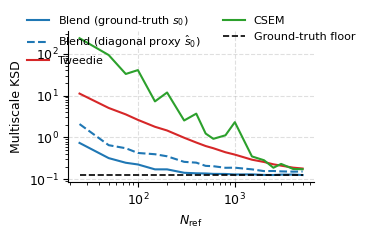

In [ ]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    import numpy as np

    plt.rcParams.update({
        "font.size": 9,
        "axes.spines.top": False,
        "axes.spines.right": False,
    })

    N_REFS = [25, 50, 75, 100, 150, 200, 300, 400, 500,
              600, 800, 1000, 1500, 2000, 2500, 3000, 4000, 5000]


    def pick_key(d, must_contain, exclude=None):
        """
        Find first key in d that contains all substrings in must_contain
        and does not contain any substring in exclude (case-insensitive).
        """
        if exclude is None:
            exclude = []
        must_contain = [s.lower() for s in must_contain]
        exclude      = [s.lower() for s in exclude]

        for k in d.keys():
            kl = k.lower()
            if all(s in kl for s in must_contain) and all(e not in kl for e in exclude):
                return k
        raise KeyError(f"No key found in {list(d.keys())} containing {must_contain} and excluding {exclude}")


    blend_divs       = []
    blend_proxy_divs = []
    tweedie_divs     = []
    csem_divs        = []
    floors           = []

    for N_REF in N_REFS:
        print(f"\n=== KSD sweep: N_ref = {N_REF} ===")
        res   = main1(
            N_REF      = N_REF,
            plot_hists = False,
            do_inv     = False,
            rand_seed  = True,
            div        = 'M_KSD',
            save_tag   = f'N_REF_{N_REF}',
            ridge_frac = 1e-6,
            trials     = 1,
        )
        ddivs = res['divs_dict']

        k_blend_true  = pick_key(ddivs, ["blend"], exclude=["proxy"])
        k_blend_proxy = pick_key(ddivs, ["blend", "proxy","svd"])
        k_tweedie     = pick_key(ddivs, ["tweedie"])
        k_csem        = pick_key(ddivs, ["csem"])

        blend_divs.append(      float(np.asarray(ddivs[k_blend_true]) [-1]))
        blend_proxy_divs.append(float(np.asarray(ddivs[k_blend_proxy])[-1]))
        tweedie_divs.append(    float(np.asarray(ddivs[k_tweedie])    [-1]))
        csem_divs.append(       float(np.asarray(ddivs[k_csem])       [-1]))
        floors.append(          float(ddivs["floor"]))

    floor_mean  = float(np.mean(floors))
    floors_plot = [floor_mean] * len(N_REFS)

    fig, ax = plt.subplots(figsize=(3.6, 2.7))

    ax.plot(N_REFS, blend_divs,
            color="tab:blue", lw=1.5, label="Blend (ground-truth $s_0$)")
    ax.plot(N_REFS, blend_proxy_divs,
            color="tab:blue", lw=1.5, ls="--", label="Blend (diagonal proxy $\\hat s_0$)")
    ax.plot(N_REFS, tweedie_divs,
            color="tab:red", lw=1.5, label="Tweedie")
    ax.plot(N_REFS, csem_divs,
            color="tab:green", lw=1.5, label="CSEM")
    ax.plot(N_REFS, floors_plot,
            color="black", lw=1.2, ls="--", label="Ground-truth floor")

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$N_{\text{ref}}$")
    ax.set_ylabel("Multiscale KSD")

    ax.grid(ls="--", alpha=0.4)
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.18),
        ncol=2,
        fontsize=8,
        frameon=False,
    )

    fig.tight_layout(rect=[0.0, 0.0, 1.0, 0.95])
    fig.savefig("figs/blend_ksd_vs_Nref.png", dpi=300)
    print("Saved figs/blend_ksd_vs_Nref.png")


In [ ]:
!rm *.png